In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import more_itertools as mit


%matplotlib inline  


In [2]:
def histograma(dataset, numero_bins=50, type_bins='log'):
    """
    Calcula el histograma de una serie de datos y guarda el resultado
    El input es una lista, no sirve meter como input un histograma X-Y
    INPUT:
        dataset (list, array): Datos sobre los que se hacen el histograma
        header (str): String for using in header and in file name
        output_path (str): Donde se guardara el resultado. IF OUTPUT_PATH=FALSE
                            devuelve el histograma y no lo guarda a archivo
        numero_bins (int): Numero de bins que se realizaran
        type_bins ('log', 'lin'): Relacion para generar los bins
        output_name (str): Name for the output file with extension .txt
        header_adicional (str): Aditional header info only for the file header
    OUTPUT:
        Guarda el resultado en output_path
        if output_path == FALSE: Devuelve bin_mean_x, counts_mean
    """

    dataset = np.asarray(dataset)

    # Defining edges depending if log or lin
    if (type_bins == 'log'):
        min_x = np.log10(np.min(dataset[dataset.nonzero()]))
        max_x = np.log10(np.max(dataset))
        bin_edges = np.logspace(min_x, max_x, numero_bins)
        
    elif (type_bins == 'lin'):
        min_x = np.min(dataset[dataset.nonzero()])
        max_x = np.max(dataset)
        bin_edges = np.linspace(min_x, max_x, numero_bins)

    # En que bin cae cada dato
    index = np.digitize(dataset, bin_edges)

    # Frecuencia de datos por bin
    datosPorBin = [len(dataset[index == i]) for i in range(1, len(bin_edges))]

    # Adimensionaliza la frecuencia por la anchura del bin
    counts_mean = datosPorBin/np.diff(bin_edges)
    counts_mean = counts_mean[counts_mean != 0]
    
    # version normalizada
    masatotal = np.sum(datosPorBin)
    counts_norm = counts_mean/masatotal

    # Posicion media del eje x
    bin_mean_x = [dataset[index == i].mean() for i in range(1, len(bin_edges))
                  if len(np.asarray(dataset[index == i])) > 0]

    return(bin_mean_x, counts_mean, counts_norm, bin_edges)

In [3]:
def binear_datos(lista_x, lista_y, bins=50, log = True):
    """
    Dado una lista de par de puntos (X,Y) binea dando lugar a una lista equivalente
    pero de menor dimension. Sirve para eliminar el ruido, variaciones, etc.
    INPUT:
        lista_x (list, array): Lista de puntos de igual dimension que lista_y
        lista_y (list, array): Lista de puntos de igual dimension que lista_x
        bins (int): numero de bins a utilizar
        log (boolean): True-> bins logaritmico, False-> bins lineales
    OUTPUT:
        posiciones (array): Centro de gravedad del bin. lista de posiciones X
        frecuencia_media(array): Frecuencia pesada en los bins
    """
    # Definicion de los bins
    if log:
        bin_edges = np.logspace(np.log10(min(lista_x)), np.log10(max(lista_x)), bins)
    else:
         bin_edges = np.linspace(min(lista_x), max(lista_x), bins)

    diccionario = dict() # valor*posicion
    diccionario_frecs = dict()
    for indice_x, value_x in enumerate(lista_x):
        indice_caja = np.searchsorted(bin_edges, value_x)
        if indice_caja in diccionario:
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])
        else:
            diccionario[indice_caja] = list()
            diccionario_frecs[indice_caja] = list()
            diccionario[indice_caja].append(lista_x[indice_x]*lista_y[indice_x])
            diccionario_frecs[indice_caja].append(lista_y[indice_x])

    frecuencia_media = []
    for key, value in diccionario_frecs.items():
        if len(value) > 0:
            frecuencia_media.append(np.mean(value))

        elif len(value) == 0:
            frecuencia_media.append(0)

    posiciones = []
    for key, value in diccionario.items():
        if len(value) > 0:
            posiciones.append(np.sum(value)/np.sum(diccionario_frecs[key]))
        elif len(value) == 0:
            posiciones.append((bin_edges[key] + bin_edges[key+1])/2)
            
    ## Ordenamos los datos
    import pandas as pd
    df = pd.DataFrame({"pos": posiciones, "freqs": frecuencia_media})
    df = df.sort_values("pos")

    posiciones = df.pos.values
    frecuencia_media = df.freqs.values
    
    return posiciones, frecuencia_media

In [4]:
def add_subplot_axes(ax, rect, fig, axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg, xscale = 'log', yscale ='log')
    #subax.xaxis.tick_top()
    subax.xaxis.set_label_position('bottom') 
    #subax.yaxis.tick_right()
    subax.yaxis.set_label_position('left')
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return(subax)

# Calcula las figuras de linguistic laws in human comunication
REQUISITO: Tener una tabla con las duraciones de cada fonema, palabra, etc


# 1. Cargar datos

In [5]:
input_path = 'data/humanos/Buckeye/TablaTranscripcion.csv'

# Cargar datos
tabla_datos = pd.read_table(input_path, delimiter=",", skiprows=1, 
                            names=['token', 'tinit', 'tend', 'duration', 'sentence', 'path', 'tipe', 'numtoken', 'numphonemes',
                                  'numletters'])
#len(tabla_datos)

# Para recuperar los okeys
#tabla_datos[tabla_datos.numtoken.isin(tabla_datos[tabla_datos.token == "okay"].numtoken)]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [7]:
# Filtramos y nos quedamos solo con palabras
lista_words = tabla_datos[((tabla_datos.tipe == 'w') & (tabla_datos.token != 'SIL')
                           & (tabla_datos.token != 'VOCNOISE') & (tabla_datos.token != 'UNKNOWN') 
                           & (tabla_datos.token != 'NOISE') & (tabla_datos.token != 'LAUGH'))]

# Creamos una columna que indique el numero de caracteres de esa palabra
lista_words = lista_words.assign(dur_characteres=lista_words.token.str.len())

#lista_words.head(3)

In [8]:
# Filtramos y nos quedamos solo con fonemas
lista_fonema = tabla_datos[((tabla_datos.tipe == 'p') & (tabla_datos.token != 'SIL') & (tabla_datos.token != 'VOCNOISE') 
                            & (tabla_datos.token != 'UNKNOWN') & (tabla_datos.token != 'NOISE') & (tabla_datos.token != 'LAUGH')
                            & (tabla_datos.token != 'IVER')
                            & (tabla_datos.token.str.endswith("}") == False) & (tabla_datos.token.str.startswith("{") == False))]


In [9]:
# Obtenemos las duraciones de las frases
dur_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().duration
# print(lista_fonema.token.unique())
# print(len(lista_fonema.token.unique()))
# tabla_datos[tabla_datos.token == "the"].head()
# tabla_datos[tabla_datos.numtoken == 131]

# Obtener las tablas 1 y 2


In [11]:
from statistics import mode

def imprimir_estadistica(listaduration, rnd, string):
    
    phonN = len(listaduration)
    phonMean = np.round(np.mean(listaduration), rnd)
    phonStd = np.round(np.std(listaduration), rnd)
    phonMode = mode(np.round(listaduration, rnd))
    phonMedian = np.round(np.median(listaduration), rnd)
    phonP10 = np.round(np.percentile(listaduration, 10), rnd)
    phonP90 = np.round(np.percentile(listaduration, 90), rnd)
    print(string + str(phonN) +"  "+ str(phonMean) + "  " + str(phonStd) +
      "  " + str(phonMode) + "  " + str(phonMedian) + "  " + str(phonP10) +
     "  " + str(phonP90))

print("                    Time Duration (s)")
print("           n     Mean  Std  Mode  Median  p10  p90")

imprimir_estadistica(lista_fonema.duration, 2, "Phoneme:   ")
imprimir_estadistica(lista_words.duration, 2, "Word:      ")
imprimir_estadistica(dur_sentences, 1, "BG:          ")


                    Time Duration (s)
           n     Mean  Std  Mode  Median  p10  p90
Phoneme:   796172  0.08  0.06  0.05  0.07  0.03  0.14
Word:      269565  0.24  0.17  0.12  0.2  0.08  0.45
BG:          45034  1.4  1.2  0.4  1.1  0.3  3.1


In [12]:
def imprimir_estadistica(listaduration, rnd, string):
    
    phonMean = np.round(np.mean(listaduration), rnd)
    phonStd = np.round(np.std(listaduration), rnd)
    phonMode = mode(np.round(listaduration, rnd))
    phonMedian = np.round(np.median(listaduration), rnd)
    phonP10 = np.round(np.percentile(listaduration, 10), rnd)
    phonP90 = np.round(np.percentile(listaduration, 90), rnd)
    print(string + str(phonMean) + "  " + str(phonStd) +
      "  " + str(phonMode) + "  " + str(phonMedian) + "  " + str(phonP10) +
     "  " + str(phonP90))

print("                    Num Characters")
print("         Mean Std  Mode  Median p10 p90")

numcharperphoneme = lista_words.numletters/lista_words.numphonemes
numcharperphoneme = numcharperphoneme[numcharperphoneme<7]

imprimir_estadistica(numcharperphoneme, 1, "Phoneme:   ")
imprimir_estadistica(lista_words.numletters, 0, "Word:      ")
char_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().numletters
imprimir_estadistica(char_sentences, 0, "BG:       ")

print("")
print("                    Num Phonemas")
imprimir_estadistica(lista_words.numphonemes, 1, "Word:      ")
phon_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").sum().numphonemes
imprimir_estadistica(phon_sentences, 0, "BG:      ")

print("")
print("                    Num Words")
words_sentences = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").count().numphonemes
imprimir_estadistica(words_sentences, 0, "BG:      ")


                    Num Characters
         Mean Std  Mode  Median p10 p90
Phoneme:   1.4  0.5  1.0  1.3  1.0  2.0
Word:      4.0  2.0  4  4.0  2.0  7.0
BG:       24.0  23.0  2  17.0  3.0  54.0

                    Num Phonemas
Word:      3.0  1.6  2  3.0  1.0  5.0
BG:      18.0  17.0  2  13.0  2.0  40.0

                    Num Words
BG:      6.0  6.0  1  4.0  1.0  13.0


In [10]:
# EJEMPLO DE LA FRASE Más LARGA
#a = tabla_datos[tabla_datos.tipe == "w"].groupby("sentence").size()
#frase = a[a==a.max()].index[0]

#tabla_datos[(tabla_datos.sentence == frase) & (tabla_datos.tipe == "w")]


In [11]:
# # EJEMPLO DE LA FRASE Mas corta
# # Obtenemos las duraciones de las frases
# frases1palabra = tabla_datos[(tabla_datos.tipe == "w")].groupby("sentence").size()
# frases1palabra = frases1palabra[frases1palabra==1].index

# subset = tabla_datos[tabla_datos['sentence'].isin(np.array(frases1palabra))]
# subset[(subset.tipe == "w") & (subset.duration < 0.15)]
#subset.groupby("sentence").size()
#a = .groupby("sentence").size()
#a = tabla_datos[(tabla_datos.tipe == "w")].groupby("sentence").size()
#frase = a[a==1]
#frase

#tabla_datos[(tabla_datos.sentence == frase) & (tabla_datos.tipe == "w")]


# 2. Histograma duraciones fonemas, palabras, frases y colapso

Calculamos los histogramas de duraciones en segundos

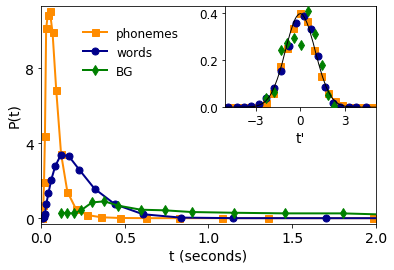

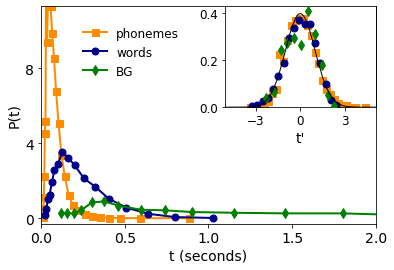

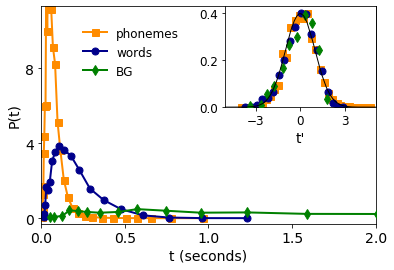

In [32]:

# Definimos adecuadamente el subconjunto de fonemas y palabras
fonemes_durationsall = lista_fonema.duration.values[(lista_fonema.duration.values<5) & (lista_fonema.duration.values>0)]
words_durationsall = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]
dur_sentencesall = dur_sentences

# Para cada informant
lista_fonema1 = lista_fonema[lista_fonema.path.str.startswith("s01/")]
fonemes_durations1 = lista_fonema1.duration.values[(lista_fonema1.duration.values<5) & (lista_fonema1.duration.values>0)]

lista_words1 = lista_words[lista_words.path.str.startswith("s01/")]
words_durations1 = lista_words1.duration.values[(lista_words1.duration.values<5) & (lista_words1.duration.values>0) ]

tabla_datos1 = tabla_datos[tabla_datos.path.str.startswith("s01/")]
dur_sentences1 = tabla_datos1[tabla_datos1.tipe == "w"].groupby("sentence").sum().duration

# Para cada informant
lista_fonema2 = lista_fonema[lista_fonema.path.str.startswith("s02/")]
fonemes_durations2 = lista_fonema2.duration.values[(lista_fonema2.duration.values<5) & (lista_fonema2.duration.values>0)]

lista_words2 = lista_words[lista_words.path.str.startswith("s02/")]
words_durations2 = lista_words2.duration.values[(lista_words2.duration.values<5) & (lista_words2.duration.values>0) ]

tabla_datos2 = tabla_datos[tabla_datos.path.str.startswith("s02/")]
dur_sentences2 = tabla_datos2[tabla_datos2.tipe == "w"].groupby("sentence").sum().duration




for i in range(3):
    if i == 0:
        fonemes_durations = fonemes_durationsall
        words_durations = words_durationsall
        dur_sentences = dur_sentencesall
    elif i == 1:
        fonemes_durations = fonemes_durations1
        words_durations = words_durations1
        dur_sentences = dur_sentences1
        
    elif i == 2:
        fonemes_durations = fonemes_durations2
        words_durations = words_durations2
        dur_sentences = dur_sentences2


    # Realizamos los histogramas
    bin_mean_x_fon, _, counts_norm_fon, _ = histograma(fonemes_durations, numero_bins=35)
    bin_mean_x_word, _, counts_norm_word, _ = histograma(words_durations, numero_bins=20)
    bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=22)


    # Ploteamos
    f, ax = plt.subplots()
    ax.plot(bin_mean_x_fon, counts_norm_fon, '-s', lw = 2, ms = 7, label= 'phonemes', zorder=1, c="darkorange")
    ax.plot(bin_mean_x_word, counts_norm_word, '-o', lw = 2, ms = 7, label= 'words', zorder=2, c='darkblue')
    ax.plot(bin_mean_x_sentence, counts_norm_sentence, '-d', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")


    ax.set_ylim([-0.3, 11.3])
    ax.set_xlim([0, 2])

    ax.set_xlabel("t (seconds)", fontsize=14)
    ax.set_ylabel("P(t)", fontsize=14)

    # Table


    col_labels=[r'$<t>$',r'$mode$']
    row_labels=['phon','words','senten']
    table_vals=[[np.round(np.mean(lista_fonema.duration.values[lista_fonema.duration.values<4]),3),
                 scipy.stats.mode(np.round(lista_fonema.duration.values[lista_fonema.duration.values<4], 2))[0][0]],

                [np.round(np.mean(lista_words.duration.values[lista_words.duration.values<4]),2),
                 scipy.stats.mode(np.round(lista_words.duration.values[lista_words.duration.values<4], 2))[0][0]],

               [np.round(np.mean(dur_sentences), 1),
                   scipy.stats.mode(np.round(dur_sentences, 2))[0][0]]]


    ######################################
    ## COLAPSO DE LOS DATOS##############3
    # Vamos a intentar colapsar los datos
    log_fonemes_dur = np.log(fonemes_durations)
    log_fonemes_dur = (log_fonemes_dur - np.mean(log_fonemes_dur))/np.std(log_fonemes_dur)

    log_words_dur = np.log(words_durations)
    log_words_dur = (log_words_dur - np.mean(log_words_dur))/np.std(log_words_dur)

    log_sentences_dur = np.log(dur_sentences)
    log_sentences_dur = (log_sentences_dur - np.mean(log_sentences_dur))/np.std(log_sentences_dur)

    # Datos Normales 0,1
    randomNormal = np.random.normal(0, 1, 10000000)

    # Realizamos los histogramas
    bin_mean_x_fon_collapsed, _, counts_norm_fon_collapsed, _ = histograma(log_fonemes_dur, numero_bins=35, type_bins="lin")
    bin_mean_x_word_collapsed, _, counts_norm_word_collapsed, _ = histograma(log_words_dur, numero_bins=20, type_bins="lin")
    bin_mean_x_sentence_collapsed, _, counts_norm_sentence_collapsed, _ = histograma(log_sentences_dur, numero_bins=12, type_bins="lin")

    bin_mean_x_normal, _, counts_norm_normal, _ = histograma(randomNormal, numero_bins=200, type_bins="lin")


    # Ploteamos
    subax = plt.axes([0.55, 0.53, .35, .35])
    subax.plot(bin_mean_x_fon_collapsed, counts_norm_fon_collapsed, 's', lw = 2, ms = 7, label= 'phonemes', zorder=1, c="darkorange")
    subax.plot(bin_mean_x_word_collapsed, counts_norm_word_collapsed, 'o', lw = 2, ms = 7, label= 'words', zorder=2, c='darkblue')
    subax.plot(bin_mean_x_sentence_collapsed, counts_norm_sentence_collapsed, 'd', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")
    subax.plot(bin_mean_x_normal, counts_norm_normal, '-s', lw = 1, ms = 0, label= 'phonemes', zorder=5, c = 'k')


    subax.set_xlim([-5.1,5.1])
    subax.set_ylim([0, 0.43])
    subax.set_xticks([-3,0,3])
    subax.set_yticks([0, 0.2, 0.4])

    subax.set_xlabel("t'", fontsize=14)


    subax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_xticks([0, 0.5, 1, 1.5, 2])
    ax.set_yticks([0, 4, 8])

    ax.legend(loc=(0.11, 0.65), frameon=False, fontsize = 12)


    if i == 0:
        f.savefig("resultados/Buckeye/1_LeyesLinguisticas/1_Probability_distribution_duration.pdf")
    if i == 1:
        f.savefig("resultados/Buckeye/1_LeyesLinguisticas/1_Probability_distribution_duration_informant1.pdf")
    if i == 2:
        f.savefig("resultados/Buckeye/1_LeyesLinguisticas/1_Probability_distribution_duration_informant2.pdf")




## 2.01. Modelo nulo duracion distribucion. MEAN FIELD MODEL


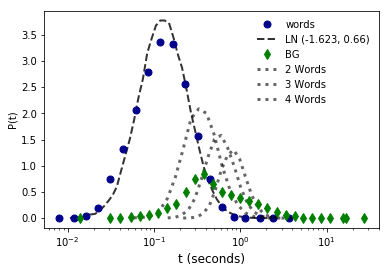

In [14]:
# FIGURA DEL SUPLEMENTARY INFORMATION 2

randLNWord = np.random.lognormal(mean=-1.623, sigma=0.66, size=200000)
bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randLNWord, numero_bins=50, type_bins="log")

# WORDS
# MODELO LN
randSentence4 = [np.random.choice(randLNWord, 2).sum() for x in range(60000)]
bin_mean_x_randSentence4, _, counts_norm_randSentence4, _ = histograma(randSentence4, numero_bins=20, type_bins="log")

randSentence5 = [np.random.choice(randLNWord, 3).sum() for x in range(60000)]
bin_mean_x_randSentence5, _, counts_norm_randSentence5, _ = histograma(randSentence5, numero_bins=20, type_bins="log")

randSentence6 = [np.random.choice(randLNWord, 4).sum() for x in range(60000)]
bin_mean_x_randSentence6, _, counts_norm_randSentence6, _ = histograma(randSentence6, numero_bins=20, type_bins="log")


# MODELO ALEATORIO



# Ploteamos
f, ax = plt.subplots()
# WORDS REAL AND RANDOM
ax.plot(bin_mean_x_word, counts_norm_word, 'o', lw = 1, ms = 7, label= 'words', zorder=2, c='darkblue')
ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'LN (-1.623, 0.66)', zorder=1, c="k", alpha=0.8)

# BG REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=32)
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")

# BG MODEL
ax.plot(bin_mean_x_randSentence4, counts_norm_randSentence4, ':', lw = 3, ms = 2, label= '2 Words', zorder=2, c="k", alpha=0.6)
ax.plot(bin_mean_x_randSentence5, counts_norm_randSentence5, ':', lw = 3, ms = 2, label= '3 Words', zorder=2, c="k", alpha=0.6)
ax.plot(bin_mean_x_randSentence6, counts_norm_randSentence6, ':', lw = 3, ms = 2, label= '4 Words', zorder=2, c="k", alpha=0.6)



ax.set_xscale("log")

#ax.set_ylim([0, 11.2])
#ax.set_xlim([0, 2])

ax.set_xlabel("t (seconds)", fontsize = 12)
ax.set_ylabel("P(t)")
ax.legend(loc="best", frameon=False)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI:2_Mean_Field_model_words_BG.pdf")

## 2.02. Modelo nulo duracion distribucion. Conociendo Numero de palabras por frase

In [15]:
# # RANDOM LN PHONEME GENERATION
# randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=20000)
# bin_mean_x_fon_rand, _, counts_norm_fon_rand, _ = histograma(randLNphonemes, numero_bins=70, type_bins="log")


# # NUMERO DE PHONEMAS POR PALABRA
# PhonemesPerWord = np.asarray(lista_words.numphonemes)

# randWord = [np.random.choice(randLNphonemes, np.random.choice(PhonemesPerWord, 1)).sum() for x in range(5000)]
# bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randWord, numero_bins=30, type_bins="log")


# # NUMERO DE PALABRAS POR FRASE
# WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

# randSentence = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() for x in range(3000)]
# bin_mean_x_sentence_rand, _, counts_norm_sentence_rand, _ = histograma(randSentence, numero_bins=30, type_bins="log")

# bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=22)


# # MODELO PALABRAS POR FRASE INCLUYENDO LA NORMAL
# randSentenceNORMAL = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() + np.random.normal(0.14, 0.08)  for x in range(30000)]
# randSentenceNORMAL = np.asarray(randSentenceNORMAL)
# randSentenceNORMAL = randSentenceNORMAL[randSentenceNORMAL>0.01]
# bin_mean_x_sentence_randNORMAL, _, counts_norm_sentence_randNORMAL, _ = histograma(randSentenceNORMAL, numero_bins=30, type_bins="log")



# # Ploteamos
# f, ax = plt.subplots()

# # PHONEMES real and random
# ax.plot(bin_mean_x_fon, counts_norm_fon, 's', lw = 1, ms = 7, label= 'phonemes', zorder=1, c="darkorange")
# ax.plot(bin_mean_x_fon_rand, counts_norm_fon_rand, '--', lw = 2, ms = 1, label= 'LN(-2.68, 0.59)', zorder=1, c="darkorange", alpha=0.8)

# # WORDS
# ax.plot(bin_mean_x_word, counts_norm_word, 'o', lw = 2, ms = 7, label= 'words', zorder=2, c='darkblue')
# ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'MF model words P(n)', zorder=2, c="darkblue", alpha=0.8)

# ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")
# #ax.plot(bin_mean_x_sentence_rand, counts_norm_sentence_rand, '--', lw = 2, ms = 1, label= 'MF model BG P(n)', zorder=3, c="g", alpha=0.8)


# ax.plot(bin_mean_x_sentence_randNORMAL, counts_norm_sentence_randNORMAL, '--', lw = 2, ms = 1, label= 'MF model BG P(n) + N(0.14, 0.07)', zorder=3, c="g", alpha=0.8)


# #ax.set_xscale("log")

# ax.set_ylim([0,4])
# ax.set_xlim([0, 2.4])

# ax.set_xlabel("t (seconds)")
# ax.set_ylabel("P(t)")
# ax.legend(loc="best", frameon=False)



# f.savefig("resultados/Buckeye/1_LeyesLinguisticas/2_Modelo_P(n)_DuracionPhonemes_Words_BG.pdf")

## Mismo modelo nuevas 3 figuras

/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


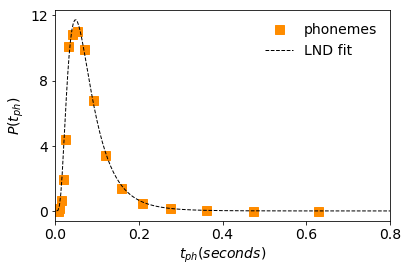

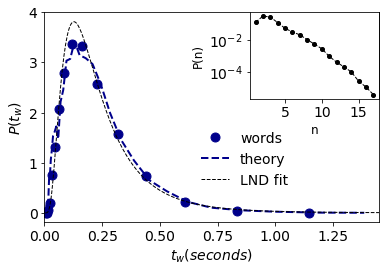

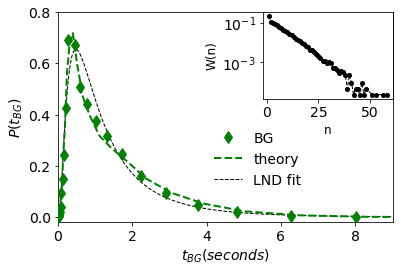

In [16]:
# RANDOM LN PHONEME GENERATION
randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=10000)
bin_mean_x_fon_rand, _, counts_norm_fon_rand, _ = histograma(randLNphonemes, numero_bins=60, type_bins="log")


# NUMERO DE PHONEMAS POR PALABRA
PhonemesPerWord = np.asarray(lista_words.numphonemes)

randWord = [np.random.choice(randLNphonemes, np.random.choice(PhonemesPerWord, 1)).sum() for x in range(10000)]#4
bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randWord, numero_bins=35, type_bins="log")


# NUMERO DE PALABRAS POR FRASE
WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

randSentence = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() for x in range(2000)]
bin_mean_x_sentence_rand, _, counts_norm_sentence_rand, _ = histograma(randSentence, numero_bins=30, type_bins="log")

bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)


# MODELO PALABRAS POR FRASE INCLUYENDO LA NORMAL
randSentenceNORMAL = [np.random.choice(randWord, np.random.choice(WordsPerSentence, 1)).sum() + np.random.normal(0.14, 0.08)  for x in range(30000)]
randSentenceNORMAL = np.asarray(randSentenceNORMAL)
randSentenceNORMAL = randSentenceNORMAL[randSentenceNORMAL>0.01]
bin_mean_x_sentence_randNORMAL, _, counts_norm_sentence_randNORMAL, _ = histograma(randSentenceNORMAL, numero_bins=30, type_bins="log")


################################################################################################
# # Ploteamos
f, ax = plt.subplots()

# # PHONEMES real and random
ax.plot(bin_mean_x_fon, counts_norm_fon, 's', lw = 1, ms = 9, label= 'phonemes', zorder=1, c="darkorange")
xlin = np.linspace(0, max(bin_mean_x_fon), 1000)
mu = -2.68
sigma = 0.59
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=1, c="k", alpha=1)


#ax.plot(bin_mean_x_fon_rand, counts_norm_fon_rand, '--', lw = 1, ms = 1, label= 'LN(-2.68, 0.59)', zorder=1, c="k", alpha=1)
ax.legend(loc="best", frameon=False, fontsize = 14)
ax.set_xlim([0, 0.7])

ax.set_xlabel(r"$t_{ph} (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_{ph})$", fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0, 4, 8, 12])

f.subplots_adjust(bottom=0.15)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/2_Modelo_P(n)_DuracionPhonemes_Words_BG_1.pdf")

#########################################################################################################
# # WORDS
f, ax = plt.subplots()
ax.plot(bin_mean_x_word, counts_norm_word, 'o', lw = 2, ms = 9, label= 'words', zorder=2, c='darkblue')
ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'theory', zorder=2, c="darkblue", alpha=1)
xlin = np.linspace(0, max(bin_mean_x_word), 1000)
mu = -1.62331
sigma = 0.66019
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)



# ax.set_ylim([0,4])
ax.set_xlim([0, 1.45])

ax.set_xlabel(r"$t_w (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_w)$", fontsize = 14)
ax.legend(loc=(0.45, 0.14), frameon=False, fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25])


subax = plt.axes([ax.get_position().x1 - 0.3, ax.get_position().y1 - 0.3, .3, .3])
PhonemesPerWord = np.asarray(lista_words.numphonemes)
from collections import Counter
counts = Counter(PhonemesPerWord)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()

subax.plot(counts[0], counts[1], '--o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)
subax.set_xlabel("n", fontsize = 12)
subax.set_ylabel("P(n)", fontsize = 12)
subax.tick_params(axis='both', which='major', labelsize=14)

subax.set_yscale("log")

f.subplots_adjust(bottom=0.15)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/2_Modelo_P(n)_DuracionPhonemes_Words_BG_2.pdf")



#########################################################################################################
f, ax = plt.subplots()

ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 9, label= 'BG', zorder=3, c="g")
#ax.plot(bin_mean_x_sentence_rand, counts_norm_sentence_rand, '--', lw = 2, ms = 1, label= 'MF model BG P(n)', zorder=3, c="k", alpha=1)
ax.plot(bin_mean_x_sentence_randNORMAL, counts_norm_sentence_randNORMAL, '--', lw = 2, ms = 1, label= 'theory', zorder=3, c="g", alpha=1)
xlin = np.linspace(0, max(bin_mean_x_sentence), 1000)
mu = 0.02523
sigma = 0.86027
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)
ax.tick_params(axis='both', which='major', labelsize=14)



ax.set_xlim([0, 9])
ax.set_ylim([-0.02, 0.8])

ax.legend(loc=(0.45, 0.14), frameon=False, fontsize = 14)

ax.set_xlabel(r"$t_{BG} (seconds)$", fontsize = 14)
ax.set_ylabel(r"$P(t_{BG})$", fontsize = 14)


subax = plt.axes([ax.get_position().x1 - 0.3, ax.get_position().y1 - 0.3, .3, .3])

WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

from collections import Counter
counts = Counter(WordsPerSentence)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()
subax.plot(counts[0], counts[1], '--o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)

subax.set_xlabel("n", fontsize = 12)
subax.set_ylabel("W(n)",fontsize = 12)
subax.set_yscale("log")
subax.tick_params(axis='both', which='major', labelsize=14)


f.subplots_adjust(bottom=0.15)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/2_Modelo_P(n)_DuracionPhonemes_Words_BG_3.pdf")




## Ajuste P(n)

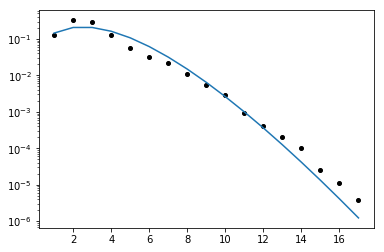

In [17]:
PhonemesPerWord = np.asarray(lista_words.numphonemes)
from collections import Counter
counts = Counter(PhonemesPerWord)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()

f,ax = plt.subplots()

ax.plot(counts[0], counts[1], 'o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)
ax.plot(counts[0], scipy.stats.nbinom(18,0.85).pmf(counts[0]))
ax.set_yscale("log")

modelBN = 2


/usr/local/lib/python3.6/dist-packages/scipy/stats/_discrete_distns.py:186: RuntimeWarning: divide by zero encountered in log
  return coeff + n*log(p) + special.xlog1py(x, -p)
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


1.7609016355860447
18 0.8693467336683417


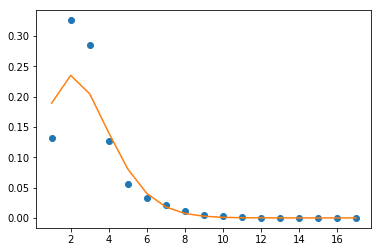

In [18]:
x = counts[0].values
y = counts[1].values

f,ax = plt.subplots()
ax.plot(x, y, 'o')
# ax.set_yscale("log")

# a = 2
# b = 0.1


def loglik(params):
    a = params[0]
    b = params[1]
    # def loglik(a, b): 
    #     # Calcula el MeanLogLikelihoood de los datos
    #     # Power law function
    Probabilities = scipy.stats.nbinom(a,b).pmf(x)

    # Normalized
    Probabilities = Probabilities/Probabilities.sum()

    # Multiply the vector by probabilities
    Lvector = np.log(Probabilities) * y

    # LL is the sum
    L = Lvector.sum()
    
    return(-L)


LL = 100
for a in range(1,19):
    for b in np.linspace(0,1,200):
        L = loglik(np.asarray([a,b]))
        if L < LL:
            LL = L
            best_a = a
            best_b = b
            
print(LL)
ax.plot(counts[0], scipy.stats.nbinom(best_a, best_b).pmf(counts[0]))

print(best_a, best_b)

/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


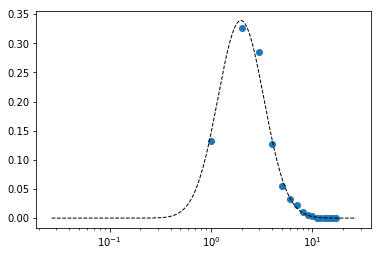

In [19]:

f,ax = plt.subplots()
ax.plot(x, y, 'o')

s, loc, scale = scipy.stats.lognorm.fit(PhonemesPerWord,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s

# xlin = np.linspace()

mu = estimated_mu
sigma = estimated_sigma
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)

ax.set_xscale("log")


## Ajuste W(n)

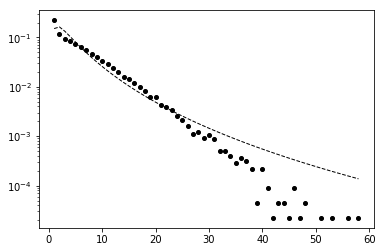

In [21]:
f, ax = plt.subplots()
WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

from collections import Counter
counts = Counter(WordsPerSentence)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()
ax.plot(counts[0], counts[1], 'o', lw = 1, ms = 4, zorder=2, c = 'k', alpha = 1)


s, loc, scale = scipy.stats.lognorm.fit(WordsPerSentence,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s

ax.set_yscale("log")

xlin = counts[0]

mu = estimated_mu
sigma = estimated_sigma
pdf = (np.exp(-(np.log(xlin) - mu)**2 / (2 * sigma**2)) / (xlin * sigma * np.sqrt(2 * np.pi)))
ax.plot(xlin, pdf, '--', lw = 1, ms = 1, label= 'LND fit', zorder=2, c="k", alpha=1)

In [23]:
# # ESTA FIGURA NO LA HEMOS DIBUJADO
# randLN1 = np.random.lognormal(mean=-1.623, sigma=0.66, size=60000)
# bin_mean_x_word_rand, _, counts_norm_word_rand, _ = histograma(randLN1, numero_bins=40, type_bins="log")


# WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())
# randSentence = [np.random.choice(randLN1, np.random.choice(WordsPerSentence, 1)).sum() for x in range(30000)]

# #bin_mean_x_sentence_rand, _, counts_norm_sentence_rand, _ = histograma(randSentence, numero_bins=30, type_bins="log")

# randSentence = [np.random.choice(randLN1, np.random.choice(WordsPerSentence, 1)).sum() + np.random.normal(0.13, 0.08)  for x in range(30000)]
# randSentence = np.asarray(randSentence)
# randSentence = randSentence[randSentence>0.01]
# bin_mean_x_sentence_rand, _, counts_norm_sentence_rand, _ = histograma(randSentence, numero_bins=30, type_bins="log")


# # Ploteamos
# f, ax = plt.subplots()

# ax.plot(bin_mean_x_word, counts_norm_word, '-o', lw = 1, ms = 7, label= 'words', zorder=2, c='darkblue')
# ax.plot(bin_mean_x_word_rand, counts_norm_word_rand, '--', lw = 2, ms = 1, label= 'LN mean=-1.623, sigma = 0.66', zorder=2, c="k", alpha=0.6)

# ax.plot(bin_mean_x_sentence, counts_norm_sentence, '-d', lw = 2, ms = 7, label= 'BG', zorder=3, c="g")
# ax.plot(bin_mean_x_sentence_rand, counts_norm_sentence_rand, '--', lw = 2, ms = 1, label= 'Random BG con P(n)', zorder=3, c="k", alpha=0.6)


# ax.set_xscale("log")
# #ax.set_xlim([0,8])
# ax.set_ylim([0,2])

# ax.set_xlabel("t (seconds)")
# ax.set_ylabel("P(t)")
# ax.legend(loc="best", frameon=False)

# f.savefig("resultados/Buckeye/1_LeyesLinguisticas/002_Modelo_P(n)_Duracion_Words_Sentences.pdf")

In [25]:
# # COEFICIENTE DE VARIACION
# CVfoneme = np.std(fonemes_durations) / np.mean(fonemes_durations)
# CVwords = np.std(words_durations) / np.mean(words_durations)
# CVsentence = np.std(dur_sentences) / np.mean(dur_sentences)

# #CVfoneme = np.sqrt(np.e**(np.std(np.log(fonemes_durations)))**2 - 1)
# #CVwords = np.sqrt(np.e**(np.std(np.log(words_durations)))**2 - 1)
# #CVsentence = np.sqrt(np.e**(np.std(np.log(dur_sentences)))**2 - 1)

# print("CVfoneme : {0:.3f}".format(CVfoneme))
# print("CVwords : {0:.3f}".format(CVwords))
# print("CVsentence : {0:.3f}".format(CVsentence))

# 2.1 Fiteo de las distribuciones

Fiteamos y realizamos los test de si es una lognormal o no

In [24]:
# FITEO CON LOGNORMAL DE LOS DATOS
file = open("resultados/Buckeye/1_LeyesLinguisticas/1_Fit_duration_distribution.txt","w") 

# Ajuste fonemas
s, loc, scale = scipy.stats.lognorm.fit(fonemes_durations,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("Foneme Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))
file.write("\n")
file.write("\n")

# Ajuste words
s, loc, scale = scipy.stats.lognorm.fit(words_durations,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("Word Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))
file.write("\n")
file.write("\n")

# Ajuste sentences
s, loc, scale = scipy.stats.lognorm.fit(dur_sentences,  floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s
file.write("Sentences Duration distribution\n")
file.write("mu: " + str(np.round(estimated_mu, 5)) + " sigma:" + str(np.round(estimated_sigma, 5)))

file.close() 

In [25]:
# KS GOODNESS OF FIT. COMPROBAR SI ES SUFICIENTEMENTE BUENO
# Check todas en: http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/
file = open("resultados/Buckeye/1_LeyesLinguisticas/1_Goodness_of_fit.txt","w") 
cdfs = ["lognorm", "beta", "gamma", "weibull_min", "norm"]

file.write("FONEMES\n")
for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+cdf+".fit(fonemes_durations)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(fonemes_durations, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"D: "+str(D) + "\n")
file.write("\n")
file.write("\n")

file.write("WORDS\n")
for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+cdf+".fit(words_durations)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(words_durations, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"D: "+str(D) + "\n")
file.write("\n")
file.write("\n")


file.write("SENTENCES\n")
for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("scipy.stats."+cdf+".fit(dur_sentences)")
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = scipy.stats.kstest(dur_sentences, cdf, args=parameters)
    D = np.round(D, 3)
    #pretty-print the results
    file.write(str(cdf.ljust(16)) + ("p: "+str(p)).ljust(25)+"  D: "+str(D) + "\n")
file.write("\n")
file.write("\n")

file.close()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# 2.2 Informacion mutua de los fonemas
En primer lugar hay que simbolizar las duraciones de las palabras. En vez de tener una duracion infinita, hacemos una simbolizacion de un numero finito de elementos

In [26]:
# Simbolizamos los niveles
def myround(x, base=0.03):
    return np.round(float(base * round(float(x)/base)), 3)

tablFonMutualInformation = tabla_datos[tabla_datos.tipe == "p"]
tablFonMutualInformation.loc[:, "duration"] = tablFonMutualInformation.duration.apply(myround)
tablFonMutualInformation.duration[tablFonMutualInformation.duration>0.24] = 0.24



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-pack

Se define una funcion que dado un array de n listas hace lo siguiente:
- Convierte las n listas de n elementos en listas de dos elementos.
- Calcula las probabilidades de cada par (x1, x2)
- Calcula la probabilidad de cada (x)
- Calcula la informacion mutua

In [27]:
import more_itertools as mit
def InformacionMutua(lista_tuples):
    # La informacion mutua se calcula en base 2
    # Convertir las listas de n elementos en otra lista de n tuples.
    lista = []
    listaelemtosindividual = []
    for item in lista_tuples:
        if len(item)>1:
            lista = lista + list(mit.windowed(item, n=2, step=1))
            listaelemtosindividual = listaelemtosindividual + item

    # Calculamos los diccionarios de probabilidades independientes y conjuntas
    dfJoinProbs = pd.DataFrame.from_dict(Counter(lista), orient='index').reset_index()
    dfJoinProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfJoinProbs.loc[:, "prob"] = dfJoinProbs.prob/dfJoinProbs.prob.sum() # Normalize

    dfIndepProbs = pd.DataFrame.from_dict(Counter(listaelemtosindividual), orient='index').reset_index()
    dfIndepProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfIndepProbs.loc[:,"prob"] = dfIndepProbs.prob/dfIndepProbs.prob.sum() # Normalize

    # Calculo de la informacion mutua media
    l_mutual_information = []
    for _, item in dfJoinProbs.iterrows():
        probt1t2 = item.prob
        probt1 = float(dfIndepProbs[dfIndepProbs.element == item.element[0]].prob)
        probt2 = float(dfIndepProbs[dfIndepProbs.element == item.element[1]].prob)
        mi = probt1t2 * np.log2(probt1t2/(probt1*probt2))
        l_mutual_information.append(mi)

    informacion_mutua = np.sum(l_mutual_information)
    return(informacion_mutua)
    
    

In [24]:
namefichero = "resultados/Buckeye/1_LeyesLinguisticas/2_Informacion_mutua_fonemas.txt"
file = open(namefichero, "w") 

# Agrupar por token y convertir cada palabra a una lista de duraciones
DurationLista = np.array(tablFonMutualInformation.groupby("numtoken")["duration"].apply(list))
print("calculando informacion mutua")
imutua = InformacionMutua(DurationLista)
print("informacion mutua: " + str(imutua))

file.write("Informacion mutua real: " + str(imutua) + "\n")
file.close()

calculando informacion mutua


KeyboardInterrupt: 

In [ ]:
# Primero realizamos una copia del elemento
randomtablFonMutualInformation  = tablFonMutualInformation.copy()


for i in np.arange(0, 10):
    print(i)
    # Se extrae la columna que indica a que palabra pertenece y se randomiza
    column = tablFonMutualInformation.numtoken.sample(frac=1.0) # shuffle
    column.reset_index(inplace=True, drop=True)
    randomtablFonMutualInformation.drop(columns= "numtoken", inplace=True)
    randomtablFonMutualInformation["numtoken"] = np.array(column)
    
    RANDDurationLista = np.array(randomtablFonMutualInformation.groupby("numtoken")["duration"].apply(list))
    print("calculando informacion mutua")
    RANDimutua = InformacionMutua(RANDDurationLista)
    print("informacion mutua: " + str(RANDimutua))
    
    file = open(namefichero,"a")
    file.write("Informacion mutua random: " + str(RANDimutua) + "\n")
    file.close()




# 2.3 Informacion mutua palabras

In [ ]:
# Simbolizamos los niveles
def myround(x, base=0.10):
    return np.round(float(base * round(float(x)/base)), 2)

tablWordMutualInformation = tabla_datos[tabla_datos.tipe == "w"]
tablWordMutualInformation.loc[:, "duration"] = tablWordMutualInformation.duration.apply(myround)
tablWordMutualInformation.duration[tablWordMutualInformation.duration>0.7] = 0.7


In [ ]:
namefichero = "resultados/Buckeye/1_LeyesLinguisticas/2_Informacion_mutua_words.txt"
file = open(namefichero, "w") 

# Agrupar por token y convertir cada palabra a una lista de duraciones
DurationLista = np.array(tablWordMutualInformation.groupby("sentence")["duration"].apply(list))
print("calculando informacion mutua")
imutua = InformacionMutua(DurationLista)
print("informacion mutua: " + str(imutua))
file.write("Informacion mutua real: " + str(imutua) + "\n")
file.close()

In [ ]:
# Primero realizamos una copia del elemento
randomtablWordMutualInformation  = tablWordMutualInformation.copy()

for i in np.arange(0, 10):
    print(i)
    # Se extrae la columna que indica a que palabra pertenece y se randomiza
    column = tablWordMutualInformation.sentence.sample(frac=1.0) # shuffle
    column.reset_index(inplace=True, drop=True)
    randomtablWordMutualInformation.drop(columns= "sentence", inplace=True)
    randomtablWordMutualInformation["sentence"] = np.array(column)
    
    RANDDurationLista = np.array(randomtablWordMutualInformation.groupby("sentence")["duration"].apply(list))
    print("calculando informacion mutua")
    RANDimutua = InformacionMutua(RANDDurationLista)
    print("informacion mutua: " + str(RANDimutua))
    
    file = open(namefichero,"a")
    file.write("Informacion mutua random: " + str(RANDimutua) + "\n")
    file.close()

# 2.4 Plot Mutual Information

In [ ]:
imutuafonem = pd.read_table("resultados/Buckeye/1_LeyesLinguisticas/2_Informacion_mutua_fonemas.txt", delimiter=":", header = None)
IMFonemReal = imutuafonem[1][0]
IMFonemRandom = imutuafonem[1][1::]

imutuaword = pd.read_table("resultados/Buckeye/1_LeyesLinguisticas/2_Informacion_mutua_words.txt", delimiter=":", header = None)
IMWordsReal = imutuaword[1][0]
IMWordsRandom = imutuaword[1][1::]


f, ax = plt.subplots(figsize=[5,3.5])
ax.plot("Fonema", IMFonemReal, 'o', lw = 2, ms = 7, label= 'Real', c='r')
# Randomized
print("FONEMA")
print("I: " + str(IMFonemReal))

mean = np.mean(IMFonemRandom)
e = np.std(IMFonemRandom)

print("Irandom: " + str(mean) + " +/- " + str(e))

ax.errorbar(0, mean, e, linestyle='None', marker='^', label = 'Random', c='k')

# Words
print("WORD")
print("I: " + str(IMWordsReal))

ax.plot("Words", IMWordsReal, 'o', ms = 7, c='r')
# Randomized
mean = np.mean(IMWordsRandom)
e = np.std(IMWordsRandom)
ax.errorbar(1, mean, e, linestyle='None', marker='^', c='k')
print("Irandom: " + str(mean) + " +/- " + str(e))




ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlim([-1,2])
ax.set_ylim([0.0001, 0.1])

#ax.set_xlabel("t (seconds)")
ax.set_ylabel(r"$I(x_{n}, x_{n+1})$")
ax.set_title("Mean mutual information")
ax.legend()
plt.tight_layout()
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/1_2_Mutual_Information.pdf")


# Informacion mutual longitud de Breathe Groups





In [ ]:
from random import shuffle

def MutualInformationLista(ListaTamanoFrase):
    listaTuples = list(mit.windowed(ListaTamanoFrase, n=2, step=1))

    # Calculamos los diccionarios de probabilidades independientes y conjuntas
    dfJoinProbs = pd.DataFrame.from_dict(Counter(listaTuples), orient='index').reset_index()
    dfJoinProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfJoinProbs.loc[:, "prob"] = dfJoinProbs.prob/dfJoinProbs.prob.sum() # Normalize

    #
    dfIndepProbs = pd.DataFrame.from_dict(Counter(ListaTamanoFrase), orient='index').reset_index()
    dfIndepProbs.rename(columns={'index':'element', 0:'prob'}, inplace=True)
    dfIndepProbs.loc[:,"prob"] = dfIndepProbs.prob/dfIndepProbs.prob.sum() # Normalize

    # Calculo de la informacion mutua media
    l_mutual_information = []
    for _, item in dfJoinProbs.iterrows():
        probt1t2 = item.prob
        probt1 = float(dfIndepProbs[dfIndepProbs.element == item.element[0]].prob)
        probt2 = float(dfIndepProbs[dfIndepProbs.element == item.element[1]].prob)
        mi = probt1t2 * np.log2(probt1t2/(probt1*probt2))
        l_mutual_information.append(mi)
    

    informacion_mutua = np.sum(l_mutual_information)
    return(informacion_mutua)



ListaTamanoFrase = list(tabla_datos[tabla_datos.tipe=="w"].groupby("sentence").size())
ListaTamanoFraseOriginal = ListaTamanoFrase.copy()

print("Orden del tamano de la frase en numero de palabras")
print("Mutal Information: " + str(MutualInformationLista(ListaTamanoFraseOriginal)))

listaMIRandom = []
for i in range(10):
    shuffle(ListaTamanoFrase)
    listaMIRandom.append(MutualInformationLista(ListaTamanoFrase))

print("Random Mut Information: " + str(np.mean(listaMIRandom)) + "+/-" + str(np.std(listaMIRandom)))


# 2.5 Plot: Intento preliminar de ver la informacion mutua de forma simple

In [ ]:
#ndata = 5000

#tn0 = []
#tn1 = []
#for i in tabla_datos[tabla_datos.tipe == "p"].numtoken.unique()[0:ndata]:
#    a = np.array(tabla_datos[(tabla_datos.tipe == "p") & (tabla_datos.numtoken == i)].duration)
#    for j, item in enumerate(a[0:-1]):
#        tn0.append(item)
#        tn1.append(a[j+1])


# Ploteamos
#f, ax = plt.subplots(figsize=[6, 6])
#ax.plot(tn0, tn1, 'o', ms = 4, alpha = 0.2)
#ax.set_xlabel("duration " +  r"$f_n$")
#ax.set_ylabel("duration " + r"$f_{n + 1}$")
#ax.set_title("Relacion duración de un fonema en relación al siguiente")
#ax.set_xlim([0,0.3])
#ax.set_ylim([0,0.3])
#ax.grid(True)
#f.savefig("resultados/Buckeye/1_LeyesLinguisticas/1_1_Independencia_de_orden_fonemas.pdf")


# 2.6. Distribucion numero de fonemas por palabra

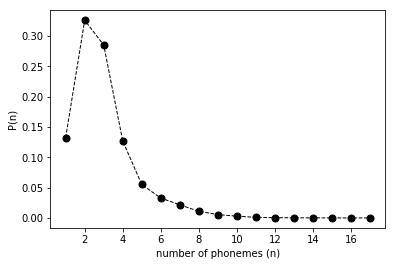

In [28]:
PhonemesPerWord = np.asarray(lista_words.numphonemes)
from collections import Counter
counts = Counter(PhonemesPerWord)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()
f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_xscale("log")
#ax.legend()
# print(counts)
ax.set_xlabel("number of phonemes (n)")
ax.set_ylabel("P(n)")
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI:3_Number_of_phonemes_per_word.pdf")

## 2.7. Distribucion numero de palabras por breathe group

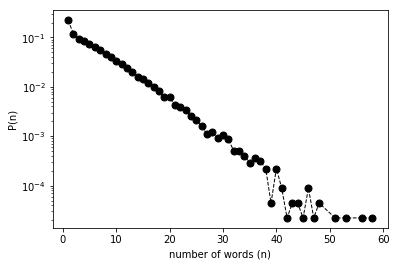

In [29]:
WordsPerSentence = np.asarray(lista_words.groupby("sentence").size())

from collections import Counter
counts = Counter(WordsPerSentence)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()

f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("number of words (n)")
ax.set_ylabel("P(n)")
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI:4_Number_of_words_per_BG.pdf")

## 2.8. Distribucion numero de caracteres por palabra

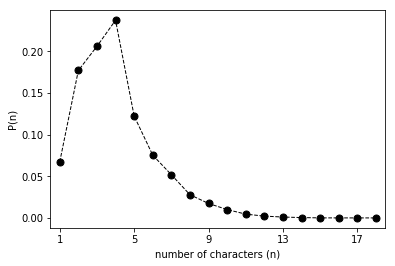

In [30]:
numcharperword = np.array(lista_words.numletters)

from collections import Counter
counts = Counter(numcharperword)
counts = sorted(counts.items(), key=lambda pair: pair[0], reverse=False)
counts = pd.DataFrame(counts)
counts[1]=counts[1]/counts[1].sum()


f, ax = plt.subplots()
ax.plot(counts[0], counts[1], '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_yscale("log")

ax.set_xlim([0.5, 18.5])
ax.set_xticks([1,5,9,13,17])

ax.set_xlabel("number of characters (n)")
ax.set_ylabel("P(n)")
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI:5_Number_of_characters_per_word.pdf")



## 2.9. Numero de caracteres por fonema

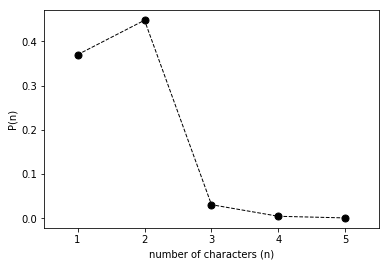

In [31]:
numcharperphoneme = lista_words.numletters/lista_words.numphonemes
numcharperphoneme = numcharperphoneme[numcharperphoneme<7]
bin1, _, counts, _ = histograma(numcharperphoneme, 6, "lin")


f, ax = plt.subplots()
ax.plot(np.round(bin1), counts, '--o', lw = 1, ms = 7, zorder=2, c = 'k', alpha = 1)
#ax.set_yscale("log")

ax.set_xlim([0.5, 5.5])
ax.set_xticks([1,2,3,4,5])

ax.set_xlabel("number of characters (n)")
ax.set_ylabel("P(n)")
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI:6_Number_of_characters_per_phoneme.pdf")



# 3. Ley de Zipf
Calculamos la ley de zip (corpus escrito) para el articulo

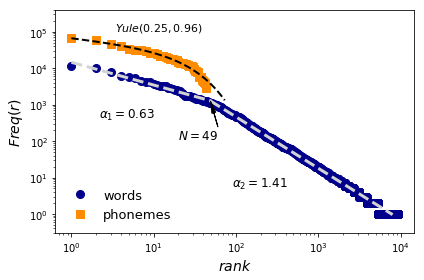

In [105]:
lista_fonema_token_process = lista_fonema.token.str.split(";", expand=True)[0]
lista_fonema_token_process = lista_fonema_token_process.str.split("+", expand=True)[0]


freqs_words = lista_words.token.value_counts()
freqs_phonemes = lista_fonema_token_process.value_counts()

freqs_words.index = np.arange(1, len(freqs_words) + 1)

freqs_phonemes.index = np.arange(1, len(freqs_phonemes) + 1)



f, ax = plt.subplots()
ax.plot(freqs_words[0:30000], 'o', lw = 2, ms = 8, label= 'words', zorder=2, alpha=1, c='darkblue')
ax.plot(freqs_phonemes[0:43], 's', lw = 2, ms = 8, label= 'phonemes', zorder=1,alpha=1, c='darkorange')


# PENDIENTE PHONEMAS
xphoneme = freqs_phonemes.index.values
yplotphon = xphoneme**(-0.25190558) * 0.96130884**xphoneme
yplotphon = yplotphon/yplotphon[0]*freqs_phonemes.values[0]
ax.plot(xphoneme, yplotphon, "--", color="k", lw = 2)
ax.text(0.29, 0.92, "$Yule(0.25, 0.96)$", horizontalalignment='center', fontsize = 11, verticalalignment='center', transform=ax.transAxes)




# WORDS

# Line pendiente
xline1 = np.array([1, 50])
yline1 = np.power(6.5*10**-7*xline1, -0.6243)
yline1 = yline1 * 2

ax.plot(xline1, yline1 , "--", color = "lightgray", lw = 3)
ax.text(0.2, 0.53, r'$\alpha_1 = 0.63$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)

xline2 = np.array([49, 8000])
yline2 = np.power(7*10**-5*xline2, -1.4107604)
yline2 = yline2/yline2[0]*yline1[-1]

ax.plot(xline2, yline2, "--", color = "lightgray", lw = 3)
ax.text(0.57, 0.22, r'$\alpha_2 = 1.41$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)


ax.annotate(r'$N=49$', xy=(49, yline2[0]), xytext=(20, yline2[0]*0.09), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.01, headwidth=4),
           fontsize=12)


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$rank$",fontsize=14)
ax.set_ylabel(r"$Freq(r)$", fontsize=14)
ax.legend(fontsize=13, frameon=False, loc=3)
ax.set_ylim([0.3, 4*10**5])

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/2_Zipf_law.pdf")

### ZIPF TESIS

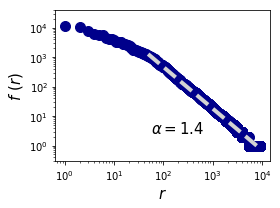

In [106]:
freqs_words = lista_words.token.value_counts()
freqs_words.index = np.arange(1, len(freqs_words) + 1)


f, ax = plt.subplots(figsize=[4,3])
ax.plot(freqs_words, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, c='darkblue')

# Line pendiente
xline1 = np.array([1, 50])
yline1 = np.power(6.5*10**-7*xline1, -0.6243)
yline1 = yline1 * 2

#ax.plot(xline1, yline1 , "--", color = "lightgray", lw = 3)
#ax.text(0.2, 0.53, r'$\alpha_1 = 0.63$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)

xline2 = np.array([49, 8000])
yline2 = np.power(7*10**-5*xline2, -1.4107604)
yline2 = yline2/yline2[0]*yline1[-1]

ax.plot(xline2, yline2, "--", color = "lightgray", lw = 4)
ax.text(0.57, 0.22, r'$\alpha = 1.4$', horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)

#ax.annotate(r'$N=49$', xy=(49, yline2[0]), xytext=(20, yline2[0]*0.09), 
#            arrowprops=dict(facecolor='black', shrink=0.01, width=0.01, headwidth=4),
#           fontsize=12)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$r$",fontsize=15)
ax.set_ylabel(r"$f \ (r)$", fontsize=15)
ax.set_ylim([0.3, 4*10**4])
f.tight_layout()
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/Zipf_tesis_teoria.pdf")

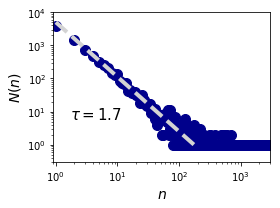

In [108]:
Zipf_n = freqs_words.value_counts()

f, ax = plt.subplots(figsize=[4,3])
ax.plot(Zipf_n, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, c='darkblue')

# Line pendiente
xline1 = np.array([1, 50])
yline1 = np.power(6.5*10**-7*xline1, -0.6243)
yline1 = yline1 * 2

#ax.plot(xline1, yline1 , "--", color = "lightgray", lw = 3)
#ax.text(0.2, 0.53, r'$\alpha_1 = 0.63$', horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)

xline2 = np.array([1, 200])
yline2 = np.power(7*10**-4*xline2, -1.65)
yline2 = yline2/yline2[0]*0.5*10**4

ax.plot(xline2, yline2, "--", color = "lightgray", lw = 4)
ax.text(0.2, 0.32, r'$\tau = 1.7$', horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)

#ax.annotate(r'$N=49$', xy=(49, yline2[0]), xytext=(20, yline2[0]*0.09), 
#            arrowprops=dict(facecolor='black', shrink=0.01, width=0.01, headwidth=4),
#           fontsize=12)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel(r"$n$",fontsize=14)
ax.set_ylabel(r"$N(n)$", fontsize=14)
ax.set_ylim([0.3, 1*10**4])
ax.set_xlim([0.9, 3*10**3])
f.tight_layout()

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/Zipf_tesis_teoria2.pdf")



# 3.1 Modelo Nulo Ley de Zipf

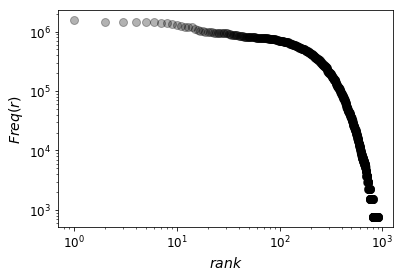

In [46]:
# Ploteamos
f, ax = plt.subplots()


words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

# Realizamos los histogramas
bin_mean_x, counts_mean, counts_norm, bin_edges = histograma(words_durations, numero_bins=3000, type_bins="lin")

freqs = np.sort(counts_mean)[::-1]
ax.plot(freqs, 'o', lw = 2, ms = 8, zorder=2, alpha=0.3, color='k')
ax.set_yscale("log")
ax.set_xscale("log")


ax.yaxis.set_label_position("left")
ax.yaxis.set_ticks_position("left")

#subax.set_xlim([0.1,8.5])
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_ticks_position("bottom")

ax.set_xlabel(r"$rank$",fontsize=14)
ax.set_ylabel(r"$Freq(r)$", fontsize=14,  rotation=90)

# ax.set_xticks([10**0,10**2])
# ax.set_yticks([10**4,10**6])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI_Zipf_Nul_Model.pdf")

## Ejemplo 1 de ajuste por MLE a Power Law

      fun: 0.9287456181185603
 hess_inv: array([[3.35223699]])
      jac: array([-9.85711813e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([2.59996642])


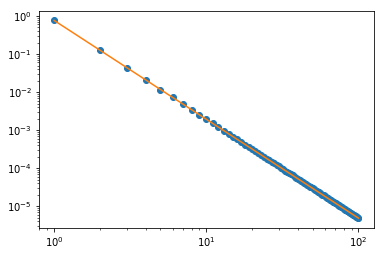

In [48]:
from scipy.optimize import minimize
# DATA
x = np.linspace(1,100, 100)
alpha = 2.6

y = np.power(x, -alpha)
y = y/y.sum()


x = x[0::]
y = y[0::]
y = y/y.sum()

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(b): 
    # Calcula el MeanLogLikelihoood de los datos
    # Power law function
    Probabilities = x**(-b)
    
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    #Lvector = np.log(Probabilities)
    
    # Multiply the vector by probabilities
    Lvector = np.log(Probabilities) * y
    
    # LL is the sum
    L = Lvector.sum()
    
    # Normalizo por rangos
    #L = L/len(x)
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

s_best = minimize(loglik, [2])
print(s_best)
ax.plot(x, y[0]*x**-s_best.x)


## Ejemplo 2 de ajuste por MLE a Power Law

      fun: 135438.99390161442
 hess_inv: array([[1.06438323e-05]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([1.62543332])


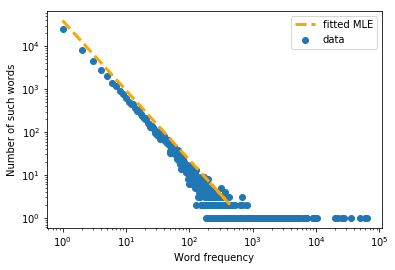

In [52]:
import nltk.corpus
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# may need nltk.download() to use Brown corpus
counter_of_words = Counter(nltk.corpus.brown.words())
counter_of_counts = Counter(counter_of_words.values())

# We sort data
counter_of_counts = sorted(counter_of_counts.items(), key=lambda pair: pair[1], reverse=True)
word_counts = np.asarray(counter_of_counts)[:,0]
freq_of_word_counts = np.asarray(counter_of_counts)[:,1]


f,ax = plt.subplots()
ax.scatter(word_counts, freq_of_word_counts, label = "data")
ax.set_xlabel('Word frequency')
ax.set_ylabel('Number of such words')
ax.set_xscale("log")
ax.set_yscale("log")



def loglik(b):  
    # Power law function
    Probabilities = word_counts**(-b)
    
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    Lvector = np.log(Probabilities)
    
    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) * freq_of_word_counts
    
    # LL is the sum
    L = Lvector.sum()
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

s_best = minimize(loglik, [2])
print(s_best)
ax.plot(word_counts[0:2*10**2], 4*10**4*word_counts[0:2*10**2]**-s_best.x, '--', color="orange", lw=3, label = "fitted MLE")
ax.legend()




In [50]:
from scipy.stats import chisquare
from scipy import stats

frequencies = freq_of_word_counts

prob_expected = word_counts**-s_best.x
prob_expected = prob_expected/prob_expected.sum()
prob_expected = prob_expected*freq_of_word_counts.sum()
prob_expected = prob_expected.round() + 1
frequencies = frequencies +1

testchi = chisquare(frequencies, f_exp=prob_expected, ddof=1)

# The chi square test tests the null hypothesis that the categorical data has the given frequencies.
testchi

Power_divergenceResult(statistic=439.2365042432199, pvalue=0.9998441370351222)

# ZIPF Power Law ajuste MLE 

      fun: 1672227.5457264248
 hess_inv: array([[4.84137113e-07]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([1.04516991])

3344467.5960176773


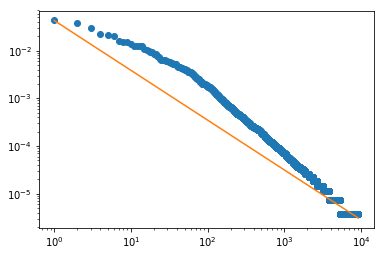

In [56]:
from scipy.optimize import minimize

# DATA
x = freqs_words.index.values
y = freqs_words.values
y = y/y.sum()

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(b):  
    # Power law function
    Probabilities = x**(-b)
    
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    Lvector = np.log(Probabilities)
    
    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities)*freqs_words.values
    
    # LL is the sum
    L = Lvector.sum()
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

s_best = minimize(loglik, [2])
print(s_best)
ax.plot(x, y[0]*x**-s_best.x)

print("")
BIC1 = 1* np.log(freqs_words.values.sum()) - 2*(-s_best.fun)

print(BIC1)

# Zipf Doble Power Law ajuste MLE

  
Mejor Resultados
49
      fun: 1635738.939600494
 hess_inv: array([[2.69548160e-07, 1.74029566e-07],
       [1.74029566e-07, 6.19266371e-06]])
      jac: array([ 0.      , -0.015625])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 69
      nit: 11
     njev: 17
   status: 2
  success: False
        x: array([0.62436382, 1.41076037])
3271502.888330643


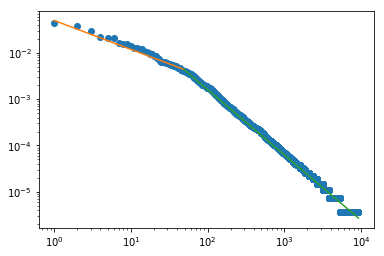

In [57]:
from scipy.optimize import minimize
# DATA
x = freqs_words.index.values[0::]
y = freqs_words.values[0::]
y = y/y.sum() # Normalizo a probabilidades

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(parameters):
    alpha = parameters[0]
    beta = parameters[1]

    Probabilities1 = list(x[0:cut]**(-alpha))
    
    # Conecto con el anterior
    Probabilities2 = list(x[cut-1::]**(-beta))
    Probabilities2 = Probabilities2/Probabilities2[0]*Probabilities1[-1]

    # Elimino el punto de conexion
    Probabilities2 = list(Probabilities2[1::])    
    
    Probabilities = Probabilities1 + Probabilities2
    Probabilities = np.asarray(Probabilities)
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    Lvector = np.log(Probabilities)
    
    # Multiply the vector by frequencies
    Lvector = np.log(Probabilities) *  freqs_words.values
    
    # LL is the sum
    L = Lvector.sum()
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)


# INICIALIZACION
bestcut = 0
ll_best = 10**10

for cut in range(30,100):
    mle = minimize(loglik, np.asarray([2,3]))
    if mle.fun < ll_best:
        mle_best = mle
        ll_best = mle.fun
        bestcut = cut
     

print("  ")
print("Mejor Resultados")    
print(bestcut)
print(mle_best)


x1 = x[0:bestcut]
x2 = x[bestcut-1::]

y1 = 0.05*x1 **(-mle_best['x'][0])
y2 = x2 **(-mle_best['x'][1])

ax.plot(x1, y1)
ax.plot(x2, y2/y2[0]*y1[-1])


################################################################
# CHI SQUARE ###################################################

from scipy.stats import chisquare
from scipy import stats

Probabilities1 = list(x[0:cut]**(-mle_best['x'][0]))
# Conecto con el anterior
Probabilities2 = list(x[cut-1::]**(-mle_best['x'][1]))
Probabilities2 = Probabilities2/Probabilities2[0]*Probabilities1[-1]
# Elimino el punto de conexion
Probabilities2 = list(Probabilities2[1::])    
Probabilities = Probabilities1 + Probabilities2
Probabilities = np.asarray(Probabilities)
# Normalized
ProbabilitiesExpected = Probabilities/Probabilities.sum()


FreqsReal = freqs_words.values
ProbabilitiesExpected = ProbabilitiesExpected*FreqsReal.sum()
ProbabilitiesExpected = ProbabilitiesExpected.round()

FreqsReal = FreqsReal + 1
ProbabilitiesExpected = ProbabilitiesExpected + 1

testchi = chisquare(ProbabilitiesExpected/3, f_exp=FreqsReal/3, ddof = 3)

# The chi square test tests the null hypothesis that the categorical data has the given frequencies.


BIC2 = 2*np.log(freqs_words.values.sum()) - 2*(-mle_best.fun)
print(BIC2)

## Ejemplo BIC

In [58]:
# DATA
data = stats.gamma.rvs(2, loc=1.5, scale=2, size=100)

# BIC
fitted_params = scipy.stats.gamma.fit(data)
logLik = np.sum(stats.gamma.logpdf(data, fitted_params[0], loc=fitted_params[1], scale=fitted_params[2]) ) 
k = len(fitted_params)
bics1 = k*np.log(len(data)) - 2*(logLik)
print(bics1)

# BIC2
fitted_params = scipy.stats.norm.fit(data)
logLik = np.sum( stats.norm.logpdf(data, fitted_params[0], fitted_params[1]) ) 
k = len(fitted_params)
bics2 = k*np.log(len(data)) - 2*(logLik)
print(bics2)


464.4696089316323
497.9500146628067


# Ajuste fonemas Zipf 

      fun: 3.5117215625035856
 hess_inv: array([[4.45813012, 0.36469991],
       [0.36469991, 0.03729836]])
      jac: array([0.00000000e+00, 5.96046448e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.25190522, 0.96130884])


Power_divergenceResult(statistic=6.457228483606629, pvalue=0.9999999997089971)

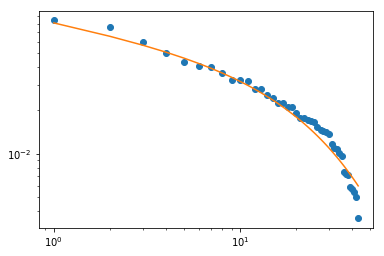

In [59]:
#ax.plot(freqs_phonemes[0:43], 's', lw = 2, ms = 8, label= 'phonemes', zorder=1,alpha=1, c='darkorange')


# DATA
x = freqs_phonemes.index.values[0:43]
y = freqs_phonemes.values[0:43]
y = y/y.sum()


x = x[0::]
y = y[0::]
y = y/y.sum()

f,ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xscale("log")
ax.set_yscale("log")

#####################
def loglik(param): 
    # Calcula el MeanLogLikelihoood de los datos
    b = param[0]
    c =param[1]
    # Power law function
    Probabilities = x**(-b)*c**x
    
    # Normalized
    Probabilities = Probabilities/Probabilities.sum()
    
    # Log Likelihoood
    #Lvector = np.log(Probabilities)
    
    # Multiply the vector by probabilities
    Lvector = np.log(Probabilities) * y
    
    # LL is the sum
    L = Lvector.sum()
    
    # Normalizo por rangos
    #L = L/len(x)
    
    # We want to maximize LogLikelihood or minimize (-1)*LogLikelihood
    return(-L)

s_best = minimize(loglik, np.asarray([2,1]))
print(s_best)
ax.plot(x, y[0]*x**(-s_best.x[0])* (s_best.x[1]**x))





################################################################
# CHI SQUARE ###################################################

from scipy.stats import chisquare
from scipy import stats

Probabilities = x**(-s_best.x[0])* (s_best.x[1]**x)
ProbabilitiesExpected = Probabilities/Probabilities.sum()

FreqsReal = freqs_phonemes.values[0:43]

ProbabilitiesExpected = ProbabilitiesExpected*FreqsReal.sum()
ProbabilitiesExpected = ProbabilitiesExpected.round()

FreqsReal = FreqsReal + 1
ProbabilitiesExpected = ProbabilitiesExpected + 1

testchi = chisquare(ProbabilitiesExpected/1000, f_exp=FreqsReal/1000, ddof = 2)

# The chi square test tests the null hypothesis that the categorical data has the given frequencies.
testchi

# 4. Brevity law 
Calculamos la ley de brevedad chequeando que las palabras más recuentes tienden a ser más cortas
Entendemos tres posibles definiciones:


## 4.1 WORDS
1. Frequencia palabras vs duracion en segundos
2. Frecuencia palabras vs numero de fonemas
3. Frecuencia de palabras vs numero de caracteres

In [15]:
# Creamos una columna que indique las veces que ha ocurrido esa palabra en nuestra base de datos
lista_words = lista_words.assign(repetitions=lista_words.token.map(lista_words.token.value_counts()))


Frequencia palabras vs duracion(segundos:
SpearmanrResult(correlation=-0.354472304425206, pvalue=4.294724046289204e-272)
R2: 0.15901818836109627

Frequencia palabras vs numero de fonemas:
SpearmanrResult(correlation=-0.2742364755537827, pvalue=2.642828352013145e-159)
R2: 0.09939061912170655

Frequencia palabras vs numero de caracteres:
SpearmanrResult(correlation=-0.2614605387765556, pvalue=3.651881969741118e-144)
R2: 0.09461253794719982


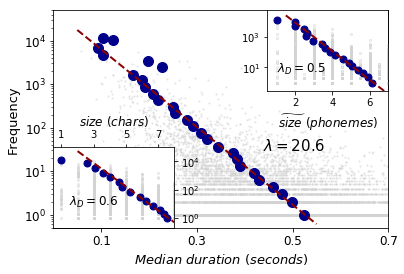

In [16]:
from scipy.optimize import curve_fit

def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )




## 1. Frequencia palabras vs duracion segundos
#brevity0 = lista_words.groupby("repetitions").duration.mean()
brevity0 = lista_words.groupby("token").median()[["duration", "repetitions"]]


#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis
print("Frequencia palabras vs duracion(segundos:")
print(scipy.stats.spearmanr(brevity0.duration, np.log(brevity0.repetitions)))

f, ax = plt.subplots()


### AHORA VAMOS A HACER UN BINING
freq0, pos0  = binear_datos(brevity0.repetitions, brevity0.duration, bins=28, log = True)

ax.plot(brevity0.duration, brevity0.repetitions, 'o', lw = 1, ms = 1, zorder=2, alpha=0.6, color = 'lightgray',fillstyle= "none")
ax.plot(pos0, freq0, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")

ax.set_xlabel(r"$Median$"+ " " + r"$duration$"+ " " + r"$(seconds)$", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlim([0,0.7])
ax.set_ylim([0.5,5*10**4])



## FITING
x = brevity0.repetitions
y = brevity0.duration

xplot = np.linspace(0.05, 0.55, 8)
popt, pcov = curve_fit(func_log, x, y)
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "darkred", lw = 2)

ax.text(0.72, 0.38, r'$\lambda = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


##############################################
## 2.frecuencia palabras vs numero de fonemas
##############################################
def func_exp64(x, a, b):
    return a * 64**(-b * x)

def func_log64(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(64) - np.log(a)/np.log(64) )




brevity1 = lista_words.groupby("token").median()[["numphonemes", "repetitions"]]

print("Frequencia palabras vs numero de fonemas:")
print(scipy.stats.spearmanr(brevity1.numphonemes, np.log(brevity1.repetitions)))


# Ploteamos
subax = plt.axes([ax.get_position().x1 - .28, ax.get_position().y1 - .28, .28, .28])

freq1, pos1 = binear_datos(brevity1.repetitions, brevity1.numphonemes, bins=18, log = True)
subax.plot(brevity1.numphonemes, brevity1.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.6, color = 'lightgray', fillstyle= "none")
subax.plot(pos1, freq1, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=1, color="darkblue")



## FITING#######################################################
x = brevity1.repetitions
y = brevity1.numphonemes

xplot = np.linspace(1.5, 8, 3)
popt, pcov = curve_fit(func_log64, x, y)
subax.plot(xplot, func_exp64(xplot, *popt), "--", color = "darkred", lw = 2)
subax.text(0.74, 0.73, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log64(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


subax.set_yscale("log")
subax.set_xlabel(r"$\widetilde{size}$" + " " +  r"$(phonemes)$", fontsize=12)
subax.set_xlim([0.5, 7])
subax.set_ylim([0.3, 50000])
#subax.set_ylabel("freq",rotation=0)


##############################################
## 3.frecuencia palabras vs numero de characters
##############################################
def func_exp26(x, a, b):
    return a * 26**(-b * x)

def func_log26(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(26) - np.log(a)/np.log(26) )




brevity2 = lista_words.groupby("token").median()[["numletters", "repetitions"]]

brevity2=brevity2[brevity2.numletters<15]
print("Frequencia palabras vs numero de caracteres:")
print(scipy.stats.spearmanr(brevity2.numletters, np.log(brevity2.repetitions)))


# Ploteamos
subax2 = plt.axes([ax.get_position().x0, ax.get_position().y0, .28, .28])

freq2, pos2 = binear_datos(brevity2.repetitions, brevity2.numletters, bins=13, log = True)
subax2.plot(brevity2.numletters, brevity2.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.4, color = 'lightgrey')
subax2.plot(pos2, freq2, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=1, color="darkblue")


## FITING#######################################################
x = brevity2.repetitions
y = brevity2.numletters

xplot = np.linspace(2, 12, 3)
popt, pcov = curve_fit(func_log26, x, y)
subax2.plot(xplot, func_exp26(xplot, *popt), "--", color = "darkred", lw = 2)
subax2.text(0.12, 0.12, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 12, verticalalignment='center', transform=ax.transAxes)



residuals = y - func_log26(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))



subax2.set_yscale("log")
#subax2.set_xscale("log")

subax2.set_xlabel(r"$size$" + " " +  r"$(chars)$",rotation=0, fontsize=12)
subax2.set_xlim([0.5, 8])
subax2.set_ylim([0.2, 10**5])

subax2.yaxis.set_label_position("right")
subax2.yaxis.set_ticks_position("right")

#subax2.set_ylabel("freq",rotation=0)
subax2.xaxis.set_label_position("top")
subax2.xaxis.set_ticks_position("top")



subax2.set_xticks([1,3,5,7])
subax2.set_yticks([10**0,10**2, 10**4])

#subax2.set_yticks([10**3,10**5])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words.pdf")



### Brevedad tesis teoria

No handles with labels found to put in legend.


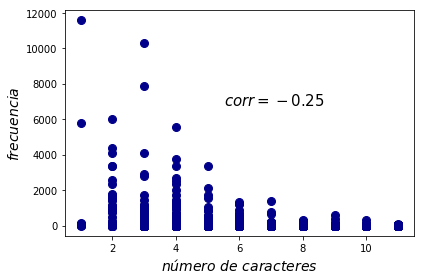

In [17]:
f, ax = plt.subplots(figsize=[6,4])
brevity2=brevity2[brevity2.numletters<12]

ax.text(0.6, 0.6, r'$corr = -0.25$', horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)


ax.set_xlabel(r"$número \ de \ caracteres$",fontsize=14)
ax.set_ylabel(r"$frecuencia$", fontsize=14)
ax.legend(fontsize=13, frameon=False, loc=3)
#ax.set_ylim([0.3, 4*10**5])

ax.plot(brevity2.numletters, brevity2.repetitions, 'o', lw = 1, ms = 8, zorder=2, color = 'darkblue')
f.tight_layout()
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/Brevedad_teoria_tesis.pdf")


# Figuras tesis


Frequencia palabras vs duracion(segundos:
SpearmanrResult(correlation=-0.354472304425206, pvalue=4.294724046289204e-272)
R2: 0.15901818836109627

Frequencia palabras vs numero de fonemas:
SpearmanrResult(correlation=-0.2742364755537827, pvalue=2.642828352013145e-159)
R2: 0.09939061912170655

Frequencia palabras vs numero de caracteres:
SpearmanrResult(correlation=-0.2614605387765556, pvalue=3.651881969741118e-144)
R2: 0.09461253794719982


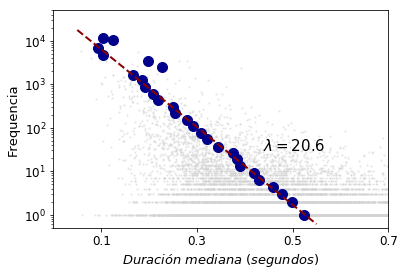

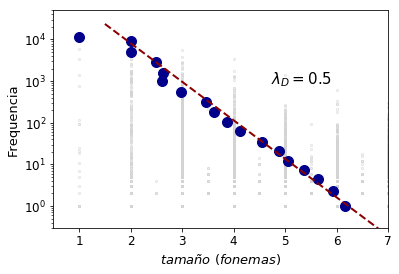

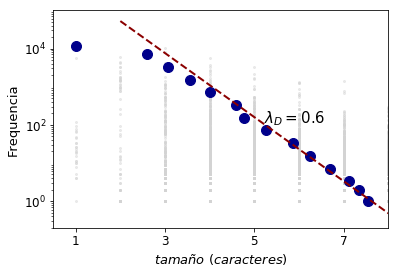

In [40]:
from scipy.optimize import curve_fit

def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )




## 1. Frequencia palabras vs duracion segundos
#brevity0 = lista_words.groupby("repetitions").duration.mean()
brevity0 = lista_words.groupby("token").median()[["duration", "repetitions"]]


#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis
print("Frequencia palabras vs duracion(segundos:")
print(scipy.stats.spearmanr(brevity0.duration, np.log(brevity0.repetitions)))

f, ax = plt.subplots()


### AHORA VAMOS A HACER UN BINING
freq0, pos0  = binear_datos(brevity0.repetitions, brevity0.duration, bins=28, log = True)

ax.plot(brevity0.duration, brevity0.repetitions, 'o', lw = 1, ms = 1, zorder=2, alpha=0.6, color = 'lightgray',fillstyle= "none")
ax.plot(pos0, freq0, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")

ax.set_xlabel(r"$Duración$"+ " " + r"$mediana$"+ " " + r"$(segundos)$", fontsize=13)
ax.set_ylabel("Frequencia", fontsize=13)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlim([0,0.7])
ax.set_ylim([0.5,5*10**4])



## FITING
x = brevity0.repetitions
y = brevity0.duration

xplot = np.linspace(0.05, 0.55, 8)
popt, pcov = curve_fit(func_log, x, y)
ax.plot(xplot, func_exp(xplot, *popt), "--", color = "darkred", lw = 2)

ax.text(0.72, 0.38, r'$\lambda = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


##############################################
## 2.frecuencia palabras vs numero de fonemas
##############################################
def func_exp64(x, a, b):
    return a * 64**(-b * x)

def func_log64(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(64) - np.log(a)/np.log(64) )




brevity1 = lista_words.groupby("token").median()[["numphonemes", "repetitions"]]

print("Frequencia palabras vs numero de fonemas:")
print(scipy.stats.spearmanr(brevity1.numphonemes, np.log(brevity1.repetitions)))


# Ploteamos
f1, subax = plt.subplots()

#subax = plt.axes([ax.get_position().x1 - .28, ax.get_position().y1 - .28, .28, .28])

freq1, pos1 = binear_datos(brevity1.repetitions, brevity1.numphonemes, bins=18, log = True)
subax.plot(brevity1.numphonemes, brevity1.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.6, color = 'lightgray', fillstyle= "none")
subax.plot(pos1, freq1, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")



## FITING#######################################################
x = brevity1.repetitions
y = brevity1.numphonemes

xplot = np.linspace(1.5, 8, 3)
popt, pcov = curve_fit(func_log64, x, y)
subax.plot(xplot, func_exp64(xplot, *popt), "--", color = "darkred", lw = 2)
subax.text(0.74, 0.73, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log64(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()


subax.set_yscale("log")
subax.set_xlabel(r"$tamaño$" + " " +  r"$(fonemas)$", fontsize=13)
subax.set_xlim([0.5, 7])
subax.set_ylim([0.3, 50000])
#subax.set_ylabel("freq",rotation=0)


##############################################
## 3.frecuencia palabras vs numero de characters
##############################################
def func_exp26(x, a, b):
    return a * 26**(-b * x)

def func_log26(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x)/np.log(26) - np.log(a)/np.log(26) )




brevity2 = lista_words.groupby("token").median()[["numletters", "repetitions"]]

brevity2=brevity2[brevity2.numletters<15]
print("Frequencia palabras vs numero de caracteres:")
print(scipy.stats.spearmanr(brevity2.numletters, np.log(brevity2.repetitions)))


# Ploteamos
f2, subax2 = plt.subplots()

#subax2 = plt.axes([ax.get_position().x0, ax.get_position().y0, .28, .28])

freq2, pos2 = binear_datos(brevity2.repetitions, brevity2.numletters, bins=13, log = True)
subax2.plot(brevity2.numletters, brevity2.repetitions, 'o', lw = 1, ms = 2, zorder=2, alpha=0.4, color = 'lightgrey')
subax2.plot(pos2, freq2, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")


## FITING#######################################################
x = brevity2.repetitions
y = brevity2.numletters

xplot = np.linspace(2, 12, 3)
popt, pcov = curve_fit(func_log26, x, y)
subax2.plot(xplot, func_exp26(xplot, *popt), "--", color = "darkred", lw = 2)
subax2.text(0.72, 0.55, r'$\lambda_D = $' + "{:.{}f}".format(popt[1], 1), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)



residuals = y - func_log26(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))



subax2.set_yscale("log")
#subax2.set_xscale("log")

subax2.set_xlabel(r"$tamaño$" + " " +  r"$(caracteres)$",rotation=0, fontsize=13)
subax2.set_xlim([0.5, 8])
subax2.set_ylim([0.2, 10**5])

# subax2.yaxis.set_label_position("right")
# subax2.yaxis.set_ticks_position("right")

# #subax2.set_ylabel("freq",rotation=0)
# subax2.xaxis.set_label_position("top")
# subax2.xaxis.set_ticks_position("top")



subax2.set_xticks([1,3,5,7])
subax2.set_yticks([10**0,10**2, 10**4])

#subax2.set_yticks([10**3,10**5])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

subax.tick_params(axis='x', labelsize=12)
subax.tick_params(axis='y', labelsize=12)

subax2.tick_params(axis='x', labelsize=12)
subax2.tick_params(axis='y', labelsize=12)


subax.set_ylabel("Frequencia", fontsize=13)
subax2.set_ylabel("Frequencia", fontsize=13)


f.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words_tesis_1.pdf")
f1.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words_tesis_2.pdf")
f2.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words_tesis_3.pdf")



# Discretizacion de la variable tiempo para hacer un test de spearman

In [63]:
lista_words_filtered = lista_words[lista_words.duration<2]
lista_words_filtered = lista_words_filtered.assign(bin_dur = lista_words_filtered.duration.round(0))
brevitynull = lista_words_filtered.groupby("token").median()[["bin_dur", "repetitions"]]
print(scipy.stats.spearmanr(brevitynull.bin_dur, np.log(brevitynull.repetitions)))


SpearmanrResult(correlation=-0.29144974260756756, pvalue=1.3560552569845496e-180)


# 4.1. Conexion Ley de Brevedad con Ley de Zipf


[ 3.47930881 14.59387463]


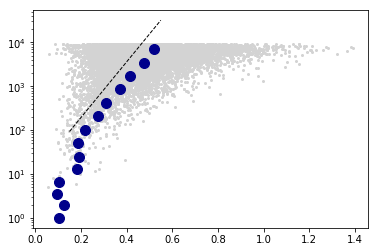

In [64]:
def func_exp(x, a, b):
    return a * np.exp(b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(b) * ( np.log(x) - np.log(a) )



brevity0 = brevity0.sort_values("repetitions", ascending=False)
brevity0["rank"] = range(1,len(brevity0)+1)

f, ax = plt.subplots()
ax.plot(brevity0.duration, brevity0["rank"], "o", ms=2, color="lightgray")


freq0, pos0 = binear_datos(brevity0["rank"], brevity0.duration, bins=14, log = True)

#ax.plot(brevity0.duration, brevity0.repetitions, 'o', lw = 1, ms = 1, zorder=2, alpha=0.6, color = 'lightgray',fillstyle= "none")
ax.plot(pos0, freq0, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")



## FITING
x = brevity0["rank"]
y = brevity0.duration

xplot = np.linspace(0.15, 0.55, 8)
popt, pcov = curve_fit(func_log, x, y)
ax.plot(xplot, 3*func_exp(xplot, *popt), "--", color = "k", lw = 1)


print(popt)

#freq0, pos0, _ = binear_datos(brevity0.repetitions, brevity0.duration, bins=28, log = True)

#ax.plot(brevity0.duration, brevity0.repetitions, 'o', lw = 1, ms = 1, zorder=2, alpha=0.6, color = 'lightgray',fillstyle= "none")
#ax.plot(pos0, freq0, 'o', lw = 2, ms = 10, label= 'words', zorder=2, alpha=1, color="darkblue")

#ax.set_xlabel(r"$<duration> (s)$", fontsize=13)
#ax.set_ylabel("Frequency", fontsize=13)
ax.set_yscale("log")
#ax.set_xscale("log")
#ax.set_xlim([0,0.7])
#ax.set_ylim([0.5,5*10**4])


In [105]:

################################################################################
# VERSION ANTERIOR############################################################
#from scipy.optimize import curve_fit
#def func(xx, a, alpha):
#    return(a - alpha*xx)

#########################################
# EXPONENTIAL #########################
#xdata = np.log(brevity.index.values)
#ydata = brevity.values
# initial guess for curve fit coefficients
#a0 = 0.5
#alpha0 = 2

# coefficients and curve fit for curve
#popt4, pcov4 = curve_fit(func, xdata, ydata, p0=(a0, alpha0))
#a, alpha = popt4
#v_fit_exp = func(xdata, a, alpha)

#residuals = ydata - func(xdata, a, alpha)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared = 1 - (ss_res / ss_tot)
#print("R2: " + str(r_squared))

################################################
# POWER LAW ####################################
#xdata = np.log(brevity.index.values)
#ydata = np.log(brevity.values)
# initial guess for curve fit coefficients
#a0 = 0.5
#alpha0 = 1

# coefficients and curve fit for curve
#popt4, pcov4 = curve_fit(func, xdata, ydata, p0=(a0, alpha0))
#a, alpha = popt4
#v_fit_pow = np.exp(func(xdata, a, alpha))

#residuals = ydata - func(xdata, a, alpha)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared = 1 - (ss_res / ss_tot)
#print("R2: " + str(r_squared))


#f, ax = plt.subplots()
#ax.plot(brevity.index, brevity.values, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=0.8)
#ax.plot(brevity.index, v_fit_exp, '-', lw = 2, ms = 7, label= 'exponential fit R2=0.56', zorder=2, alpha=0.8)
#ax.plot(brevity.index, v_fit_pow, '-', lw = 2, ms = 7, label= 'power law fit R2=0.54', zorder=2, alpha=0.8)

#ax.set_ylabel("mean duration" + r"$<t> (s)$")
#ax.set_xlabel("Frecuency of ocurrence")
#ax.legend()
#ax.set_xscale("log")

#f.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words_seconds.pdf")


In [ ]:
#brevity = lista_words.groupby("repetitions").dur_characteres.mean()


#from scipy.optimize import curve_fit
#def func(xx, a, alpha):
#    return(a - alpha*xx)

#########################################
# EXPONENTIAL #########################
#xdata = np.log(brevity.index.values)
#ydata = brevity.values
# initial guess for curve fit coefficients
#a0 = 0.5
#alpha0 = 2

# coefficients and curve fit for curve
#popt4, pcov4 = curve_fit(func, xdata, ydata, p0=(a0, alpha0))
#a, alpha = popt4
#v_fit_exp = func(xdata, a, alpha)

#residuals = ydata - func(xdata, a, alpha)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared = 1 - (ss_res / ss_tot)
#print("R2: " + str(r_squared))

################################################
# POWER LAW ####################################
#xdata = np.log(brevity.index.values)
#ydata = np.log(brevity.values)
# initial guess for curve fit coefficients
#a0 = 0.5
#alpha0 = 1

# coefficients and curve fit for curve
#popt4, pcov4 = curve_fit(func, xdata, ydata, p0=(a0, alpha0))
#a, alpha = popt4
#v_fit_pow = np.exp(func(xdata, a, alpha))

#residuals = ydata - func(xdata, a, alpha)
#ss_res = np.sum(residuals**2)
#ss_tot = np.sum((ydata-np.mean(ydata))**2)
#r_squared = 1 - (ss_res / ss_tot)
#print("R2: " + str(r_squared))




#f, ax = plt.subplots()
#ax.plot(brevity.index, brevity.values, 'o', lw = 2, ms = 7, label= 'words', zorder=2, alpha=0.8)
#ax.plot(brevity.index, v_fit_exp, '-', lw = 2, ms = 7, label= 'exponential fit R2=0.33', zorder=2, alpha=0.8)
#ax.plot(brevity.index, v_fit_pow, '-', lw = 2, ms = 7, label= 'power law fit R2=0.35', zorder=2, alpha=0.8)

#ax.set_ylabel("mean duration " + r"$(characters)$")
#ax.set_xlabel("Frecuency of ocurrence (n)")
#ax.legend()
#ax.set_xscale("log")

#f.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_words_characters.pdf")

#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis

#import scipy.stats
#scipy.stats.spearmanr(brevity.index.values, brevity.values)

# 4.2 Brevity law  Phonemes

In [70]:
tabla_datos_brev = tabla_datos.copy()
#tabla_datos_brev = tabla_datos_brev.assign(numletterPhon=tabla_datos_brev[tabla_datos_brev.tipe=="w"].numletters/tabla_datos_brev[tabla_datos_brev.tipe=="w"].numphonemes)
#tabla_datos_brev.fillna(method='ffill', inplace=True)

lista_fonemabrev = tabla_datos_brev[((tabla_datos_brev.tipe == 'p') & (tabla_datos_brev.token != 'SIL') & (tabla_datos_brev.token != 'VOCNOISE') 
                            & (tabla_datos_brev.token != 'UNKNOWN') & (tabla_datos_brev.token != 'NOISE') & (tabla_datos_brev.token != 'LAUGH')
                            & (tabla_datos_brev.token != 'IVER')
                            & (tabla_datos_brev.token.str.endswith("}") == False) & (tabla_datos_brev.token.str.startswith("{") == False))]

lista_fonemabrev = lista_fonemabrev.assign(repetitions=lista_fonemabrev.token.map(lista_fonemabrev.token.value_counts()))

57
Frequencia phonemes vs duracion(segundos:
SpearmanrResult(correlation=-0.4845735027223231, pvalue=0.0001336503981325234)


Frequencia phonemes vs duracion(segundos) si >50:
SpearmanrResult(correlation=-0.4845735027223231, pvalue=0.0001336503981325234)


R2: 0.2728895421533296



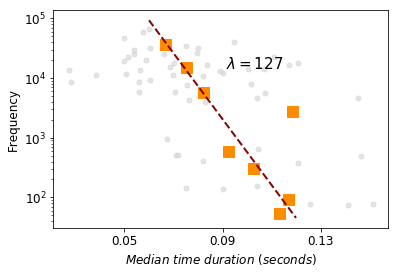

In [71]:
brevityp = lista_fonemabrev.groupby("token").median()[["duration", "repetitions"]]
brevityp = brevityp[brevityp.repetitions>50]
brevityp2 = brevityp[brevityp.repetitions>50]

print(len(brevityp))
#The two-sided p-value for a hypothesis test whose null hypothesis is that two sets of data are uncorrelated, 
#A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis
print("Frequencia phonemes vs duracion(segundos:")
print(scipy.stats.spearmanr(brevityp.repetitions, brevityp.duration))
print()
print()

print("Frequencia phonemes vs duracion(segundos) si >50:")
print(scipy.stats.spearmanr(brevityp2.repetitions, brevityp2.duration))
print()
print()

### AHORA VAMOS A HACER UN BINING
freq, pos = binear_datos(brevityp.repetitions, brevityp.duration, bins=8, log = True)

f, ax1 = plt.subplots()
ax1.plot(brevityp.duration, brevityp.repetitions, 'o', lw = 1, ms = 5, zorder=2, alpha=0.6, color = 'lightgrey')
ax1.plot(pos, freq, 's', lw = 2, ms = 11, label= 'phonemes', zorder=2, alpha=1, color = 'darkorange')

ax1.set_xlabel(r"$Median$"  + " " + r"$time$"  + " " + r"$ duration$"  + " " + r"$ (seconds)$", fontsize=12)
#ax.legend()
ax1.set_yscale("log")

ax1.set_ylabel("Frequency", fontsize=12)
#ax1.legend(frameon=False)


ax1.set_xticks([0.05, 0.09, 0.13])



#######################################################################################
def func_exp(x, a, b):
    return a * np.exp(-b * x)

def func_log(x, a, b): # FUNCION LOGARITMICA que utiliza los mismos parametros
    return 1/(-b) * ( np.log(x) - np.log(a) )

## FITING
x = brevityp2.repetitions
y = brevityp2.duration

xplot = np.linspace(0.06, 0.12, 3)
popt, pcov = curve_fit(func_log, x, y)
ax1.plot(xplot, func_exp(xplot, *popt), "--", color = "darkred", lw = 2)

ax1.text(0.6, 0.8, r'$\lambda = $' + "{:.{}f}".format(popt[1], 0), horizontalalignment='center', fontsize = 15, verticalalignment='center', transform=ax.transAxes)




residuals = y - func_log(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R2: " + str(r_squared))
print()




ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)





f.savefig("resultados/Buckeye/1_LeyesLinguisticas/3_Brevity_phonemes.pdf")


# 5. Heaps Law
Para heap law, leemos secuencialmente las conversaciones para ver como aumenta el vocabulario en funcion del tiempo transcurrido o del numero de palabras transcurridas




In [7]:
# Primero añadimos una columna de zeros
lista_words['first_time_token'] = 0 
first_ocurrences =  lista_words.drop_duplicates(subset=["token"]).index
lista_words.loc[first_ocurrences, "first_time_token"] = 1


# Creamos el fichero de tiempos
total_time = 0
lista_tiempo_transcurrido = []
path = list(lista_words[0:1].path)[0]

for index, row in lista_words.iterrows():
    if path != row.path:
        total_time += previoustime # Guarda
        path = row.path
    previoustime = row.tinit
    lista_tiempo_transcurrido.append(total_time+row.tinit)

xheapt = lista_tiempo_transcurrido
yheapt = lista_words.first_time_token.cumsum()



In [8]:
# decimate logaritmic
decimation = np.logspace(0, np.log10(len(xheapt)-1),100, dtype="int")
decimation = np.asarray([0] + list(decimation))

xheapt = np.asarray(xheapt) - xheapt[1] - 0.2
xheaptdecimate = pd.DataFrame(xheapt).loc[decimation, :]
xheaptdecimate = xheaptdecimate[0].values

yheaptdecimate = pd.DataFrame(list(yheapt)).loc[decimation, :]
yheaptdecimate = yheaptdecimate[0].values

xheapL = pd.DataFrame(lista_words.numtoken.values).loc[decimation, :]
xheapL = xheapL[0].values



In [9]:
# Heaps corpus escrito
xheapL = pd.DataFrame(lista_words.numtoken.values).loc[decimation, :]
xheapL = xheapL[0].values

yheapL = pd.DataFrame(list(yheapt)).loc[decimation, :]
yheapL = yheapL[0].values


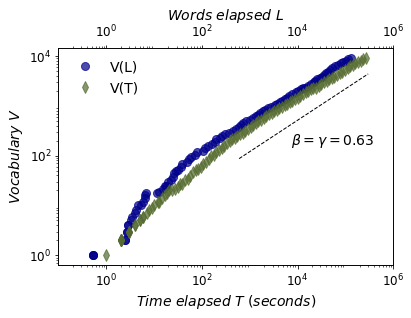

In [10]:
# FIGURA HEAPS
f, ax = plt.subplots()

# MAIN PLOT
lns1 = ax.plot(xheaptdecimate, yheaptdecimate -2 , 'o', lw = 2, ms = 8, label= 'V(L)', zorder=2, alpha=0.7, color="darkblue")

xline = np.array([0.6*10**3, 3*10**5])
ax.text(0.82, 0.57, r'$\beta = \gamma = 0.63$', horizontalalignment='center', fontsize = 14, verticalalignment='center', transform=ax.transAxes)
ax.plot(xline, np.power(2*10**0*xline, 0.63), "--", color = "k", lw=1)


ax.set_xlim([10**-1, 10**6])

ax.set_xlabel(r"$Time$" +" " + r"$elapsed$" +" " + r"$T$"+ " " + r"$(seconds)$", fontsize=14)
ax.set_ylabel( r"$Vocabulary$" + " " +  r"$V$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")


ax2 = ax.twiny()
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim([10**-1, 10**6])


lns2 = ax2.plot(xheapL, yheaptdecimate, 'd', lw = 2, ms = 8, label= 'V(T)', zorder=5, alpha=0.7, color = "darkolivegreen")
ax2.set_xlabel(r"$Words$" +" " + r"$elapsed$" + " " + r"$L$", fontsize=14)



# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=2, frameon = False, fontsize = 14)


ax.set_xticks([10**0,10**2, 10**4, 10**6])
ax2.set_xticks([10**0,10**2, 10**4, 10**6])
ax.set_yticks([10**0,10**2, 10**4])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='x', labelsize=12)



f.savefig("resultados/Buckeye/1_LeyesLinguisticas/4_HeapLaw.pdf")


### Figura tesis Heap

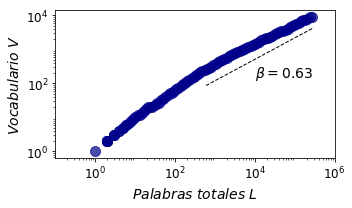

In [12]:
# FIGURA HEAPS
f, ax = plt.subplots(figsize=[5,3])

# MAIN PLOT
lns1 = ax.plot(xheapL, yheaptdecimate , 'o', lw = 2, ms = 10, label= 'V(L)', zorder=2, alpha=0.7, color="darkblue")

xline = np.array([0.6*10**3, 3*10**5])
ax.text(0.82, 0.57, r'$\beta = 0.63$', horizontalalignment='center', fontsize = 14, verticalalignment='center', transform=ax.transAxes)
ax.plot(xline, np.power(2*10**0*xline, 0.63), "--", color = "k", lw=1)


ax.set_xlim([10**-1, 10**6])

ax.set_xlabel(r"$Time$" +" " + r"$elapsed$" +" " + r"$T$"+ " " + r"$(seconds)$", fontsize=14)
ax.set_ylabel( r"$Vocabulario$" + " " +  r"$V$", fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")


#ax2 = ax.twiny()


#lns2 = ax2.plot(xheapL, yheaptdecimate, 'd', lw = 2, ms = 8, label= 'V(T)', zorder=5, alpha=0.7, color = "darkolivegreen")
ax.set_xlabel(r"$Palabras$" +" " + r"$totales$" + " " + r"$L$", fontsize=14)



# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
#ax.legend(lns, labs, loc=2, frameon = False, fontsize = 14)


ax.set_xticks([10**0,10**2, 10**4, 10**6])
#ax2.set_xticks([10**0,10**2, 10**4, 10**6])
ax.set_yticks([10**0,10**2, 10**4])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


#ax2.tick_params(axis='x', labelsize=12)


f.tight_layout()
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/tesis_heap_teoria.pdf")


(array([ 0.63566876,  5.32785682, 83.69201891]), array([[ 9.55082746e-05, -5.93305949e-03,  3.02489223e-01],
       [-5.93305949e-03,  3.69579058e-01, -1.92662897e+01],
       [ 3.02489223e-01, -1.92662897e+01,  1.40271302e+03]]))
exponente = 0.6356687557681817


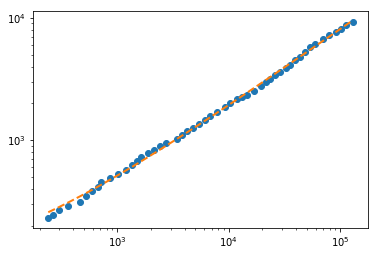

In [76]:
####################################################################
# FITTED DATA #######################################################
####################################################################
from scipy.optimize import curve_fit
def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

f, ax = plt.subplots()


x = xheaptdecimate[50::]
y = yheaptdecimate[50::]
ax.plot(x, y, "o")
ax.set_xscale("log")
ax.set_yscale("log")

sol2 = curve_fit(func_powerlaw, x, y)
print(sol2)
expy = func_powerlaw(x, sol2[0][0], sol2[0][1], sol2[0][2])
ax.plot(x, expy, "--", lw=2)
print("exponente = " + str(sol2[0][0]))


# 5.1 Speech Rate
Calcular el numero de palabras por minuto y como converge

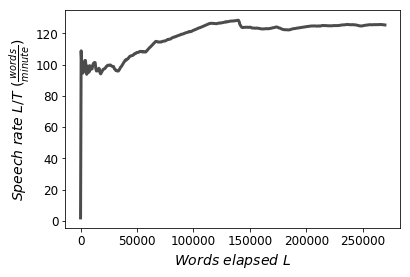

In [94]:
palabras_transcurridas = lista_words.numtoken.values
tiempo = np.asarray(lista_tiempo_transcurrido)
tiempo_minutos = tiempo/60

speech_rate = palabras_transcurridas/tiempo_minutos



# FIGURA HEAPS
f, ax = plt.subplots()

# MAIN PLOT
# decimate logaritmic
decimation = list(np.linspace(0, len(palabras_transcurridas)-1, 500, dtype="int"))


ax.plot(palabras_transcurridas[decimation], speech_rate[decimation] , '-', lw = 3, ms = 2, label= 'Speech Rate', zorder=2, alpha=0.7, color="black")




ax.set_xlabel(r"$Words$" +" " + r"$elapsed$" + " " + r"$L$", fontsize=14)
ax.set_ylabel(r"$Speech$" +" " + r"$rate$" + " " + r"$L/T$"+ " " + r"$(\frac{words}{minute})$", fontsize=14)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI_SpeechRate.pdf")


# 6. Menzerath Altmann law

 Existen divesas posibles definiciones de Menzerath Altmann law. Por ello vamos a intentar varias y comaprarlas

## 6.1 Sentences length (number of words) VS words length (number of letters)

In [172]:
SentenceSize_numwords = []
WordsSize_numletters = []
WordsSize_numphonemes = []  # Para la definicion2
WordsSize_seconds = []  # Para la definicion3



for sentence in tabla_datos.sentence.unique():
    tablaSentence = tabla_datos[tabla_datos.sentence == sentence]
    numwords = len(tablaSentence[tablaSentence.tipe == "w"])
    if numwords == 100:
        stop
    SentenceSize_numwords.append(numwords)

    numletters_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].numletters)
    WordsSize_numletters.append(numletters_mean)
    
    # Para la definicion2
    numphonemes_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].numphonemes)
    WordsSize_numphonemes.append(numphonemes_mean)
    
    # Para la definicion3
    word_duration_mean = np.mean(tablaSentence[tablaSentence.tipe == "w"].duration)
    WordsSize_seconds.append(word_duration_mean)

    
    


Power law exponential seconds:
exponentes = [ 0.36276846 -0.22164689 -0.00606802]
R2:0.9443306688188625

Power law exponential chars:
exponentes = [ 4.13644677e+00 -1.59687065e-02 -1.76141528e-04]
R2:0.3356302938000202

Power law exponential phonemes:
exponentes = [ 3.10710031e+00 -1.78455457e-02  5.89109283e-04]
R2:0.6681865083130303



/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Power law exponential seconds:
exponentes = [ 0.36276846 -0.22164689 -0.00606802]
R2:0.9443306688188625

Power law exponential chars:
exponentes = [ 4.13644677e+00 -1.59687065e-02 -1.76141528e-04]
R2:0.3356302938000202

Power law exponential phonemes:
exponentes = [ 3.10710031e+00 -1.78455457e-02  5.89109283e-04]
R2:0.6681865083130303

Power law exponential seconds:
exponentes = [ 0.36399759 -0.22732463 -0.00671789]
R2:0.7043809864063424

Power law exponential chars:
exponentes = [ 4.15976916e+00 -2.14392455e-02 -7.40885298e-04]
R2:0.053476206466434584

Power law exponential phonemes:
exponentes = [ 3.22044369e+00 -4.69145729e-02 -1.85744879e-03]
R2:0.048931720314466354

Power law exponential seconds:
exponentes = [ 0.36399759 -0.22732463 -0.00671789]
R2:0.7043809864063424

Power law exponential chars:
exponentes = [ 4.15976916e+00 -2.14392455e-02 -7.40885298e-04]
R2:0.053476206466434584

Power law exponential phonemes:
exponentes = [ 3.22044369e+00 -4.69145729e-02 -1.85744879e-03]
R2:

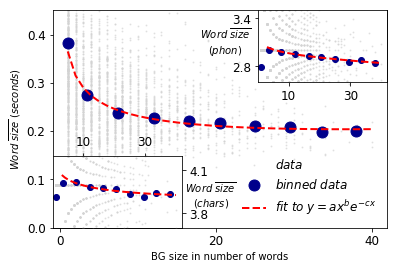

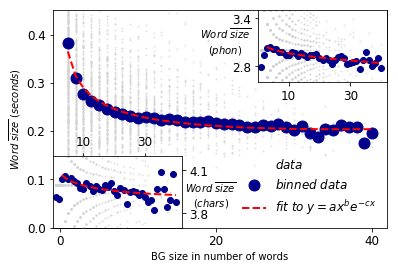

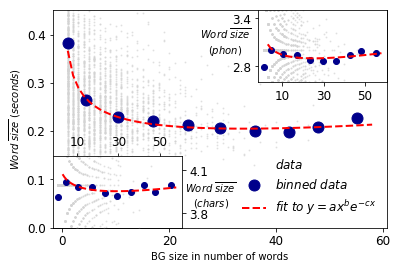

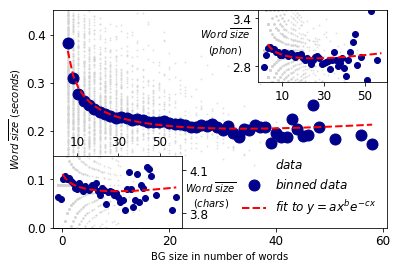

In [173]:
from scipy.optimize import curve_fit
def func_powerlawexp(x, alfa, beta, c):
    return alfa * x**(beta) * np.exp(-c*x)

# def func_powerlawexp(x, beta):
#     #c = b/6
#     #0.4 = a*e^(-b/6)
    
#     return (0.4/(np.exp(-beta/6)) * x**(-beta) * np.exp(-beta/6*x))

numbins= 10

for setsize in [41,80]:
    for bin15 in [True, False]:
    
        # FIGURA MENZERATH
        f, ax = plt.subplots()

        ###########################################################################
        # MENZERATH FRSES WORDS (SECONDS) #########################################
        #########################################################################################################

        Mentable_sec = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_seconds})
        Mentable_sec1 = Mentable_sec[ Mentable_sec["SentSize"]<setsize]

        azul = Mentable_sec1.groupby("SentSize").mean()
        pos0 = azul.index.values
        freq0 = azul.WordsSize.values
        pos015, freq015 = binear_datos(pos0, freq0, bins=numbins, log = False)


        # MAIN PLOT
        #ax.plot(Mentable_sec.SentSize.values, Mentable_sec.WordsSize.values , 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        ax.plot(Mentable_sec1.SentSize.values[0:3000], Mentable_sec1.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey', label = r"$data$")
        if bin15 == False:
            ax.plot(pos0, freq0, 'o', lw = 2, ms = 11, zorder=2, alpha=1, color = "darkblue", label = r"$binned$" + " " + r"$data$")
        elif bin15 == True:
            ax.plot(pos015, freq015, 'o', lw = 2, ms = 11, zorder=2, alpha=1, color = "darkblue", label = r"$binned$" + " " + r"$data$")

        ax.set_xlabel("BG size in number of words")
        ax.set_ylabel(r"$Word$" + " " + r"$\overline{size}$" + " " + r"$(seconds)$")

        ax.set_ylim([0.0, 0.45])

        ax.set_xticks([0, 20, 40, 60])
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])


        x = np.asarray(pos0)
        y = np.asarray(freq0)


        # POWER LAW EXPONENTIAL
        print("Power law exponential seconds:")
        #popt, pcov = curve_fit(func_powerlawexp, x, y)
        popt, pcov = curve_fit(func_powerlawexp, pos0, freq0)

        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        ax.plot(x, expy, "--", lw=2, color="red", label = r"$fit$" + " " + r"$to$" + " " + r"$y = ax^b e^{-cx}$")

        velocityx = x
        velocityy = 1/expy

        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        # residuals = y - func_powerlawexp(x, popt[0])

        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")

        ax.legend(frameon = False, loc = 4, fontsize=12)

        #ax.set_xlim([0, 40])


        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        # NUM LETTERS ############################################################################
        Mentableletters = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_numletters})
        Mentableletters1 = Mentableletters[ Mentableletters["SentSize"]<setsize]
        #Menzerathletters = Mentableletters.groupby("SentSize").mean()

        subax = plt.axes([ax.get_position().x0, ax.get_position().y0, .30, .25])

        #pos1, freq1 = binear_datos(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values, bins=15, log = False)
        azul = Mentableletters1.groupby("SentSize").mean()
        pos1 = azul.index.values
        freq1 = azul.WordsSize.values
        
        pos115, freq115 = binear_datos(pos1, freq1, bins=numbins, log = False)



        # MAIN PLOT
        #subax.plot(Mentableletters.SentSize.values, Mentableletters.WordsSize.values , 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        #subax.plot(Menzerathletters, 'o', lw = 2, ms = 2, label= 'seconds', zorder=2, alpha=1, color = "gray")
        subax.plot(Mentableletters.SentSize.values[0:3000], Mentableletters.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')

        
        if bin15 == False:
            subax.plot(pos1, freq1, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        elif bin15 == True:
            subax.plot(pos115, freq115, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        
        

        #subax.set_xlabel("BG (words)")
        subax.set_ylabel( r"$Word$" + " " + r"$\overline{size}$" + "\n" + r"$(chars)$", rotation = 0)
        subax.yaxis.set_label_coords(1.22, 0.65)


        subax.yaxis.set_label_position("right")
        subax.yaxis.set_ticks_position("right")

        #subax2.set_ylabel("freq",rotation=0)
        subax.xaxis.set_label_position("top")
        subax.xaxis.set_ticks_position("top")
        subax.set_ylim([3.7, 4.2])

        subax.set_yticks([3.8, 4.1])
        subax.set_xticks([10, 30, 50])
        #subax.set_xlim([0, 40])


        x = np.asarray(pos1)[2::]
        y = np.asarray(freq1)[2::]



        subax.tick_params(axis='x', labelsize=12)
        subax.tick_params(axis='y', labelsize=12)

        # POWER LAW EXPONENTIAL
        print("Power law exponential chars:")
        popt, pcov = curve_fit(func_powerlawexp, x, y)
        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        subax.plot(x, expy, "--", lw=2, color="red")
        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")


        #################################################################################
        # Sentences length (number of words) VS words length (number of phonemes)
        #############################################################################

        # Ploteamos
        subax2 = plt.axes([ax.get_position().x1 - .30, ax.get_position().y1 - .25, .30, .25])

        Mentable = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_numphonemes})
        Mentable1 = Mentable[Mentable.SentSize<setsize]
        #Menzerathphonemes = Mentable.groupby("SentSize").mean()


        #pos2, freq2 = binear_datos(Mentable1.SentSize.values, Mentable1.WordsSize.values, bins=15, log = False)
        azul = Mentable1.groupby("SentSize").mean()
        pos2 = azul.index.values
        freq2 = azul.WordsSize.values
        pos215, freq215 = binear_datos(pos2, freq2, bins=numbins, log = False)


        # MAIN PLOT
        #subax2.plot(Menzerath, 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
        subax2.plot(Mentable.SentSize.values[0:3000], Mentable.WordsSize.values[0:3000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')
        if bin15 == False:
            subax2.plot(pos2, freq2, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        elif bin15 == True:
            subax2.plot(pos215, freq215, 'o', lw = 2, ms = 6, zorder=2, alpha=1, color = "darkblue")
        
        
        #subax2.set_xlabel(r"$BG (words)$")
        subax2.set_ylabel(r"$Word$" + " " + r"$\overline{size}$" + "\n" + r"$(phon)$", rotation = 0)
        subax2.yaxis.set_label_coords(-0.25, 0.35)

        subax2.set_xticks([10, 30, 50])
        subax2.set_yticks([2.8, 3.4])
        subax2.set_ylim([2.6,3.5])
        #subax2.set_xlim([0, 40])



        subax2.tick_params(axis='x', labelsize=12)
        subax2.tick_params(axis='y', labelsize=12)




        x = np.asarray(pos2)[2::]
        y = np.asarray(freq2)[2::]


        # POWER LAW EXPONENTIAL
        print("Power law exponential phonemes:")
        popt, pcov = curve_fit(func_powerlawexp, x, y)
        expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
        subax2.plot(x, expy, "--", lw=2, color="red")
        print("exponentes = " + str(popt))

        # GET R2
        residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        R2 = 1 - (ss_res / ss_tot)
        print("R2:" + str(R2))
        print("")

        if setsize == 80:
            if bin15 == False:
                f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath_BG_WORDS_allBG.pdf")
            elif bin15 == True:
                f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath_BG_WORDS_allBG_bin15.pdf")
        elif setsize == 41:
            subax.set_xticks([10, 30])
            subax2.set_xticks([10, 30])
            subax2.set_xlim([0, 42])
            subax.set_xlim([0, 42])
            
            if bin15 == False:
                f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath_BG_WORDS_less41.pdf")
            elif bin15 == True:
                f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath_BG_WORDS_less41_bin15.pdf")




### Figura tesis Menzerath


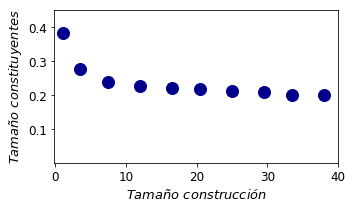

In [204]:
numbins= 10
setsize = 41
bin15 = True

# FIGURA MENZERATH
f, ax = plt.subplots(figsize=[5,3])

###########################################################################
# MENZERATH FRSES WORDS (SECONDS) #########################################
#########################################################################################################

Mentable_sec = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_seconds})
Mentable_sec1 = Mentable_sec[ Mentable_sec["SentSize"]<setsize]

azul = Mentable_sec1.groupby("SentSize").mean()
pos0 = azul.index.values
freq0 = azul.WordsSize.values
pos015, freq015 = binear_datos(pos0, freq0, bins=numbins, log = False)

ax.plot(pos015, freq015, 'o', lw = 2, ms = 12, color = "darkblue", label = r"$binned$" + " " + r"$data$")

ax.set_xlabel(r"$Tamaño \ construcción$", fontsize = 13)
ax.set_ylabel(r"$Tamaño \ constituyentes$", fontsize = 13)

ax.set_ylim([0.0, 0.45])

ax.set_xticks([0, 10, 20, 30, 40])
ax.set_yticks([0.1, 0.2, 0.3, 0.4])

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.set_xlim([-0.2, 40])
f.tight_layout()
f.savefig("resultados/Buckeye/1_LeyesLinguisticas/Tesis_Menzerath.pdf")





# Datos para la figura Velocidad MAL (Lucas)


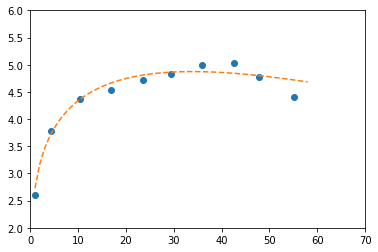

In [31]:
pos1, freq1 = binear_datos(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values, bins=15, log = False)



speechVelocity = 1/freq015
BGsize = pos015

f, ax = plt.subplots()
ax.plot(BGsize, speechVelocity, 'o')
ax.plot(velocityx, velocityy, '--')
ax.set_ylim([2,6])
ax.set_xlim([0,70])
dfvelocity = pd.DataFrame({"BGsize":BGsize, "Velocity":speechVelocity})
dfvelocity.to_csv("resultados/Buckeye/1_LeyesLinguisticas/puntosFiguraVelocity.txt", index=False)



## Todos los posibles ajustes de MAL

In [82]:
def func_powerlawexp(x, alfa, beta, c):
    return alfa * x**(beta) * np.exp(-c*x)


def adjust_powerlawexp(xdata, ydata):
    popt, pcov = curve_fit(func_powerlawexp, xdata, ydata)
    expy = func_powerlawexp(xdata, popt[0], popt[1], popt[2])

    # GET R2
    residuals = ydata - func_powerlawexp(xdata, popt[0], popt[1], popt[2])
    # residuals = y - func_powerlawexp(x, popt[0])

    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.mean(ydata))**2)
    R2 = 1 - (ss_res / ss_tot)
    print("a|b|c| b/c = " + str(popt[0].round(2)) + " | " + str(popt[1].round(4)) +" | "+  str(popt[2].round(5))+" | "+  str((popt[1]/popt[2]).round()) + "  R2: " + str(R2.round(2)))
    print("")


# ALL DATA BIN AZUL
print("###### ALL DATA AZUL ############################")
azul = Mentable_sec.groupby("SentSize").mean()
print("BG seconds  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentable[Mentable.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 phonemes  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

azul = Mentable.groupby("SentSize").mean()
print("BG phonemes  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentableletters[Mentableletters.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

azul = Mentableletters.groupby("SentSize").mean()
print("BG letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)




# ALL DATA BIN AZUL
print("###### DATA AZUL < 40 ############################")

Mentable_sec1 = Mentable_sec[Mentable_sec.SentSize<40]
azul = Mentable_sec1.groupby("SentSize").mean()
print("BG seconds  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


Mentable1 = Mentable[Mentable.SentSize<40]
Mentable1 = Mentable1[Mentable1.SentSize>2]
azul = Mentable1.groupby("SentSize").mean()
print("BG>2 phonees  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)

Mentable1 = Mentable[Mentable.SentSize<40]
azul = Mentable1.groupby("SentSize").mean()
print("BG phonees  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)



Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
Mentableletters1 = Mentableletters1[Mentableletters1.SentSize>2]
azul = Mentableletters1.groupby("SentSize").mean()
print("BG>2 letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
azul = Mentableletters1.groupby("SentSize").mean()
print("BG letters  ")
adjust_powerlawexp(azul.index.values, azul.WordsSize.values)


# ALL DATA GRIS
print("###### ALL DATA GRIS ############################")
print("BG seconds  ")
adjust_powerlawexp(Mentable_sec.SentSize.values, Mentable_sec.WordsSize.values)

print("BG >2 phonemes  ")
Mentable1 = Mentable[Mentable.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG phonemes  ")
adjust_powerlawexp(Mentable.SentSize.values, Mentable.WordsSize.values)

print("BG letters >2 ")
Mentable1 = Mentableletters[Mentableletters.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG letters  ")
adjust_powerlawexp(Mentableletters.SentSize.values, Mentableletters.WordsSize.values)


# DATA < 40 GRIS
print("###### DATA GRIS < 40 ############################")
print("BG seconds  ")
Mentable_sec1 = Mentable_sec[Mentable_sec.SentSize<40]
adjust_powerlawexp(Mentable_sec1.SentSize.values, Mentable_sec1.WordsSize.values)

print("BG>2 phonemes  ")
Mentable1 = Mentable[Mentable.SentSize<40]
Mentable1 = Mentable1[Mentable1.SentSize>2]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG phonemes  ")
Mentable1 = Mentable[Mentable.SentSize<40]
adjust_powerlawexp(Mentable1.SentSize.values, Mentable1.WordsSize.values)

print("BG >2 letters  ")
Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
Mentableletters1 = Mentableletters1[Mentableletters1.SentSize>2]
adjust_powerlawexp(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values)


print("BG letters  ")
Mentableletters1 = Mentableletters[Mentableletters.SentSize<40]
adjust_powerlawexp(Mentableletters1.SentSize.values, Mentableletters1.WordsSize.values)


###### ALL DATA AZUL ############################
BG seconds  
a|b|c| b/c = 0.36 | -0.2273 | -0.00672 | 34.0  R2: 0.7

BG>2 phonemes  
a|b|c| b/c = 3.22 | -0.0469 | -0.00186 | 25.0  R2: 0.05

BG phonemes  
a|b|c| b/c = 2.97 | -0.0068 | -0.0002 | 34.0  R2: 0.0

BG>2 letters  
a|b|c| b/c = 4.16 | -0.0214 | -0.00074 | 29.0  R2: 0.05

BG letters  
a|b|c| b/c = 3.99 | -0.0009 | 0.0001 | -9.0  R2: 0.01

###### DATA AZUL < 40 ############################
BG seconds  
a|b|c| b/c = 0.36 | -0.2241 | -0.00639 | 35.0  R2: 0.94

BG>2 phonees  
a|b|c| b/c = 3.12 | -0.0217 | 0.00027 | -82.0  R2: 0.66

BG phonees  
a|b|c| b/c = 2.91 | 0.0182 | 0.00249 | 7.0  R2: 0.46

BG>2 letters  
a|b|c| b/c = 4.15 | -0.0183 | -0.00037 | 50.0  R2: 0.32

BG letters  
a|b|c| b/c = 3.97 | 0.0073 | 0.00102 | 7.0  R2: 0.17

###### ALL DATA GRIS ############################
BG seconds  
a|b|c| b/c = 0.37 | -0.2933 | -0.01667 | 18.0  R2: 0.12

BG >2 phonemes  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


a|b|c| b/c = 3.1 | -0.0152 | 0.00083 | -18.0  R2: 0.0

BG phonemes  
a|b|c| b/c = 2.85 | 0.057 | 0.00769 | 7.0  R2: 0.01

BG letters >2 
a|b|c| b/c = 4.1 | -0.0078 | 0.00054 | -14.0  R2: 0.0

BG letters  
a|b|c| b/c = 3.92 | 0.0253 | 0.00335 | 8.0  R2: 0.0

###### DATA GRIS < 40 ############################
BG seconds  
a|b|c| b/c = 0.37 | -0.2961 | -0.01736 | 17.0  R2: 0.12

BG>2 phonemes  
a|b|c| b/c = 3.09 | -0.0141 | 0.00096 | -15.0  R2: 0.0

BG phonemes  
a|b|c| b/c = 2.84 | 0.0585 | 0.00802 | 7.0  R2: 0.01

BG >2 letters  
a|b|c| b/c = 4.09 | -0.0067 | 0.00068 | -10.0  R2: 0.0

BG letters  
a|b|c| b/c = 3.92 | 0.026 | 0.00352 | 7.0  R2: 0.0



## Modelo MAL equacion 9
Modelo estocastico de la ecuacion 9 del paper

In [32]:
azul = Mentable_sec1.groupby("SentSize").mean()
pos0 = azul.index.values
freq0 = azul.WordsSize.values
t1 = freq0[0]
a = 0.364
b = -0.227
c = -0.0067
k1 = t1/a
k2 = b+1

## Modelo Menzerath-Altmann-Bartolo-Lucas
Calcular para cada BG $log\frac{t(n)}{t(n-1)}$ donde n es la es la palabra en la posicicion n. t(n) es el tiempo transcurrido hasta esa palabra

In [33]:
listat1 = lista_words.groupby("sentence").first().duration.values

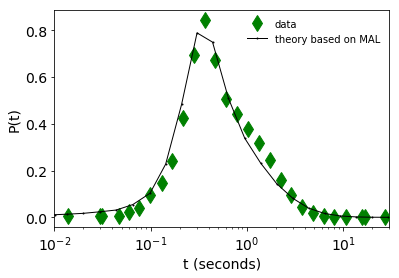

In [35]:
k1 = np.exp(-c)
k2 = b +1.3
# Numero de palabras por BG real
W_n = np.asarray(lista_words.groupby("sentence").size())

# Words durations
words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

lista_tn = []
for i in range(100000):
#     position = np.random.choice(np.arange(1, len(W_n)), 1)
#     BG_size = W_n[position]
#     tn = listat1[position]

    BG_size = np.random.choice(W_n, 1) # Tamano de la frase
    tn = t1
    tn = np.random.choice(words_durations)
    for j in range(2, int(BG_size)+1):
        tn = tn*k1*( (1 + 1/(j-1))**k2 )
#         tn = tn*k1*( (1 + k2/(j-1)) )
    tn = tn + np.random.normal(0.14, 0.08)

    lista_tn.append(tn)

############################################################
# REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)
# ACTUAL
lista_tn = np.asarray(lista_tn)
lista_tn = lista_tn[lista_tn>0]
bin_mean_x_sentence_Stocastic, _, counts_norm_sentence_Stocastic, _ = histograma(lista_tn, numero_bins=30)

# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 12, label= 'data', zorder=3, c="g")
ax.plot(bin_mean_x_sentence_Stocastic, counts_norm_sentence_Stocastic, '-o', lw = 1, ms = 1, label= 'theory based on MAL', zorder=3, c="k")
ax.legend(frameon = False)
ax.set_xscale("log")
ax.set_xlim([0.01, 30])


ax.set_xlabel("t (seconds)", fontsize=14)
ax.set_ylabel("P(t)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI_MAL_model_BGlength_noise.pdf")


7144
21432
14288
0
17860
10716
3572
21433
21434
3573
10717
7145
1
14289
17861
3574
10718
7146
2
14290
17862
21435
3575
3
14291
7147
10719
17863
21436
3576
21437
3577
7148
17864
4
14292
10720
17865
7149
5
14293
10721
21438
3578
17866
10722
7150
6
14294
21439
3579
7
17867
10723
7151
14295
7152
21440
3580
8
14296
17868
10724
7153
21441
3581
7154
14297
17869
9
21442
10725
3582
14298
10
17870
10726
7155
3583
7156
3584
21443
21444
14299
11
10727
10728
14300
12
17871
17872
3585
7157
21445
10729
13
14301
17873
3586
7158
21446
3587
7159
21447
17874
3588
10730
14302
14
7160
21448
17875
14303
10731
15
17876
14304
10732
16
3589
7161
21449
3590
17
14305
17877
21450
10733
7162
14306
3591
18
3592
10734
17878
21451
21452
7163
7164
19
3593
20
14307
10735
14308
10736
17879
17880
3594
21453
3595
10737
7165
21
14309
17881
21454
17882
10738
7166
22
21455
14310
7167
17883
10739
23
14311
7168
7169
3596
3597
7170
3598
21456
17884
21457
10740
24
14312
17885
10741
25
14313
21458
10742
17886
26
14314
7171
3599
7

10938
21651
3791
14508
14509
10939
218
18074
21652
3792
14510
3793
21653
219
10940
7362
14511
21654
3794
10941
220
221
7363
14512
21655
3795
10942
14513
10943
222
7364
18075
18076
14514
7365
21656
18077
10944
3796
223
14515
10945
21657
7366
14516
3797
21658
14517
7367
21659
3798
224
21660
21661
3799
225
18078
7368
3800
226
3801
10946
7369
18079
227
228
7370
229
7371
7372
21662
14518
18080
18081
7373
18082
18083
14519
3802
10947
7374
14520
18084
230
10948
14521
21663
10949
18085
18086
21664
10950
18087
14522
21665
18088
3803
14523
18089
7375
10951
3804
7376
231
3805
7377
14524
21666
10952
232
7378
233
21667
7379
3806
14525
18090
14526
10953
3807
234
21668
7380
10954
235
3808
21669
7381
236
3809
21670
7382
14527
18091
3810
14528
14529
14530
10955
14531
18092
237
10956
18093
10957
10958
238
10959
21671
7383
18094
3811
21672
7384
21673
18095
21674
7385
3812
14532
7386
3813
3814
18096
21675
7387
3815
10960
239
14533
18097
240
18098
241
14534
14535
242
7388
10961
243
10962
10963
7389
21676
7

4004
21865
14725
18290
18291
14726
21866
11152
4005
7580
18292
436
21867
4006
14727
18293
14728
11153
18294
437
4007
14729
11154
14730
7581
438
7582
21868
18295
14731
11155
439
4008
11156
18296
7583
21869
11157
11158
14732
440
21870
441
11159
442
7584
14733
443
7585
4009
7586
18297
4010
14734
18298
7587
11160
21871
444
11161
21872
21873
21874
445
4011
14735
11162
18299
7588
21875
446
4012
7589
18300
4013
4014
18301
18302
7590
14736
11163
4015
18303
21876
447
14737
14738
21877
14739
7591
11164
21878
4016
18304
448
14740
11165
4017
11166
18305
11167
7592
4018
449
18306
450
21879
451
11168
14741
7593
7594
7595
452
4019
18307
21880
7596
14742
11169
14743
453
21881
21882
4020
21883
18308
14744
7597
14745
11170
4021
11171
21884
4022
18309
454
455
18310
4023
14746
18311
11172
7598
7599
14747
456
4024
11173
14748
18312
14749
14750
21885
457
7600
11174
458
11175
7601
4025
459
11176
11177
11178
460
14751
7602
461
18313
462
21886
21887
7603
4026
4027
7604
7605
7606
11179
21888
4028
18314
14752
18

655
656
18501
22075
4220
657
7796
7797
7798
658
22076
22077
4221
7799
14948
4222
18502
11368
11369
7800
659
18503
11370
4223
7801
11371
18504
18505
22078
7802
11372
14949
4224
4225
4226
660
22079
11373
4227
7803
14950
11374
4228
18506
14951
11375
4229
661
18507
22080
14952
4230
7804
11376
662
14953
22081
22082
4231
14954
663
7805
11377
18508
664
7806
7807
18509
11378
665
18510
22083
7808
4232
14955
666
14956
11379
7809
7810
14957
22084
11380
22085
18511
11381
22086
22087
4233
14958
667
11382
668
22088
14959
22089
14960
22090
7811
4234
669
7812
18512
22091
18513
4235
14961
18514
7813
11383
18515
670
11384
18516
4236
671
7814
672
7815
18517
11385
22092
4237
7816
18518
4238
14962
18519
673
11386
7817
14963
11387
11388
4239
22093
4240
18520
11389
4241
674
22094
7818
14964
675
11390
22095
4242
7819
11391
18521
22096
4243
4244
22097
22098
18522
14965
676
4245
11392
7820
18523
14966
14967
18524
14968
7821
22099
22100
677
18525
14969
4246
7822
7823
18526
11393
14970
7824
4247
22101
678
7825
67

15165
4436
11586
867
15166
18714
22292
15167
18715
4437
11587
8011
11588
22293
4438
868
869
22294
18716
18717
870
18718
15168
15169
22295
8012
8013
15170
4439
871
18719
11589
8014
872
11590
22296
22297
11591
8015
8016
15171
4440
873
18720
4441
22298
874
11592
15172
875
4442
15173
11593
18721
8017
15174
876
8018
11594
4443
18722
4444
11595
22299
877
8019
15175
18723
15176
15177
878
879
8020
8021
4445
15178
11596
11597
22300
4446
8022
22301
8023
15179
18724
11598
4447
22302
880
881
18725
4448
882
22303
4449
18726
22304
8024
8025
15180
11599
4450
15181
4451
8026
15182
11600
883
11601
22305
15183
884
18727
22306
15184
885
11602
4452
4453
22307
886
8027
15185
11603
4454
15186
8028
887
8029
11604
22308
11605
18728
18729
22309
15187
8030
888
889
15188
18730
22310
8031
22311
4455
8032
8033
4456
18731
4457
11606
4458
18732
890
11607
4459
22312
22313
15189
22314
891
4460
4461
15190
8034
18733
8035
22315
18734
11608
892
893
11609
18735
11610
22316
894
4462
15191
22317
11611
18736
895
4463
8036
18

11793
4649
15382
11794
4650
18925
11795
8228
4651
1089
11796
18926
4652
1090
11797
22502
15383
4653
8229
11798
15384
8230
4654
8231
22503
11799
1091
8232
1092
4655
22504
18927
15385
18928
18929
22505
15386
1093
22506
11800
8233
8234
4656
22507
1094
11801
18930
8235
4657
22508
15387
8236
11802
11803
15388
15389
11804
4658
4659
4660
22509
18931
15390
22510
18932
1095
18933
22511
8237
1096
18934
22512
11805
4661
22513
11806
4662
15391
18935
1097
22514
15392
15393
22515
11807
4663
18936
1098
11808
4664
8238
18937
15394
15395
18938
15396
18939
18940
11809
15397
18941
22516
18942
1099
4665
1100
8239
1101
18943
22517
22518
22519
8240
22520
11810
8241
1102
15398
8242
4666
18944
15399
15400
15401
11811
22521
18945
22522
1103
11812
18946
8243
18947
4667
22523
18948
22524
8244
8245
4668
1104
11813
15402
1105
8246
15403
11814
4669
18949
15404
1106
18950
22525
4670
1107
1108
11815
18951
8247
18952
11816
1109
11817
8248
15405
22526
8249
15406
4671
11818
4672
4673
8250
18953
8251
4674
1110
8252
11819

12004
22714
4858
15591
8433
22715
4859
8434
12005
15592
1297
19141
15593
4860
22716
22717
12006
15594
15595
19142
22718
8435
22719
1298
8436
8437
19143
12007
22720
4861
1299
19144
12008
12009
19145
8438
4862
15596
1300
19146
8439
12010
1301
22721
19147
12011
1302
8440
12012
15597
4863
22722
19148
1303
15598
15599
4864
4865
1304
1305
8441
12013
4866
1306
22723
19149
4867
1307
8442
15600
22724
22725
4868
15601
8443
19150
15602
12014
22726
8444
15603
4869
1308
22727
12015
8445
8446
19151
12016
8447
19152
19153
22728
8448
12017
15604
8449
12018
4870
1309
19154
1310
19155
8450
1311
15605
4871
12019
8451
19156
15606
22729
4872
12020
15607
8452
4873
1312
15608
4874
12021
15609
15610
19157
4875
1313
22730
1314
12022
15611
4876
1315
8453
22731
12023
8454
15612
4877
8455
22732
4878
15613
4879
19158
22733
15614
1316
22734
19159
12024
4880
22735
8456
19160
1317
1318
15615
8457
22736
19161
8458
4881
19162
4882
8459
1319
12025
4883
12026
22737
1320
19163
12027
1321
1322
8460
15616
22738
15617
19164


19345
1512
8650
5075
1513
12211
1514
22920
19346
12212
15799
15800
15801
5076
15802
22921
1515
5077
12213
15803
5078
8651
8652
12214
19347
12215
12216
19348
22922
5079
5080
1516
12217
15804
19349
12218
1517
15805
12219
22923
22924
8653
8654
12220
22925
22926
12221
5081
8655
12222
5082
1518
1519
8656
19350
8657
8658
15806
15807
5083
1520
22927
19351
19352
22928
15808
5084
5085
8659
5086
19353
19354
22929
5087
12223
12224
22930
22931
22932
1521
15809
1522
12225
8660
15810
12226
22933
8661
19355
22934
19356
5088
12227
1523
22935
5089
15811
12228
19357
12229
22936
1524
12230
1525
15812
15813
19358
22937
22938
19359
19360
8662
8663
12231
8664
5090
5091
19361
1526
19362
5092
19363
1527
22939
22940
15814
1528
1529
8665
19364
12232
8666
15815
12233
1530
15816
19365
15817
5093
19366
8667
1531
5094
15818
22941
22942
1532
8668
8669
5095
15819
22943
12234
12235
15820
5096
5097
1533
22944
12236
22945
19367
19368
22946
15821
1534
1535
8670
22947
15822
8671
15823
5098
19369
8672
8673
19370
12237
1223

1724
5275
16009
23129
8856
19557
23130
12431
19558
16010
12432
23131
5276
5277
8857
8858
19559
1725
5278
1726
1727
8859
1728
5279
8860
16011
12433
23132
1729
5280
16012
1730
19560
5281
8861
12434
5282
16013
5283
23133
23134
12435
16014
1731
5284
19561
19562
23135
16015
5285
8862
12436
1732
5286
19563
8863
16016
23136
12437
23137
19564
19565
12438
16017
5287
16018
8864
23138
1733
5288
8865
1734
19566
1735
23139
8866
16019
23140
1736
19567
16020
12439
19568
1737
23141
5289
12440
1738
19569
23142
16021
8867
23143
16022
19570
16023
8868
23144
19571
12441
5290
23145
19572
23146
12442
16024
5291
1739
19573
12443
19574
16025
1740
5292
12444
23147
16026
8869
23148
5293
12445
19575
8870
1741
5294
8871
12446
19576
1742
16027
8872
16028
8873
23149
19577
8874
1743
5295
12447
16029
1744
5296
8875
1745
12448
16030
8876
23150
23151
19578
23152
19579
23153
1746
23154
5297
19580
12449
16031
8877
12450
5298
19581
12451
19582
8878
16032
5299
8879
16033
5300
1747
12452
23155
5301
8880
12453
19583
5302
888

1936
23340
16213
1937
16214
23341
16215
9064
1938
1939
12639
23342
19772
12640
23343
9065
5488
1940
1941
1942
1943
12641
19773
5489
12642
9066
16216
16217
5490
19774
16218
19775
5491
12643
16219
23344
1944
16220
23345
16221
5492
9067
12644
12645
23346
19776
1945
23347
12646
5493
1946
9068
12647
12648
19777
16222
19778
1947
12649
5494
16223
9069
16224
1948
19779
9070
16225
23348
1949
1950
16226
1951
16227
9071
19780
5495
12650
23349
23350
5496
12651
12652
19781
16228
16229
16230
16231
12653
23351
1952
1953
1954
19782
5497
12654
12655
9072
9073
1955
5498
23352
9074
9075
1956
12656
9076
12657
5499
23353
12658
12659
16232
9077
19783
16233
23354
19784
16234
1957
5500
5501
12660
19785
5502
19786
16235
9078
1958
5503
12661
5504
16236
9079
19787
12662
9080
16237
23355
5505
9081
16238
12663
16239
9082
23356
9083
19788
19789
1959
12664
19790
9084
9085
12665
9086
9087
23357
5506
19791
12666
23358
19792
1960
5507
5508
12667
19793
16240
5509
16241
23359
16242
9088
5510
5511
1961
16243
1962
1963
196

16421
5702
19982
2142
9273
23555
12848
2143
12849
9274
2144
2145
5703
16422
19983
2146
23556
5704
2147
16423
12850
5705
9275
2148
23557
2149
12851
19984
5706
9276
23558
2150
9277
19985
16424
5707
23559
2151
19986
12852
16425
16426
23560
12853
12854
19987
5708
9278
16427
12855
16428
19988
2152
12856
9279
5709
5710
5711
2153
23561
5712
12857
23562
2154
16429
19989
9280
19990
2155
5713
12858
9281
9282
2156
12859
23563
2157
2158
9283
16430
12860
9284
5714
16431
2159
12861
5715
23564
19991
16432
23565
16433
2160
5716
2161
19992
5717
19993
9285
23566
12862
12863
2162
5718
16434
16435
12864
23567
5719
19994
2163
12865
16436
16437
12866
5720
2164
9286
16438
2165
5721
2166
9287
2167
19995
5722
12867
16439
9288
23568
9289
5723
12868
2168
23569
23570
2169
12869
19996
23571
16440
12870
2170
23572
19997
19998
5724
9290
16441
2171
12871
9291
19999
5725
20000
2172
9292
12872
23573
16442
9293
12873
12874
2173
5726
9294
12875
16443
12876
5727
12877
20001
9295
23574
16444
16445
16446
23575
5728
12878
21

20190
13064
2356
13065
5915
20191
9481
20192
5916
5917
13066
9482
16628
23761
16629
9483
13067
23762
16630
5918
13068
13069
23763
2357
23764
9484
20193
16631
9485
16632
16633
20194
13070
9486
2358
13071
16634
9487
20195
13072
5919
2359
23765
2360
9488
9489
20196
2361
23766
5920
2362
5921
2363
23767
5922
9490
2364
23768
13073
16635
2365
5923
13074
20197
16636
2366
16637
5924
5925
13075
13076
20198
16638
13077
9491
5926
23769
20199
13078
13079
5927
13080
16639
5928
9492
16640
16641
9493
2367
23770
13081
9494
23771
13082
16642
20200
2368
16643
5929
20201
9495
16644
9496
9497
20202
23772
5930
23773
9498
5931
13083
9499
23774
5932
20203
9500
5933
2369
5934
16645
5935
20204
20205
13084
23775
5936
16646
23776
23777
16647
5937
20206
16648
2370
9501
5938
16649
23778
16650
16651
13085
9502
2371
16652
16653
16654
9503
2372
20207
2373
9504
20208
5939
9505
20209
23779
9506
20210
9507
13086
2374
20211
5940
2375
23780
9508
23781
16655
20212
20213
13087
9509
2376
23782
9510
16656
13088
13089
20214
594

20401
2557
6130
9688
23973
6131
16836
9689
20402
16837
2558
23974
2559
6132
13280
6133
16838
2560
6134
2561
2562
2563
9690
6135
16839
20403
13281
23975
20404
20405
16840
23976
2564
16841
23977
9691
6136
20406
16842
13282
13283
9692
9693
13284
16843
2565
16844
9694
23978
13285
6137
20407
9695
16845
13286
2566
20408
2567
16846
20409
13287
9696
2568
23979
16847
13288
20410
6138
9697
6139
16848
2569
16849
23980
13289
16850
23981
6140
20411
9698
2570
13290
16851
13291
23982
20412
6141
9699
13292
2571
9700
20413
2572
23983
13293
6142
13294
20414
9701
2573
23984
16852
6143
6144
9702
20415
2574
23985
20416
9703
2575
6145
16853
2576
23986
13295
9704
20417
9705
6146
9706
2577
20418
6147
2578
13296
20419
6148
23987
9707
23988
23989
6149
16854
16855
20420
6150
20421
23990
16856
20422
23991
16857
20423
9708
2579
13297
13298
16858
13299
13300
6151
23992
2580
23993
6152
23994
16859
13301
13302
23995
16860
13303
20424
13304
9709
6153
6154
13305
16861
6155
6156
13306
2581
2582
16862
13307
2583
2584
239

20613
20614
17047
9895
9896
20615
2776
24179
20616
2777
6336
6337
13490
9897
13491
17048
6338
17049
6339
9898
17050
2778
24180
6340
20617
9899
24181
9900
17051
13492
13493
24182
20618
20619
2779
2780
6341
2781
6342
9901
17052
2782
2783
20620
20621
17053
20622
2784
13494
24183
24184
6343
6344
6345
20623
2785
17054
17055
24185
17056
9902
24186
2786
9903
6346
13495
13496
24187
13497
24188
13498
13499
20624
6347
13500
20625
13501
17057
20626
20627
20628
2787
9904
17058
9905
13502
9906
17059
17060
17061
24189
6348
6349
9907
17062
20629
2788
2789
13503
20630
17063
6350
2790
24190
24191
20631
20632
9908
20633
9909
2791
2792
13504
6351
17064
13505
9910
17065
6352
6353
2793
9911
13506
9912
24192
20634
24193
24194
6354
6355
24195
6356
20635
2794
6357
17066
24196
13507
24197
9913
9914
6358
9915
9916
9917
13508
24198
20636
2795
24199
13509
20637
24200
17067
17068
17069
13510
2796
2797
6359
2798
9918
17070
17071
20638
17072
13511
9919
24201
2799
17073
2800
24202
2801
6360
13512
2802
2803
6361
13513

6542
2992
2993
10102
17246
2994
13706
6543
2995
10103
24387
20815
17247
13707
6544
2996
10104
10105
24388
17248
10106
20816
13708
6545
17249
13709
17250
2997
24389
10107
13710
20817
17251
10108
10109
13711
17252
17253
10110
17254
2998
6546
13712
2999
10111
24390
20818
10112
3000
17255
13713
10113
6547
17256
20819
24391
3001
6548
10114
20820
20821
20822
17257
20823
24392
6549
24393
24394
20824
20825
17258
10115
13714
3002
3003
24395
3004
13715
20826
24396
3005
24397
13716
17259
3006
24398
20827
6550
10116
13717
3007
10117
20828
6551
24399
6552
3008
24400
3009
20829
6553
17260
10118
3010
17261
24401
10119
20830
13718
13719
6554
3011
3012
13720
10120
24402
17262
6555
20831
13721
10121
6556
17263
6557
17264
6558
24403
13722
17265
6559
3013
6560
13723
20832
6561
10122
17266
13724
10123
20833
13725
17267
24404
10124
10125
17268
13726
24405
3014
17269
10126
13727
10127
6562
13728
10128
10129
20834
17270
3015
10130
3016
6563
10131
3017
17271
24406
10132
20835
3018
17272
17273
10133
13729
6564


13910
24593
21019
6745
24594
10310
17454
24595
10311
17455
3192
10312
17456
13911
21020
24596
3193
13912
6746
10313
17457
21021
10314
3194
17458
13913
6747
21022
24597
6748
13914
13915
21023
13916
10315
3195
17459
13917
24598
24599
24600
6749
3196
24601
21024
13918
24602
13919
3197
6750
10316
17460
24603
13920
3198
6751
6752
3199
13921
21025
6753
3200
13922
6754
24604
10317
17461
3201
3202
3203
21026
13923
6755
3204
21027
3205
21028
24605
6756
10318
17462
13924
3206
21029
6757
10319
17463
21030
10320
17464
24606
13925
13926
13927
3207
24607
6758
21031
6759
24608
17465
3208
6760
10321
17466
13928
3209
10322
3210
21032
3211
24609
10323
17467
10324
17468
6761
17469
10325
10326
17470
24610
6762
13929
24611
24612
21033
13930
6763
3212
24613
10327
17471
24614
13931
13932
17472
13933
10328
17473
13934
21034
6764
3213
10329
21035
3214
24615
6765
3215
3216
21036
3217
17474
13935
17475
6766
24616
3218
17476
10330
10331
24617
6767
21037
10332
6768
6769
13936
13937
21038
3219
17477
6770
13938
1033

24797
24798
17660
10512
3395
3396
10513
10514
6951
21227
14115
3397
10515
17661
24799
17662
21228
6952
21229
10516
6953
17663
17664
21230
24800
17665
24801
17666
14116
3398
6954
24802
21231
14117
17667
10517
24803
21232
17668
14118
17669
10518
3399
24804
17670
6955
14119
14120
10519
10520
6956
14121
21233
10521
14122
6957
3400
10522
14123
24805
17671
21234
3401
24806
17672
17673
14124
21235
21236
14125
6958
3402
10523
24807
24808
21237
14126
17674
3403
21238
3404
6959
24809
17675
14127
10524
24810
10525
3405
17676
3406
21239
10526
6960
17677
17678
14128
24811
3407
21240
21241
14129
24812
17679
10527
24813
6961
6962
21242
24814
3408
10528
3409
17680
10529
14130
6963
3410
17681
6964
3411
21243
6965
14131
24815
10530
17682
21244
14132
14133
24816
21245
24817
10531
3412
6966
17683
21246
24818
17684
14134
21247
14135
3413
24819
10532
6967
21248
6968
14136
17685
24820
3414
10533
14137
10534
14138
21249
17686
6969
14139
21250
3415
24821
24822
3416
3417
14140
6970
10535
14141
17687
21251
14142

10709
25037
25038
32162
35734
28604
21425
28605
32163
35735
32164
35736
28606
28607
24998
10710
24999
25039
25040
28608
25041
10711
25000
21426
10712
28609
28610
21427
25001
32165
35737
21428
25002
10713
25042
10714
28611
21429
28612
25043
28613
21430
25003
25044
32166
35738
25045
32167
35739
39292
10715
25046
28614
39293
21431
28615
39294
42864
25047
39295
39296
39297
39298
25048
42865
46436
28616
42866
32168
35740
28617
42867
46437
42868
42869
39299
25049
46438
42870
46439
28618
46440
39300
46441
46442
42871
35741
39301
32169
25050
28619
42872
25051
28620
46443
25052
35742
25053
32170
46444
42873
25054
35743
25055
28621
32171
46445
39302
25056
35744
32172
25057
46446
42874
28622
28623
28624
39303
28625
35745
32173
46447
32174
35746
28626
25058
32175
39304
39305
42875
25059
28627
35747
46448
25060
46449
39306
25061
42876
42877
28628
46450
42878
39307
39308
42879
42880
32176
46451
32177
46452
28629
35748
35749
32178
32179
25062
35750
28630
35751
28631
39309
42881
28632
32180
28633
4645

43054
46616
43055
35925
32350
25237
46617
35926
35927
46618
46619
28809
39484
35928
43056
46620
39485
32351
25238
35929
43057
25239
28810
46621
25240
28811
32352
35930
25241
39486
28812
32353
43058
39487
35931
25242
39488
28813
43059
46622
32354
43060
32355
25243
28814
35932
25244
46623
35933
46624
39489
25245
43061
28815
28816
32356
25246
39490
35934
43062
39491
28817
46625
28818
43063
35935
46626
32357
46627
25247
35936
39492
35937
25248
35938
35939
28819
43064
25249
39493
46628
25250
28820
35940
35941
32358
25251
46629
28821
32359
28822
39494
35942
28823
35943
43065
25252
25253
32360
25254
32361
46630
28824
35944
28825
39495
28826
32362
46631
46632
32363
43066
25255
32364
32365
32366
32367
25256
25257
35945
32368
32369
39496
28827
46633
32370
35946
32371
35947
43067
28828
39497
35948
28829
35949
46634
35950
39498
32372
25258
46635
39499
35951
25259
43068
35952
25260
39500
28830
28831
32373
43069
46636
28832
39501
43070
32374
43071
32375
35953
25261
28833
32376
28834
28835
25262
2526

25427
46818
25428
25429
43241
28997
25430
25431
46819
32551
25432
43242
28998
43243
25433
39686
36121
25434
43244
46820
39687
39688
28999
43245
32552
32553
46821
29000
29001
32554
43246
32555
29002
32556
39689
25435
36122
43247
29003
29004
43248
29005
46822
46823
29006
39690
43249
39691
25436
32557
39692
36123
32558
46824
25437
25438
46825
36124
36125
32559
29007
43250
36126
32560
43251
36127
32561
39693
36128
46826
25439
43252
43253
32562
29008
25440
36129
29009
36130
29010
39694
46827
36131
39695
25441
32563
43254
36132
25442
46828
25443
36133
29011
46829
39696
39697
43255
25444
29012
32564
25445
32565
39698
43256
36134
25446
46830
32566
39699
32567
46831
39700
25447
46832
43257
29013
36135
29014
29015
46833
43258
39701
32568
39702
43259
25448
43260
29016
25449
29017
36136
32569
39703
29018
46834
36137
32570
39704
25450
36138
29019
46835
25451
36139
39705
43261
32571
46836
32572
32573
29020
39706
32574
29021
46837
36140
25452
25453
32575
43262
32576
29022
25454
25455
32577
43263
2545

29197
25638
43427
47011
43428
36315
32745
47012
29198
47013
25639
25640
39874
32746
47014
43429
47015
47016
25641
32747
29199
47017
29200
43430
43431
25642
36316
39875
47018
29201
32748
25643
29202
25644
47019
39876
32749
43432
29203
36317
43433
32750
47020
39877
43434
36318
43435
25645
29204
39878
32751
32752
36319
25646
47021
47022
32753
29205
25647
25648
39879
29206
43436
36320
47023
32754
25649
36321
43437
39880
29207
36322
29208
47024
32755
25650
29209
25651
32756
36323
36324
29210
29211
29212
36325
25652
43438
39881
32757
25653
29213
36326
47025
43439
32758
43440
43441
36327
29214
32759
36328
32760
39882
32761
43442
25654
43443
29215
47026
43444
29216
36329
32762
39883
39884
47027
47028
39885
47029
43445
36330
47030
39886
25655
47031
36331
29217
32763
32764
39887
29218
25656
36332
43446
32765
25657
36333
25658
29219
32766
29220
25659
36334
47032
25660
29221
25661
32767
25662
39888
32768
32769
43447
25663
29222
29223
32770
43448
29224
25664
36335
47033
36336
29225
47034
39889
3277

32940
40063
36513
32941
32942
43621
25839
36514
47200
32943
32944
29397
36515
40064
36516
40065
32945
25840
25841
47201
36517
29398
32946
47202
47203
36518
47204
29399
40066
29400
43622
29401
32947
25842
29402
47205
40067
40068
47206
36519
43623
32948
29403
36520
47207
25843
32949
43624
43625
36521
32950
25844
36522
43626
32951
36523
32952
40069
36524
40070
25845
29404
43627
40071
25846
47208
29405
47209
40072
25847
43628
29406
40073
25848
32953
36525
47210
43629
43630
32954
43631
29407
43632
36526
47211
47212
25849
43633
32955
43634
29408
36527
25850
43635
40074
29409
47213
40075
47214
29410
47215
40076
47216
32956
47217
40077
40078
36528
25851
40079
43636
47218
47219
40080
47220
43637
29411
32957
47221
47222
40081
32958
43638
36529
32959
47223
29412
29413
25852
32960
32961
43639
43640
36530
32962
47224
36531
40082
47225
36532
32963
36533
32964
29414
36534
47226
40083
36535
25853
36536
47227
29415
43641
40084
43642
25854
47228
29416
32965
43643
40085
47229
36537
47230
40086
25855
4364

33133
29579
26017
26018
36705
33134
26019
43831
40261
43832
36706
47413
26020
36707
43833
29580
33135
29581
29582
40262
29583
47414
29584
26021
36708
47415
26022
26023
29585
26024
43834
47416
40263
47417
29586
36709
33136
33137
40264
43835
29587
47418
43836
40265
29588
26025
33138
36710
33139
29589
33140
40266
26026
29590
43837
33141
29591
36711
26027
33142
40267
47419
36712
43838
29592
33143
43839
33144
26028
36713
47420
36714
26029
43840
47421
36715
36716
47422
40268
26030
43841
29593
29594
29595
33145
26031
29596
40269
33146
43842
36717
26032
47423
43843
40270
43844
26033
36718
43845
40271
26034
33147
29597
40272
26035
29598
33148
40273
29599
29600
47424
29601
36719
43846
36720
29602
47425
26036
33149
40274
29603
26037
33150
33151
26038
26039
47426
29604
43847
36721
33152
29605
47427
33153
40275
29606
43848
47428
33154
29607
36722
33155
40276
33156
47429
43849
47430
43850
36723
26040
26041
33157
40277
47431
47432
33158
40278
43851
29608
29609
33159
43852
36724
33160
26042
36725
2961

33327
26209
26210
36900
47609
29794
33328
26211
40440
47610
44026
47611
26212
29795
26213
26214
47612
29796
47613
36901
40441
33329
44027
29797
44028
26215
40442
47614
26216
26217
29798
36902
33330
44029
29799
36903
29800
26218
36904
36905
33331
26219
40443
36906
33332
33333
29801
33334
47615
36907
40444
26220
47616
36908
33335
44030
29802
26221
29803
29804
44031
33336
40445
29805
36909
29806
29807
26222
44032
29808
33337
47617
26223
36910
26224
40446
29809
33338
40447
26225
47618
26226
44033
29810
44034
26227
40448
40449
26228
47619
40450
44035
29811
47620
47621
36911
44036
47622
29812
26229
40451
29813
40452
33339
29814
36912
47623
26230
36913
40453
26231
36914
33340
47624
26232
36915
33341
36916
33342
33343
44037
33344
44038
40454
26233
47625
44039
29815
26234
26235
33345
33346
33347
44040
26236
47626
36917
29816
44041
36918
36919
29817
40455
29818
40456
26237
33348
26238
26239
33349
26240
40457
44042
47627
33350
26241
33351
36920
29819
47628
36921
26242
47629
33352
47630
36922
4404

44211
40633
26413
26414
40634
37095
26415
44212
26416
44213
40635
47803
33527
40636
37096
40637
29989
33528
44214
29990
47804
33529
40638
33530
26417
29991
47805
47806
47807
26418
29992
37097
47808
26419
37098
47809
26420
29993
44215
44216
40639
44217
44218
33531
44219
26421
37099
44220
40640
40641
29994
47810
37100
44221
37101
37102
29995
47811
33532
40642
44222
26422
44223
44224
44225
37103
47812
29996
26423
44226
40643
40644
40645
40646
33533
40647
40648
29997
44227
37104
47813
40649
33534
26424
29998
29999
33535
47814
30000
40650
40651
40652
33536
40653
30001
44228
47815
44229
30002
37105
47816
26425
30003
44230
47817
47818
40654
37106
37107
26426
30004
26427
26428
33537
37108
40655
30005
33538
26429
44231
47819
26430
40656
40657
26431
37109
37110
40658
26432
44232
30006
26433
33539
44233
44234
33540
47820
44235
26434
44236
33541
33542
44237
37111
40659
33543
30007
33544
33545
37112
33546
30008
37113
40660
37114
33547
47821
26435
40661
37115
44238
26436
40662
40663
33548
47822
4066

47991
30189
47992
33716
40829
30190
40830
33717
26619
26620
44409
37284
26621
33718
47993
44410
30191
37285
26622
40831
47994
44411
47995
30192
33719
30193
37286
44412
26623
47996
26624
37287
26625
47997
33720
47998
30194
37288
40832
44413
33721
26626
37289
26627
30195
33722
30196
40833
30197
44414
26628
37290
33723
40834
30198
44415
30199
40835
47999
44416
30200
26629
26630
33724
40836
37291
26631
44417
30201
30202
30203
26632
26633
33725
26634
44418
37292
30204
30205
30206
44419
33726
44420
48000
37293
26635
26636
40837
30207
30208
33727
37294
26637
48001
30209
40838
37295
33728
44421
33729
48002
40839
37296
33730
48003
44422
40840
44423
26638
30210
48004
44424
33731
33732
37297
33733
40841
44425
26639
48005
44426
37298
30211
37299
33734
40842
26640
30212
26641
37300
30213
48006
37301
40843
33735
26642
40844
37302
26643
30214
44427
48007
33736
30215
33737
40845
26644
37303
37304
30216
48008
37305
33738
26645
40846
48009
37306
30217
40847
48010
33739
40848
33740
37307
44428
48011
3730

41021
26821
44609
30381
30382
44610
48185
30383
41022
48186
26822
37475
33911
48187
41023
26823
30384
41024
48188
48189
26824
33912
33913
33914
44611
44612
30385
30386
26825
48190
33915
37476
30387
30388
33916
33917
37477
30389
26826
33918
41025
30390
26827
33919
41026
44613
37478
26828
48191
30391
41027
44614
26829
44615
37479
30392
41028
37480
41029
44616
26830
30393
44617
37481
33920
41030
48192
26831
30394
48193
26832
44618
33921
41031
37482
30395
33922
41032
26833
48194
30396
33923
48195
30397
26834
44619
37483
26835
48196
26836
30398
48197
30399
41033
41034
37484
37485
37486
26837
33924
30400
48198
26838
37487
44620
30401
26839
26840
33925
37488
44621
33926
37489
37490
33927
30402
41035
30403
37491
44622
30404
48199
41036
26841
44623
26842
41037
30405
41038
33928
48200
48201
26843
48202
44624
44625
37492
30406
33929
48203
30407
26844
48204
30408
33930
37493
48205
44626
48206
26845
41039
41040
37494
33931
30409
48207
33932
26846
30410
26847
37495
30411
30412
33933
44627
41041
4104

27010
41218
48380
48381
34112
34113
48382
48383
37672
44799
41219
34114
44800
44801
37673
37674
41220
44802
30578
34115
27011
30579
37675
48384
44803
41221
30580
27012
34116
37676
44804
44805
44806
27013
30581
34117
37677
48385
30582
48386
48387
34118
41222
44807
48388
34119
27014
44808
44809
44810
37678
44811
27015
37679
41223
30583
37680
37681
27016
41224
30584
34120
48389
48390
41225
37682
27017
48391
27018
30585
41226
44812
48392
27019
27020
34121
27021
48393
37683
41227
44813
44814
44815
30586
37684
37685
41228
41229
44816
34122
37686
41230
27022
30587
37687
48394
41231
34123
27023
30588
48395
34124
48396
48397
44817
44818
37688
27024
41232
27025
44819
30589
34125
41233
41234
30590
48398
34126
37689
44820
30591
37690
27026
41235
30592
44821
48399
30593
41236
34127
41237
37691
34128
41238
41239
48400
48401
27027
30594
37692
44822
30595
48402
27028
44823
27029
44824
30596
34129
44825
48403
27030
41240
30597
27031
27032
34130
37693
27033
27034
44826
48404
34131
41241
41242
41243
4124

37866
34305
48576
30768
41416
41417
37867
27207
44997
37868
44998
34306
41418
27208
34307
44999
41419
48577
48578
30769
37869
45000
34308
41420
30770
30771
48579
37870
27209
30772
27210
48580
37871
27211
41421
34309
27212
45001
30773
27213
27214
48581
41422
34310
30774
48582
30775
45002
37872
30776
45003
27215
41423
45004
27216
30777
41424
48583
48584
27217
34311
45005
37873
45006
48585
34312
34313
37874
45007
30778
41425
27218
48586
41426
45008
34314
41427
27219
48587
37875
45009
34315
37876
45010
34316
27220
30779
41428
48588
37877
30780
27221
45011
37878
45012
41429
34317
27222
37879
27223
34318
48589
41430
27224
45013
41431
34319
30781
41432
37880
48590
30782
45014
30783
34320
37881
30784
45015
34321
48591
30785
27225
37882
30786
34322
41433
48592
27226
34323
41434
27227
30787
41435
48593
34324
45016
41436
34325
30788
37883
34326
34327
30789
48594
27228
41437
48595
37884
34328
37885
41438
34329
45017
27229
48596
45018
34330
37886
30790
45019
37887
41439
48597
37888
45020
41440
3433

30955
48772
27404
45195
45196
48773
48774
41616
38059
34500
34501
45197
30956
38060
30957
41617
41618
34502
27405
48775
30958
30959
27406
27407
48776
34503
30960
41619
34504
30961
38061
45198
30962
34505
38062
30963
34506
38063
45199
34507
27408
30964
48777
34508
30965
45200
41620
48778
27409
45201
30966
48779
45202
38064
30967
27410
27411
34509
30968
41621
38065
27412
41622
34510
48780
38066
45203
27413
45204
30969
41623
41624
48781
38067
38068
34511
30970
48782
38069
38070
38071
30971
41625
27414
48783
48784
30972
45205
48785
27415
27416
48786
48787
34512
45206
30973
45207
34513
34514
34515
41626
38072
30974
38073
34516
30975
38074
48788
41627
48789
27417
48790
38075
45208
41628
38076
48791
45209
27418
27419
27420
34517
48792
41629
30976
45210
38077
41630
38078
48793
45211
45212
34518
48794
38079
27421
45213
45214
38080
45215
27422
34519
30977
48795
34520
30978
30979
34521
48796
41631
41632
48797
27423
30980
38081
45216
45217
48798
34522
45218
38082
27424
30981
41633
45219
41634
4522

27598
45393
41807
45394
27599
38254
45395
41808
48971
48972
45396
31149
34695
41809
31150
27600
45397
34696
48973
38255
41810
31151
45398
38256
27601
48974
41811
27602
34697
41812
27603
31152
38257
27604
34698
31153
45399
38258
31154
45400
41813
48975
31155
27605
48976
41814
45401
48977
34699
27606
31156
34700
45402
48978
31157
27607
38259
48979
48980
34701
38260
34702
34703
31158
38261
41815
34704
27608
38262
45403
31159
27609
38263
48981
38264
45404
31160
48982
45405
41816
41817
34705
38265
31161
41818
41819
45406
31162
38266
27610
27611
41820
45407
45408
27612
48983
31163
41821
41822
48984
34706
31164
34707
34708
41823
48985
38267
45409
34709
27613
41824
48986
38268
45410
27614
41825
31165
31166
27615
31167
41826
38269
31168
34710
48987
34711
31169
45411
48988
38270
45412
48989
27616
48990
48991
27617
41827
48992
45413
41828
38271
34712
31170
38272
45414
34713
27618
41829
38273
31171
38274
38275
34714
41830
38276
48993
27619
27620
27621
34715
31172
45415
45416
41831
34716
38277
3117

34894
45585
49167
42006
27786
38456
42007
38457
45586
38458
42008
45587
31339
27787
27788
31340
31341
49168
27789
31342
38459
34895
49169
45588
27790
49170
49171
31343
27791
42009
31344
45589
42010
31345
42011
38460
27792
34896
45590
38461
38462
49172
31346
49173
49174
27793
42012
27794
38463
31347
31348
42013
38464
27795
49175
34897
34898
38465
45591
31349
45592
42014
27796
34899
34900
34901
38466
45593
42015
31350
45594
45595
42016
49176
49177
49178
42017
34902
27797
38467
34903
42018
31351
45596
27798
45597
49179
27799
34904
45598
45599
49180
27800
31352
49181
38468
42019
27801
42020
27802
49182
27803
34905
31353
42021
45600
27804
45601
45602
42022
34906
38469
27805
38470
42023
38471
45603
38472
38473
27806
31354
31355
49183
27807
42024
34907
42025
42026
27808
42027
34908
45604
38474
45605
45606
31356
49184
34909
38475
45607
31357
27809
45608
34910
38476
31358
45609
42028
27810
42029
42030
31359
49185
31360
45610
49186
27811
49187
49188
49189
42031
34911
31361
31362
38477
34912
3847

38652
27984
31544
45779
49360
45780
49361
38653
27985
45781
45782
49362
35082
42198
49363
45783
31545
35083
27986
45784
49364
35084
27987
45785
38654
31546
31547
42199
49365
35085
38655
49366
38656
45786
31548
35086
35087
27988
49367
38657
31549
27989
31550
42200
38658
49368
38659
42201
27990
45787
31551
49369
35088
31552
31553
42202
42203
45788
27991
35089
45789
35090
38660
42204
42205
35091
38661
38662
45790
45791
42206
45792
38663
35092
49370
35093
31554
42207
27992
42208
45793
38664
49371
35094
38665
35095
31555
49372
42209
42210
45794
49373
38666
42211
31556
38667
35096
45795
27993
45796
49374
49375
31557
42212
27994
38668
45797
35097
42213
27995
35098
38669
27996
42214
38670
49376
31558
49377
45798
49378
31559
35099
49379
45799
35100
42215
45800
49380
27997
38671
35101
49381
42216
35102
27998
42217
45801
31560
42218
27999
42219
49382
38672
28000
35103
31561
49383
28001
35104
42220
38673
45802
45803
31562
28002
38674
35105
42221
49384
28003
31563
35106
38675
35107
42222
49385
3867

31736
49549
28180
38855
31737
42396
35275
49550
45974
28181
28182
31738
45975
31739
31740
31741
45976
28183
42397
35276
28184
42398
28185
31742
38856
35277
31743
49551
42399
42400
49552
45977
35278
49553
31744
38857
38858
42401
31745
35279
28186
45978
28187
31746
31747
38859
28188
38860
35280
49554
42402
31748
42403
31749
42404
31750
35281
49555
45979
49556
45980
28189
45981
35282
38861
42405
49557
35283
45982
38862
31751
42406
49558
45983
31752
45984
49559
38863
38864
28190
31753
31754
49560
45985
49561
28191
38865
35284
38866
31755
49562
45986
31756
42407
42408
45987
31757
42409
35285
45988
49563
35286
45989
28192
45990
49564
38867
28193
35287
45991
35288
49565
42410
31758
28194
42411
42412
31759
49566
45992
31760
42413
45993
49567
45994
38868
35289
42414
45995
28195
38869
49568
42415
28196
35290
31761
38870
45996
49569
35291
28197
42416
42417
35292
49570
42418
38871
45997
42419
49571
35293
28198
35294
31762
45998
28199
38872
31763
42420
38873
45999
28200
42421
38874
49572
38875
4242

49747
42601
31927
46173
28370
49748
49749
31928
39055
35458
42602
39056
35459
49750
42603
31929
49751
28371
46174
35460
35461
28372
46175
42604
28373
42605
31930
49752
39057
39058
35462
49753
46176
46177
39059
42606
35463
42607
39060
28374
31931
46178
28375
39061
42608
49754
31932
35464
39062
46179
35465
42609
28376
49755
31933
28377
31934
46180
49756
49757
28378
28379
46181
35466
39063
31935
31936
42610
49758
28380
39064
49759
31937
42611
35467
31938
39065
49760
49761
39066
42612
39067
42613
46182
28381
49762
42614
28382
49763
46183
42615
35468
31939
28383
35469
28384
49764
42616
49765
42617
35470
39068
49766
35471
39069
39070
35472
28385
35473
42618
46184
31940
42619
46185
31941
35474
28386
42620
42621
35475
46186
39071
35476
35477
46187
49767
42622
31942
35478
28387
46188
39072
46189
49768
49769
35479
49770
39073
46190
42623
35480
46191
35481
31943
42624
28388
46192
42625
46193
35482
39074
42626
46194
31944
28389
31945
49771
39075
49772
28390
39076
35483
42627
46195
35484
39077
4262

32114
28561
49941
35665
32115
49942
42800
46367
49943
35666
39249
46368
39250
28562
49944
46369
32116
46370
39251
42801
42802
35667
46371
39252
39253
42803
39254
28563
49945
35668
39255
46372
49946
32117
42804
32118
49947
32119
39256
32120
39257
35669
49948
32121
39258
28564
46373
28565
39259
46374
42805
42806
32122
46375
42807
35670
32123
46376
42808
49949
42809
35671
49950
39260
28566
32124
42810
32125
46377
32126
49951
46378
28567
49952
28568
46379
49953
46380
35672
49954
39261
46381
42811
39262
32127
39263
39264
35673
49955
46382
42812
35674
28569
49956
32128
28570
49957
35675
42813
35676
28571
39265
49958
46383
28572
39266
42814
32129
49959
32130
32131
46384
28573
39267
35677
42815
32132
46385
35678
39268
28574
49960
32133
42816
28575
39269
39270
35679
50008
50009
46386
49961
42817
35680
35681
42818
49962
50010
46387
50011
32134
42819
49963
35682
39271
50012
49964
42820
50013
35683
39272
50014
46388
32135
50015
35684
50016
50017
35685
50018
49965
42821
46389
46390
35686
50019
4639

57300
64428
53744
57301
50196
53745
64429
64430
71564
60863
71565
50197
71566
64431
50198
67992
53746
67993
67994
60864
50199
53747
60865
71567
64432
53748
50200
60866
67995
53749
57302
57303
53750
60867
57304
71568
71569
57305
71570
60868
67996
67997
67998
64433
50201
71571
64434
67999
53751
53752
68000
57306
71572
53753
57307
50202
60869
57308
68001
50203
68002
71573
53754
53755
71574
57309
68003
71575
64435
53756
50204
60870
50205
68004
60871
64436
71576
64437
53757
64438
53758
53759
64439
53760
60872
57310
60873
68005
68006
53761
50206
64440
71577
57311
71578
50207
50208
68007
57312
68008
60874
68009
60875
68010
57313
53762
68011
64441
60876
57314
57315
68012
60877
71579
53763
50209
53764
64442
71580
57316
71581
64443
68013
71582
57317
50210
68014
71583
68015
50211
64444
60878
57318
64445
68016
60879
71584
53765
68017
53766
53767
57319
60880
57320
53768
57321
50212
60881
64446
64447
57322
64448
71585
64449
68018
53769
68019
50213
53770
68020
50214
68021
71586
53771
64450
53772
6445

50385
61069
64626
64627
61070
68196
71753
68197
53935
61071
71754
68198
68199
64628
71755
61072
61073
57489
50386
71756
71757
64629
68200
64630
50387
53936
68201
50388
68202
57490
61074
71758
64631
71759
50389
57491
64632
71760
53937
71761
53938
53939
68203
61075
53940
71762
68204
53941
64633
50390
53942
57492
71763
50391
61076
53943
57493
71764
53944
50392
61077
71765
53945
68205
61078
53946
53947
64634
71766
57494
71767
64635
50393
53948
50394
57495
57496
53949
68206
61079
57497
57498
57499
68207
71768
50395
57500
64636
50396
57501
64637
71769
50397
53950
71770
71771
61080
71772
50398
68208
57502
68209
71773
64638
50399
50400
71774
53951
64639
64640
61081
50401
50402
61082
64641
68210
64642
50403
61083
68211
68212
57503
64643
68213
50404
61084
68214
64644
64645
71775
53952
53953
61085
68215
57504
71776
68216
61086
68217
50405
57505
53954
61087
57506
64646
50406
50407
61088
53955
50408
71777
50409
61089
68218
50410
57507
50411
64647
61090
50412
53956
61091
68219
57508
71778
50413
5395

64816
68397
57678
68398
68399
54130
57679
68400
50580
68401
68402
61261
68403
71957
50581
57680
64817
50582
71958
54131
57681
68404
50583
57682
71959
54132
61262
57683
68405
61263
64818
50584
54133
57684
57685
61264
50585
64819
68406
57686
71960
54134
68407
64820
57687
61265
64821
50586
64822
61266
54135
68408
64823
61267
50587
64824
71961
64825
68409
64826
57688
68410
54136
64827
68411
61268
50588
71962
64828
64829
57689
71963
50589
64830
71964
50590
61269
54137
71965
54138
64831
68412
50591
71966
50592
50593
57690
50594
71967
50595
57691
50596
50597
64832
61270
54139
50598
68413
61271
54140
71968
57692
61272
61273
50599
54141
68414
71969
68415
61274
68416
57693
68417
71970
50600
64833
57694
68418
50601
71971
57695
54142
50602
54143
71972
54144
71973
61275
54145
68419
71974
50603
64834
50604
54146
64835
61276
71975
57696
54147
68420
54148
50605
54149
54150
64836
61277
68421
61278
54151
64837
61279
57697
71976
64838
68422
50606
64839
61280
50607
50608
50609
50610
68423
54152
71977
5769

57869
65001
54330
68590
54331
61455
68591
50794
50795
50796
61456
72146
50797
54332
54333
65002
57870
72147
72148
61457
65003
54334
65004
57871
57872
68592
57873
61458
65005
72149
54335
50798
65006
72150
57874
61459
57875
61460
54336
54337
72151
65007
61461
54338
68593
57876
61462
61463
54339
50799
68594
50800
68595
57877
61464
72152
72153
65008
65009
57878
61465
57879
68596
72154
65010
54340
54341
54342
61466
61467
54343
50801
72155
65011
54344
68597
68598
50802
61468
54345
68599
57880
61469
54346
61470
61471
68600
50803
72156
65012
61472
54347
68601
61473
72157
50804
50805
65013
54348
57881
61474
68602
57882
50806
61475
54349
57883
68603
50807
68604
57884
50808
57885
72158
68605
61476
50809
65014
57886
61477
72159
68606
57887
72160
65015
68607
50810
72161
57888
65016
61478
54350
65017
61479
54351
57889
54352
61480
68608
61481
72162
65018
72163
61482
65019
57890
54353
57891
61483
68609
50811
68610
68611
57892
54354
50812
61484
61485
61486
54355
61487
72164
57893
61488
65020
54356
6861

58069
65188
54513
65189
58070
72340
54514
65190
61664
50979
54515
72341
54516
68798
50980
68799
61665
65191
65192
58071
54517
58072
61666
68800
58073
54518
50981
72342
61667
50982
58074
54519
72343
61668
72344
65193
58075
72345
54520
68801
65194
72346
50983
72347
72348
54521
68802
50984
58076
65195
72349
61669
50985
54522
72350
50986
54523
68803
50987
65196
68804
61670
54524
68805
61671
50988
68806
61672
65197
68807
58077
50989
61673
68808
72351
61674
50990
58078
68809
72352
68810
54525
58079
68811
65198
58080
50991
54526
68812
54527
54528
50992
61675
65199
54529
58081
72353
72354
54530
50993
61676
72355
65200
50994
58082
61677
58083
68813
50995
58084
72356
65201
61678
72357
68814
72358
54531
68815
61679
58085
65202
68816
54532
61680
65203
58086
65204
68817
61681
50996
61682
50997
61683
54533
68818
65205
61684
72359
58087
72360
65206
72361
58088
54534
61685
54535
61686
72362
54536
58089
50998
50999
58090
68819
54537
54538
54539
72363
51000
65207
58091
68820
54540
51001
65208
72364
6168

51166
54709
68998
65377
54710
61855
58264
51167
58265
61856
72548
65378
65379
58266
61857
65380
72549
68999
65381
54711
69000
58267
72550
51168
58268
61858
51169
61859
65382
54712
69001
61860
65383
54713
58269
51170
58270
65384
51171
72551
51172
69002
61861
69003
65385
58271
54714
69004
54715
54716
72552
72553
61862
51173
61863
72554
54717
54718
72555
61864
58272
65386
72556
69005
54719
72557
72558
69006
51174
54720
65387
69007
72559
65388
51175
61865
58273
58274
69008
61866
61867
65389
65390
65391
61868
58275
58276
54721
61869
54722
72560
54723
69009
69010
54724
51176
69011
61870
69012
51177
69013
54725
65392
65393
69014
61871
58277
61872
51178
72561
72562
65394
54726
65395
69015
65396
69016
58278
51179
61873
72563
54727
72564
61874
54728
51180
61875
58279
65397
69017
58280
69018
61876
72565
54729
61877
65398
51181
69019
58281
54730
61878
58282
72566
65399
54731
69020
72567
65400
69021
51182
51183
61879
61880
51184
51185
72568
58283
69022
61881
51186
54732
58284
61882
72569
65401
6188

62054
54921
72729
54922
58443
69195
54923
65573
54924
54925
72730
69196
58444
54926
54927
54928
65574
65575
65576
58445
51368
62055
69197
58446
58447
51369
65577
58448
65578
62056
58449
69198
54929
72731
62057
62058
65579
62059
58450
58451
72732
54930
65580
58452
51370
58453
54931
72733
58454
69199
54932
58455
51371
72734
72735
54933
51372
69200
72736
58456
51373
62060
58457
72737
69201
65581
69202
58458
65582
65583
62061
54934
58459
65584
51374
69203
51375
54935
58460
51376
54936
51377
51378
58461
72738
51379
69204
72739
62062
65585
69205
58462
51380
51381
72740
54937
72741
58463
65586
69206
72742
51382
58464
72743
54938
62063
51383
51384
58465
62064
69207
58466
69208
72744
72745
65587
72746
58467
72747
54939
58468
51385
51386
62065
62066
65588
72748
58469
72749
58470
62067
69209
65589
69210
72750
62068
65590
58471
65591
62069
69211
65592
54940
72751
51387
62070
54941
65593
62071
69212
62072
72752
69213
51388
69214
69215
58472
51389
69216
72753
72754
54942
58473
65594
69217
62073
7275

69389
55109
69390
72922
62252
58637
72923
69391
51562
62253
65778
65779
72924
58638
51563
69392
72925
65780
69393
55110
65781
69394
72926
65782
55111
51564
62254
55112
69395
51565
58639
62255
51566
62256
69396
65783
69397
72927
55113
69398
58640
51567
69399
69400
62257
65784
58641
72928
62258
62259
62260
58642
55114
58643
55115
58644
65785
51568
62261
55116
72929
69401
65786
65787
65788
72930
55117
72931
72932
51569
62262
51570
62263
51571
55118
58645
51572
55119
69402
62264
69403
58646
51573
51574
58647
51575
65789
69404
51576
62265
72933
51577
55120
62266
65790
65791
58648
69405
72934
55121
72935
58649
62267
55122
62268
62269
65792
51578
72936
65793
69406
72937
55123
69407
55124
51579
62270
55125
58650
69408
62271
58651
51580
69409
65794
51581
69410
72938
51582
65795
55126
72939
69411
51583
69412
58652
65796
62272
69413
58653
55127
58654
65797
65798
62273
58655
72940
69414
58656
51584
51585
65799
69415
62274
72941
65800
51586
72942
58657
58658
55128
51587
58659
62275
72943
72944
6580

51769
69577
73127
55308
62436
58828
69578
65970
55309
58829
51770
62437
69579
55310
58830
51771
65971
55311
58831
51772
73128
62438
69580
62439
65972
62440
65973
69581
58832
51773
73129
51774
58833
65974
51775
62441
55312
73130
69582
65975
51776
51777
55313
62442
69583
62443
69584
58834
73131
65976
58835
73132
73133
73134
69585
58836
58837
58838
51778
69586
55314
65977
55315
69587
51779
73135
62444
58839
62445
51780
55316
51781
73136
51782
62446
55317
55318
51783
73137
65978
58840
69588
51784
55319
73138
62447
69589
51785
65979
62448
55320
51786
69590
55321
62449
62450
58841
55322
58842
65980
51787
55323
65981
65982
69591
73139
65983
51788
69592
58843
73140
69593
69594
62451
58844
58845
58846
55324
51789
55325
65984
58847
62452
62453
51790
55326
58848
69595
65985
73141
62454
65986
55327
58849
62455
55328
69596
58850
69597
65987
65988
65989
51791
51792
65990
69598
73142
51793
55329
69599
62456
55330
65991
51794
55331
62457
55332
73143
65992
58851
51795
51796
51797
51798
55333
73144
5179

51963
62632
55508
66160
69779
59022
66161
73317
62633
69780
69781
59023
73318
55509
66162
55510
66163
59024
66164
66165
73319
59025
62634
51964
69782
55511
66166
59026
66167
51965
66168
62635
59027
59028
66169
62636
62637
73320
66170
69783
55512
51966
62638
69784
66171
66172
59029
55513
59030
73321
51967
51968
55514
51969
59031
51970
51971
62639
69785
51972
66173
51973
55515
66174
62640
69786
66175
73322
55516
59032
73323
55517
66176
73324
51974
69787
62641
51975
55518
73325
73326
62642
51976
59033
55519
66177
55520
55521
51977
69788
73327
51978
51979
51980
73328
69789
73329
51981
62643
55522
59034
66178
51982
73330
59035
66179
73331
73332
55523
73333
55524
59036
66180
62644
73334
69790
55525
62645
59037
66181
73335
69791
59038
66182
51983
73336
51984
73337
59039
51985
69792
59040
66183
59041
55526
62646
51986
69793
55527
66184
69794
55528
62647
73338
66185
51987
59042
59043
59044
62648
59045
51988
59046
69795
51989
62649
59047
69796
55529
59048
59049
73339
62650
69797
66186
55530
6618

52151
52152
55713
73516
69970
59217
66360
69971
62820
52153
62821
62822
69972
59218
69973
66361
62823
69974
55714
59219
62824
73517
69975
66362
62825
55715
52154
59220
52155
66363
59221
62826
62827
52156
66364
52157
59222
69976
73518
62828
52158
62829
66365
52159
55716
73519
62830
66366
52160
62831
73520
52161
59223
69977
59224
73521
55717
52162
59225
55718
69978
69979
66367
52163
73522
59226
62832
66368
55719
73523
52164
66369
59227
52165
55720
69980
55721
73524
59228
66370
55722
69981
52166
66371
52167
73525
62833
52168
55723
73526
55724
66372
62834
73527
55725
52169
59229
62835
52170
69982
62836
52171
66373
62837
55726
73528
55727
59230
52172
66374
59231
69983
66375
73529
62838
73530
59232
66376
59233
55728
52173
73531
59234
69984
59235
55729
66377
59236
62839
55730
69985
55731
66378
66379
59237
59238
52174
73532
69986
59239
73533
66380
52175
73534
62840
73535
59240
55732
52176
52177
69987
55733
69988
52178
62841
52179
66381
52180
55734
66382
69989
62842
59241
73536
55735
66383
5573

63015
70163
73702
66541
63016
66542
55919
73703
70164
59410
52363
66543
73704
63017
73705
73706
66544
73707
73708
63018
70165
59411
73709
73710
66545
55920
70166
63019
59412
63020
52364
55921
70167
63021
52365
63022
73711
66546
55922
63023
59413
59414
70168
66547
55923
73712
73713
59415
55924
52366
52367
52368
70169
73714
52369
59416
70170
70171
63024
52370
59417
59418
70172
66548
55925
63025
52371
59419
59420
52372
63026
63027
70173
70174
73715
73716
59421
52373
73717
63028
59422
55926
63029
63030
52374
66549
66550
73718
70175
70176
66551
52375
73719
55927
52376
59423
70177
66552
55928
70178
63031
52377
55929
63032
70179
66553
59424
55930
55931
70180
59425
63033
63034
55932
73720
59426
63035
55933
63036
73721
52378
73722
55934
66554
52379
70181
73723
70182
52380
59427
59428
66555
70183
55935
70184
63037
73724
63038
59429
66556
73725
70185
63039
70186
52381
70187
73726
63040
73727
70188
55936
73728
52382
73729
59430
66557
70189
55937
70190
59431
52383
66558
73730
63041
63042
66559
6304

63210
59606
56114
63211
70358
63212
66729
52556
56115
63213
56116
73906
66730
52557
59607
59608
63214
66731
52558
70359
59609
70360
70361
59610
66732
56117
59611
70362
56118
52559
73907
52560
56119
59612
66733
66734
63215
56120
70363
63216
63217
52561
73908
66735
56121
70364
66736
63218
56122
73909
70365
66737
73910
59613
66738
63219
66739
73911
59614
59615
52562
52563
73912
59616
66740
63220
56123
52564
70366
73913
59617
63221
52565
66741
56124
66742
63222
56125
70367
52566
73914
59618
66743
70368
66744
56126
52567
56127
66745
52568
73915
70369
52569
63223
73916
66746
52570
73917
63224
66747
73918
73919
59619
73920
52571
66748
63225
73921
56128
59620
73922
70370
52572
70371
70372
66749
56129
66750
59621
73923
70373
59622
73924
73925
59623
56130
63226
52573
52574
73926
59624
70374
63227
63228
56131
59625
73927
52575
70375
66751
56132
73928
63229
66752
52576
56133
66753
52577
66754
52578
73929
63230
66755
52579
70376
63231
59626
66756
52580
56134
56135
59627
70377
73930
56136
63232
5613

52737
59803
63408
66941
52738
74096
56314
74097
59804
74098
74099
59805
52739
56315
52740
70546
74100
74101
59806
63409
52741
66942
59807
56316
59808
59809
59810
70547
66943
56317
59811
70548
74102
59812
59813
63410
52742
70549
52743
74103
66944
63411
56318
70550
70551
66945
66946
59814
52744
56319
66947
70552
63412
74104
63413
52745
66948
70553
66949
63414
59815
63415
56320
63416
70554
66950
74105
52746
70555
63417
66951
74106
63418
70556
63419
52747
70557
70558
59816
56321
56322
66952
70559
66953
70560
66954
52748
56323
56324
74107
70561
66955
63420
70562
56325
70563
59817
56326
56327
66956
63421
52749
52750
66957
63422
59818
63423
56328
74108
52751
52752
70564
52753
63424
74109
56329
66958
52754
52755
59819
63425
70565
52756
56330
70566
66959
70567
74110
66960
74111
63426
59820
52757
56331
66961
59821
70568
56332
66962
56333
56334
70569
74112
63427
63428
74113
74114
66963
52758
63429
59822
66964
56335
59823
70570
66965
56336
74115
52759
56337
52760
74116
63430
52761
56338
66966
5276

59991
74285
56506
56507
63604
70747
52940
59992
56508
56509
52941
70748
63605
59993
74286
52942
67138
74287
70749
63606
63607
70750
67139
70751
56510
56511
52943
67140
74288
59994
56512
67141
56513
52944
59995
52945
63608
56514
70752
59996
52946
59997
74289
52947
67142
70753
67143
70754
52948
74290
63609
56515
70755
74291
63610
59998
59999
70756
67144
74292
52949
56516
70757
60000
56517
63611
52950
74293
70758
74294
67145
52951
74295
56518
63612
70759
56519
74296
67146
52952
60001
56520
74297
52953
67147
52954
52955
60002
74298
63613
70760
67148
60003
52956
52957
56521
63614
52958
70761
52959
60004
63615
70762
74299
56522
70763
67149
70764
52960
52961
56523
74300
67150
70765
52962
70766
56524
52963
67151
74301
60005
63616
70767
52964
56525
67152
60006
74302
70768
56526
52965
56527
67153
63617
70769
60007
52966
63618
67154
74303
70770
60008
63619
52967
52968
63620
70771
60009
63621
52969
74304
63622
56528
70772
74305
56529
60010
67155
63623
74306
56530
70773
74307
63624
67156
60011
5653

67322
60178
56712
53149
74475
74476
53150
56713
63798
60179
70943
74477
70944
53151
70945
67323
70946
70947
53152
53153
56714
63799
70948
60180
63800
74478
56715
70949
63801
53154
53155
74479
67324
63802
53156
56716
53157
63803
60181
53158
53159
70950
63804
74480
60182
63805
67325
53160
56717
53161
60183
67326
53162
60184
53163
70951
67327
63806
60185
74481
70952
67328
74482
56718
56719
67329
74483
56720
53164
56721
56722
60186
74484
63807
56723
70953
60187
60188
70954
63808
74485
67330
56724
56725
53165
60189
74486
56726
70955
67331
74487
67332
56727
53166
74488
67333
70956
56728
63809
70957
63810
70958
53167
74489
53168
60190
70959
70960
56729
53169
53170
67334
60191
67335
63811
70961
56730
70962
63812
56731
74490
53171
63813
60192
63814
67336
74491
63815
63816
56732
56733
74492
70963
53172
53173
70964
53174
56734
63817
74493
74494
70965
60193
70966
67337
60194
67338
53175
63818
56735
70967
60195
67339
70968
70969
63819
63820
74495
60196
67340
63821
53176
60197
56736
63822
74496
6382

67515
67516
56901
56902
74664
60378
63992
74665
56903
56904
71141
53352
56905
67517
74666
71142
67518
67519
71143
60379
67520
63993
71144
56906
71145
60380
53353
67521
74667
56907
53354
56908
74668
71146
67522
53355
71147
63994
53356
56909
60381
63995
56910
63996
71148
53357
74669
71149
60382
67523
71150
71151
67524
56911
60383
56912
60384
63997
53358
74670
71152
63998
60385
71153
67525
60386
63999
74671
64000
74672
64001
71154
56913
56914
53359
74673
71155
64002
53360
74674
60387
56915
64003
60388
67526
71156
56916
60389
56917
53361
64004
67527
74675
67528
60390
74676
64005
74677
67529
60391
71157
64006
67530
60392
64007
56918
71158
74678
53362
56919
60393
56920
74679
64008
71159
64009
56921
67531
67532
60394
60395
74680
56922
71160
67533
64010
56923
60396
53363
74681
53364
60397
64011
71161
60398
53365
67534
71162
53366
53367
74682
60399
74683
64012
67535
60400
74684
71163
56924
67536
74685
53368
74686
60401
53369
53370
67537
71164
53371
74687
74688
67538
60402
64013
74689
67539
5692

53552
57094
64175
64176
71328
71329
71330
74860
53553
71331
60584
60585
64177
71332
60586
74861
67716
53554
53555
74862
74863
71333
74864
67717
53556
67718
53557
67719
57095
67720
53558
57096
74865
71334
60587
74866
57097
71335
53559
64178
67721
53560
53561
67722
60588
64179
71336
53562
60589
64180
71337
74867
57098
57099
64181
57100
67723
57101
64182
74868
60590
53563
74869
57102
53564
71338
74870
64183
67724
57103
67725
64184
64185
57104
57105
67726
64186
64187
71339
53565
64188
53566
53567
60591
64189
53568
74871
67727
71340
57106
64190
64191
53569
57107
71341
57108
57109
60592
60593
64192
74872
74873
71342
64193
71343
74874
57110
67728
67729
53570
67730
60594
53571
53572
53573
64194
57111
71344
74875
57112
53574
64195
71345
67731
57113
74876
57114
60595
74877
71346
67732
57115
53575
67733
60596
57116
64196
60597
57117
57118
57119
57120
64197
57121
74878
60598
71347
67734
53576
60599
64198
64199
71348
57122
57123
57124
64200
74879
53577
53578
67735
60600
57125
53579
64201
71349
7135

78725
85801
75184
89354
96486
92913
96487
96488
78726
78727
92914
78728
82236
92915
89355
75185
92916
89356
82237
96489
92917
96490
85802
92918
82238
85803
82239
82240
96491
78729
85804
78730
75186
82241
92919
89357
82242
78731
85805
89358
78732
85806
89359
85807
82243
96492
96493
78733
75187
92920
96494
92921
82244
89360
85808
75188
85809
92922
96495
78734
96496
89361
85810
85811
85812
89362
75189
92923
82245
92924
78735
85813
89363
75190
85814
89364
75191
96497
85815
82246
85816
82247
92925
78736
78737
89365
82248
82249
75192
96498
89366
82250
85817
92926
78738
82251
96499
96500
89367
92927
82252
92928
89368
75193
82253
85818
85819
89369
75194
89370
78739
96501
89371
96502
75195
89372
75196
78740
75197
92929
82254
96503
85820
92930
82255
85821
89373
92931
82256
85822
85823
78741
82257
78742
75198
78743
85824
96504
82258
96505
78744
75199
96506
85825
89374
92932
75200
89375
78745
82259
78746
92933
89376
96507
78747
92934
82260
85826
96508
89377
78748
85827
82261
85828
75201
92935
8937

96684
78917
82430
85997
93110
89550
89551
93111
89552
85998
96685
78918
93112
75377
75378
85999
75379
96686
96687
93113
82431
75380
89553
89554
75381
93114
93115
86000
86001
78919
89555
89556
86002
96688
89557
78920
75382
82432
78921
75383
93116
96689
82433
93117
82434
75384
96690
86003
89558
78922
82435
75385
89559
78923
89560
93118
89561
78924
78925
82436
82437
93119
86004
96691
89562
78926
75386
78927
82438
86005
89563
75387
75388
82439
86006
75389
86007
96692
93120
82440
75390
78928
82441
89564
78929
78930
78931
89565
82442
89566
86008
96693
86009
93121
75391
82443
89567
78932
96694
93122
96695
86010
93123
96696
93124
75392
89568
82444
78933
86011
82445
78934
89569
75393
86012
78935
89570
75394
96697
96698
86013
93125
93126
89571
82446
75395
78936
93127
96699
86014
78937
96700
78938
93128
86015
78939
75396
96701
89572
93129
89573
82447
86016
86017
82448
89574
78940
82449
96702
82450
78941
75397
93130
96703
78942
96704
82451
93131
86018
93132
96705
89575
82452
93133
78943
96706
7539

96871
93296
86191
82625
96872
93297
96873
86192
79120
86193
96874
82626
79121
75571
89757
96875
93298
86194
75572
75573
93299
82627
86195
75574
93300
96876
93301
96877
93302
79122
82628
86196
89758
96878
93303
79123
89759
75575
89760
86197
82629
93304
79124
93305
86198
79125
82630
79126
93306
96879
96880
96881
82631
79127
86199
75576
89761
82632
96882
79128
96883
96884
75577
86200
96885
75578
79129
82633
93307
96886
93308
79130
86201
82634
93309
96887
75579
96888
89762
86202
89763
93310
93311
75580
96889
93312
93313
86203
93314
86204
89764
89765
96890
75581
93315
79131
82635
96891
86205
75582
89766
79132
93316
86206
79133
96892
93317
82636
89767
93318
75583
89768
96893
82637
75584
93319
96894
79134
96895
86207
89769
75585
82638
93320
96896
89770
79135
75586
96897
82639
96898
86208
75587
96899
82640
96900
89771
75588
86209
93321
79136
89772
75589
93322
86210
96901
79137
93323
79138
82641
89773
86211
82642
75590
93324
79139
86212
89774
93325
96902
93326
82643
89775
93327
79140
96903
8977

82812
89945
86377
82813
89946
86378
97075
75765
86379
93501
79322
93502
82814
97076
75766
82815
79323
93503
97077
75767
89947
82816
79324
93504
86380
86381
89948
75768
86382
86383
86384
82817
75769
93505
79325
82818
82819
89949
97078
86385
89950
89951
93506
75770
97079
86386
75771
82820
79326
97080
86387
79327
79328
93507
75772
82821
86388
75773
75774
97081
93508
89952
75775
89953
75776
89954
89955
89956
86389
75777
82822
75778
93509
75779
79329
86390
86391
89957
75780
97082
93510
79330
89958
82823
97083
93511
89959
79331
89960
97084
86392
82824
93512
97085
82825
93513
75781
89961
75782
86393
82826
89962
89963
93514
79332
82827
86394
93515
97086
75783
97087
79333
75784
82828
75785
75786
93516
82829
86395
79334
79335
97088
89964
93517
86396
79336
97089
86397
89965
97090
93518
86398
75787
82830
86399
89966
75788
97091
79337
93519
75789
75790
97092
79338
86400
93520
86401
75791
89967
82831
75792
97093
89968
97094
93521
75793
89969
93522
79339
97095
89970
93523
86402
79340
82832
89971
8283

83016
75957
97269
79504
86576
79505
97270
79506
86577
75958
83017
75959
97271
93701
86578
79507
93702
90140
90141
90142
83018
86579
79508
79509
79510
79511
90143
86580
83019
75960
97272
86581
93703
79512
75961
75962
83020
86582
93704
75963
86583
90144
86584
97273
97274
90145
93705
83021
79513
75964
86585
90146
83022
93706
90147
75965
93707
75966
97275
93708
86586
90148
79514
93709
90149
86587
97276
86588
90150
79515
83023
75967
97277
86589
79516
93710
83024
79517
90151
93711
86590
75968
97278
97279
90152
86591
97280
97281
90153
83025
79518
93712
83026
93713
93714
79519
79520
86592
75969
90154
83027
90155
90156
86593
97282
75970
79521
97283
79522
86594
79523
90157
93715
75971
83028
79524
90158
97284
97285
97286
90159
93716
93717
86595
93718
90160
93719
75972
83029
79525
86596
93720
97287
93721
90161
83030
79526
90162
93722
83031
86597
86598
75973
79527
90163
86599
97288
93723
83032
97289
83033
90164
97290
93724
83034
97291
86600
97292
75974
90165
79528
75975
83035
93725
97293
90166
7952

76146
93895
90342
90343
86775
90344
97461
97462
90345
79703
83207
90346
79704
97463
76147
76148
93896
90347
79705
93897
86776
97464
79706
86777
97465
83208
86778
83209
90348
76149
90349
76150
93898
86779
83210
83211
90350
76151
93899
93900
79707
97466
76152
83212
83213
93901
83214
86780
83215
86781
93902
83216
76153
97467
79708
90351
76154
93903
93904
76155
79709
86782
86783
97468
93905
83217
79710
86784
86785
97469
86786
76156
93906
86787
90352
83218
86788
90353
79711
79712
79713
86789
90354
76157
90355
86790
97470
93907
93908
79714
83219
97471
97472
90356
90357
90358
97473
76158
90359
93909
83220
90360
97474
83221
83222
93910
86791
97475
79715
97476
79716
86792
83223
76159
90361
86793
76160
86794
97477
83224
76161
90362
93911
86795
76162
97478
83225
93912
86796
79717
76163
83226
93913
79718
83227
86797
90363
86798
97479
97480
93914
93915
76164
90364
86799
97481
90365
79719
83228
93916
90366
76165
79720
97482
90367
83229
86800
93917
90368
83230
93918
76166
83231
76167
79721
86801
9036

86976
90536
86977
76340
79902
94086
94087
76341
79903
90537
97653
83402
76342
86978
86979
90538
83403
86980
90539
90540
76343
79904
86981
94088
83404
94089
97654
76344
90541
79905
83405
86982
90542
79906
79907
94090
97655
86983
94091
90543
83406
83407
79908
90544
83408
86984
79909
97656
86985
76345
79910
83409
76346
97657
76347
76348
83410
94092
94093
76349
97658
97659
83411
90545
83412
94094
76350
83413
86986
79911
86987
86988
76351
79912
90546
76352
76353
86989
79913
90547
97660
97661
94095
76354
79914
83414
94096
97662
76355
97663
83415
83416
76356
90548
94097
94098
90549
79915
83417
94099
86990
94100
76357
79916
90550
90551
97664
97665
76358
90552
86991
94101
97666
76359
90553
76360
83418
86992
86993
90554
79917
97667
97668
86994
79918
83419
90555
79919
97669
94102
79920
97670
79921
76361
90556
94103
86995
90557
83420
97671
97672
79922
94104
76362
83421
86996
76363
79923
83422
94105
97673
79924
79925
86997
76364
90558
79926
76365
90559
86998
79927
94106
90560
83423
79928
83424
9410

90733
83596
94284
87170
90734
76525
83597
87171
97854
76526
97855
87172
87173
80099
87174
80100
94285
94286
83598
90735
76527
97856
87175
76528
90736
80101
83599
94287
94288
94289
83600
94290
83601
83602
97857
94291
94292
80102
87176
97858
76529
83603
94293
90737
80103
94294
87177
97859
97860
97861
80104
87178
90738
97862
94295
83604
87179
80105
94296
76530
97863
97864
80106
97865
90739
83605
87180
97866
94297
80107
90740
76531
83606
97867
76532
90741
94298
83607
87181
97868
87182
76533
76534
83608
97869
76535
80108
80109
97870
90742
83609
94299
83610
80110
76536
87183
76537
80111
94300
90743
76538
97871
76539
90744
97872
90745
90746
80112
87184
83611
80113
76540
90747
76541
94301
80114
83612
97873
76542
87185
87186
83613
83614
90748
94302
80115
94303
80116
90749
97874
83615
76543
76544
97875
90750
87187
90751
94304
94305
83616
94306
80117
90752
83617
97876
76545
87188
97877
97878
90753
90754
87189
80118
94307
83618
76546
80119
97879
94308
76547
90755
97880
87190
83619
87191
83620
7654

98054
98055
98056
90928
87360
80295
76723
90929
94475
90930
83792
87361
98057
87362
90931
76724
80296
87363
94476
76725
80297
83793
83794
98058
98059
87364
94477
94478
90932
94479
98060
76726
94480
83795
90933
80298
94481
98061
83796
87365
94482
87366
90934
94483
94484
76727
83797
83798
90935
83799
83800
80299
87367
76728
76729
98062
83801
98063
87368
80300
76730
80301
90936
76731
94485
76732
98064
76733
80302
87369
76734
87370
80303
76735
80304
87371
80305
76736
87372
83802
76737
80306
90937
94486
98065
90938
83803
87373
80307
94487
98066
76738
94488
83804
76739
80308
98067
94489
83805
80309
90939
83806
76740
87374
83807
87375
80310
90940
83808
76741
76742
87376
98068
94490
98069
80311
90941
90942
87377
94491
90943
98070
94492
90944
90945
87378
83809
98071
76743
87379
80312
87380
94493
94494
76744
83810
98072
83811
90946
80313
98073
98074
80314
94495
90947
76745
87381
90948
80315
83812
98075
83813
80316
90949
94496
87382
94497
76746
87383
76747
83814
76748
90950
94498
83815
90951
9807

83988
98247
98248
91116
76919
80492
91117
80493
83989
91118
80494
83990
76920
94674
91119
87557
98249
76921
76922
80495
80496
76923
91120
83991
76924
80497
76925
98250
83992
94675
87558
94676
91121
80498
76926
83993
98251
83994
80499
87559
76927
91122
80500
91123
83995
76928
80501
98252
87560
76929
83996
91124
94677
87561
98253
83997
87562
83998
80502
83999
80503
84000
84001
98254
80504
87563
76930
91125
91126
94678
76931
80505
91127
87564
84002
94679
76932
80506
76933
98255
87565
94680
87566
98256
98257
76934
87567
98258
94681
98259
91128
87568
84003
98260
80507
98261
87569
98262
87570
76935
98263
91129
94682
87571
84004
98264
87572
80508
87573
76936
84005
80509
76937
87574
91130
94683
84006
76938
94684
80510
94685
98265
84007
94686
91131
76939
94687
80511
94688
76940
87575
84008
94689
98266
91132
98267
94690
80512
91133
94691
98268
91134
84009
94692
76941
87576
91135
80513
94693
87577
76942
84010
76943
98269
84011
80514
87578
91136
98270
80515
98271
84012
94694
87579
94695
91137
9469

77120
91311
94869
91312
80696
84180
94870
77121
87746
98437
80697
94871
80698
84181
77122
94872
77123
87747
87748
77124
91313
84182
80699
94873
77125
84183
98438
84184
77126
91314
94874
91315
91316
87749
77127
91317
94875
80700
87750
87751
98439
84185
84186
80701
98440
87752
84187
84188
98441
87753
77128
94876
80702
91318
84189
98442
94877
87754
94878
87755
80703
77129
87756
84190
80704
98443
91319
80705
91320
98444
84191
77130
80706
77131
77132
94879
77133
87757
94880
80707
98445
94881
77134
87758
91321
80708
91322
91323
77135
87759
87760
98446
84192
84193
91324
84194
80709
77136
98447
87761
94882
77137
91325
84195
80710
80711
94883
94884
87762
77138
77139
84196
91326
80712
84197
91327
91328
87763
77140
98448
80713
98449
80714
94885
77141
77142
98450
77143
80715
94886
84198
94887
84199
91329
84200
87764
77144
94888
80716
91330
80717
77145
84201
87765
98451
91331
91332
84202
98452
80718
87766
94889
98453
80719
77146
80720
77147
84203
91333
87767
77148
84204
87768
94890
91334
80721
9845

87935
80884
77319
77320
98637
80885
77321
77322
95064
80886
91510
84376
91511
91512
98638
77323
87936
80887
77324
98639
84377
98640
91513
87937
84378
91514
95065
91515
80888
84379
80889
77325
77326
84380
98641
80890
91516
87938
87939
91517
95066
87940
84381
91518
80891
91519
80892
84382
95067
80893
84383
87941
77327
84384
98642
95068
87942
80894
84385
77328
84386
98643
87943
98644
84387
91520
77329
98645
98646
87944
84388
98647
95069
91521
80895
84389
87945
80896
98648
77330
91522
87946
98649
87947
77331
77332
98650
95070
84390
98651
80897
77333
77334
80898
95071
84391
91523
95072
87948
77335
95073
77336
91524
95074
98652
87949
80899
91525
77337
84392
95075
91526
98653
77338
87950
80900
91527
84393
84394
77339
77340
91528
80901
77341
95076
91529
84395
98654
91530
98655
87951
98656
91531
95077
84396
87952
80902
84397
91532
98657
77342
80903
80904
87953
95078
91533
98658
87954
77343
80905
98659
84398
95079
80906
87955
91534
87956
98660
84399
87957
87958
77344
91535
95080
98661
87959
7734

77513
88129
95247
84575
88130
91710
84576
95248
84577
88131
98840
88132
91711
95249
95250
95251
84578
81077
77514
91712
98841
77515
91713
77516
84579
95252
84580
81078
98842
95253
84581
77517
88133
95254
88134
98843
84582
77518
91714
98844
81079
95255
95256
81080
98845
77519
91715
88135
98846
81081
84583
77520
84584
81082
98847
77521
91716
84585
95257
81083
84586
84587
98848
81084
88136
91717
77522
84588
91718
77523
81085
88137
95258
88138
84589
98849
84590
88139
98850
95259
77524
88140
77525
91719
88141
81086
84591
81087
91720
81088
84592
77526
95260
84593
91721
95261
84594
81089
77527
95262
98851
91722
95263
77528
88142
81090
84595
84596
91723
91724
77529
95264
88143
91725
77530
98852
95265
91726
81091
88144
84597
98853
95266
84598
95267
81092
81093
98854
84599
77531
95268
91727
88145
98855
91728
77532
88146
77533
98856
91729
98857
95269
91730
91731
77534
81094
88147
84600
81095
84601
95270
88148
77535
77536
91732
88149
77537
95271
81096
77538
98858
84602
81097
95272
88150
81098
9885

88317
77708
99023
84787
91910
84788
95446
81266
99024
84789
88318
91911
77709
88319
81267
77710
91912
77711
99025
95447
88320
88321
77712
88322
84790
88323
81268
91913
95448
99026
77713
84791
91914
84792
88324
99027
81269
95449
77714
99028
88325
77715
91915
95450
99029
91916
88326
95451
88327
88328
99030
84793
99031
81270
95452
88329
84794
81271
91917
81272
77716
95453
99032
77717
99033
91918
81273
91919
77718
77719
77720
99034
95454
99035
84795
81274
88330
95455
77721
84796
95456
81275
88331
95457
88332
81276
99036
99037
91920
88333
77722
95458
95459
99038
99039
95460
77723
77724
95461
88334
77725
91921
84797
91922
95462
95463
81277
81278
99040
77726
95464
84798
88335
81279
91923
95465
77727
84799
99041
77728
81280
91924
95466
91925
95467
88336
99042
77729
99043
91926
99044
81281
77730
91927
95468
88337
81282
84800
84801
81283
95469
99045
91928
88338
91929
84802
77731
91930
77732
88339
77733
77734
77735
77736
88340
77737
77738
95470
81284
95471
95472
84803
99046
99047
91931
91932
8834

84974
77894
95647
99231
88526
88527
99232
88528
92112
99233
77895
77896
81439
99234
84975
92113
88529
95648
99235
95649
77897
92114
81440
95650
77898
95651
84976
88530
84977
99236
92115
92116
92117
88531
81441
77899
95652
99237
84978
77900
81442
81443
81444
95653
77901
81445
92118
84979
77902
95654
88532
84980
84981
99238
99239
99240
84982
99241
88533
77903
88534
81446
77904
92119
81447
95655
95656
99242
84983
77905
88535
84984
99243
77906
84985
99244
92120
81448
92121
99245
95657
77907
81449
84986
81450
88536
95658
99246
95659
84987
81451
95660
84988
88537
84989
95661
84990
92122
99247
81452
95662
81453
77908
84991
95663
77909
84992
81454
99248
88538
77910
84993
88539
92123
81455
99249
81456
77911
84994
92124
99250
95664
81457
81458
92125
77912
88540
77913
95665
92126
77914
88541
84995
99251
84996
81459
95666
95667
88542
95668
95669
92127
92128
77915
99252
77916
92129
99253
88543
81460
77917
92130
84997
81461
81462
88544
77918
95670
81463
92131
95671
88545
92132
92133
81464
92134
7791

88715
95832
99412
92310
81638
78102
99413
88716
99414
88717
95833
85180
95834
78103
99415
95835
85181
95836
99416
99417
78104
81639
92311
95837
85182
81640
81641
88718
99418
88719
81642
88720
92312
85183
88721
92313
81643
88722
78105
92314
81644
92315
95838
92316
95839
78106
92317
99419
81645
88723
85184
95840
85185
81646
78107
88724
85186
92318
99420
88725
81647
95841
92319
95842
81648
99421
99422
78108
95843
92320
92321
85187
92322
78109
95844
95845
85188
88726
78110
92323
99423
78111
81649
88727
95846
85189
85190
81650
85191
88728
81651
92324
81652
99424
78112
95847
85192
85193
88729
99425
88730
78113
81653
92325
99426
78114
78115
95848
92326
95849
81654
95850
78116
85194
81655
88731
92327
78117
78118
85195
81656
95851
81657
99427
88732
81658
88733
99428
85196
95852
95853
99429
85197
81659
78119
92328
88734
78120
95854
99430
78121
78122
99431
92329
85198
78123
78124
78125
92330
99432
99433
85199
81660
92331
88735
95855
92332
81661
88736
95856
81662
78126
95857
99434
99435
99436
8520

81832
78293
99607
88905
81833
85380
99608
85381
99609
78294
96034
81834
96035
81835
92504
96036
85382
99610
96037
99611
88906
81836
92505
96038
88907
96039
85383
88908
92506
92507
78295
88909
92508
85384
92509
78296
99612
92510
85385
81837
88910
96040
99613
99614
96041
78297
96042
78298
92511
88911
78299
92512
99615
96043
99616
96044
99617
96045
88912
96046
78300
85386
99618
81838
78301
88913
88914
85387
88915
78302
81839
88916
85388
85389
92513
92514
85390
96047
99619
88917
92515
88918
88919
81840
78303
88920
78304
81841
96048
99620
81842
92516
92517
85391
88921
92518
92519
78305
92520
78306
96049
78307
99621
85392
92521
78308
92522
78309
81843
88922
88923
96050
99622
81844
85393
81845
96051
99623
92523
78310
92524
92525
96052
81846
99624
88924
81847
78311
96053
81848
99625
85394
81849
88925
88926
92526
81850
85395
88927
81851
85396
78312
92527
96054
85397
99626
92528
88928
85398
78313
88929
92529
81852
78314
81853
88930
96055
99627
78315
85399
96056
99628
92530
78316
78317
85400
9605

99795
85571
82031
96221
78507
89100
92696
96222
82032
92697
82033
78508
99796
89101
82034
96223
99797
89102
82035
89103
89104
89105
89106
82036
96224
85572
96225
89107
89108
82037
85573
85574
82038
89109
92698
78509
92699
89110
78510
99798
99799
85575
85576
78511
85577
96226
85578
85579
78512
96227
82039
78513
85580
82040
85581
92700
89111
99800
82041
85582
92701
89112
99801
92702
82042
78514
96228
89113
78515
85583
78516
92703
78517
92704
89114
96229
99802
92705
99803
85584
99804
78518
85585
85586
85587
85588
96230
82043
92706
96231
78519
85589
82044
89115
96232
92707
85590
82045
89116
89117
85591
99805
92708
89118
99806
78520
99807
96233
99808
82046
96234
99809
78521
92709
85592
92710
85593
89119
99810
85594
85595
82047
96235
85596
92711
99811
99812
89120
85597
96236
89121
99813
85598
92712
96237
78522
85599
89122
85600
82048
82049
89123
96238
82050
82051
89124
96239
89125
96240
99814
78523
82052
85601
92713
82053
99815
82054
96241
99816
85602
89126
92714
89127
92715
99817
78524
9981

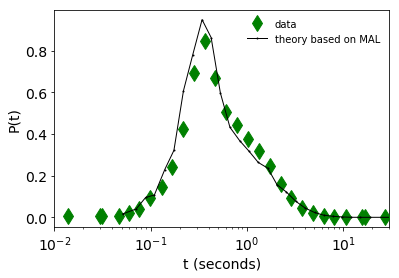

In [95]:
from multiprocessing import Pool
k1 = np.exp(-c) - 0.1
k2 = b+1.9
# Numero de palabras por BG real
W_n = np.asarray(lista_words.groupby("sentence").size())
# Words durations
words_durations = lista_words.duration.values[(lista_words.duration.values<5) & (lista_words.duration.values>0) ]

lista_tn = []
g = lista_words.groupby("sentence").size()

def func_parl(i):
    print(i)
    position = np.random.choice(np.arange(1, len(W_n)), 1)
    BG_size = W_n[position] # Se toma un tamano de BG al azar
    
    
    groups = g[g==int(BG_size)] # Se hace un subset de los BG reales con ese tamano
    subset_df = lista_words[lista_words.sentence.isin(list(groups.index))]  # Se hace un subset de los BG reales con ese tamano
    t1_n = subset_df.groupby("sentence").first().duration.values # Se hace una lista de la primera palabra de BG con n palabras
    tn = np.random.choice(t1_n, 1) # random de esa lista 
#     tn = listat1[position]

    #BG_size = np.random.choice(W_n, 1) # Tamano de la frase
    #tn = t1
    #tn = np.random.choice(words_durations)
    for j in range(2, int(BG_size)+1):
#         tn = tn*k1*( (1 + 1/(j-1))**k2 )
        tn = tn*k1*( (1 + k2/(j-1)) )
#     tn = tn + np.random.normal(0.14, 0.08)
    return float(tn)
    #lista_tn.append(tn)

pool = Pool(processes=7)
lista_tn = pool.map(func_parl, range(100000))

    
############################################################
# REAL
bin_mean_x_sentence, _, counts_norm_sentence, _ = histograma(dur_sentences, numero_bins=30)
# ACTUAL
lista_tn = np.asarray(lista_tn)
lista_tn = lista_tn[lista_tn>0]
bin_mean_x_sentence_Stocastic, _, counts_norm_sentence_Stocastic, _ = histograma(lista_tn, numero_bins=30)

# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_sentence, counts_norm_sentence, 'd', lw = 2, ms = 12, label= 'data', zorder=3, c="g")
ax.plot(bin_mean_x_sentence_Stocastic, counts_norm_sentence_Stocastic, '-o', lw = 1, ms = 1, label= 'theory based on MAL', zorder=3, c="k")
ax.legend(frameon = False)
ax.set_xscale("log")
ax.set_xlim([0.01, 30])


ax.set_xlabel("t (seconds)", fontsize=14)
ax.set_ylabel("P(t)", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI_MAL_model_BGlength_t1n.pdf")


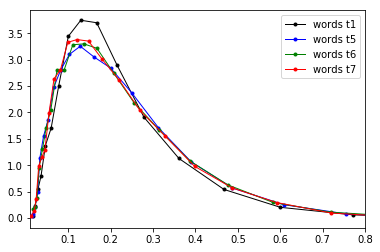

In [87]:
words_t1 = lista_words.groupby("sentence").nth(1).duration.values
bin_mean_x_t1, _, counts_norm_t1, _ = histograma(words_t1, numero_bins=30)

words_t2 = lista_words.groupby("sentence").nth(5).duration.values
bin_mean_x_t2, _, counts_norm_t2, _ = histograma(words_t2, numero_bins=30)


words_t3 = lista_words.groupby("sentence").nth(6).duration.values
bin_mean_x_t3, _, counts_norm_t3, _ = histograma(words_t3, numero_bins=30)


words_t4 = lista_words.groupby("sentence").nth(7).duration.values
bin_mean_x_t4, _, counts_norm_t4, _ = histograma(words_t4, numero_bins=30)


# Ploteamos
f, ax = plt.subplots()
ax.plot(bin_mean_x_t1, counts_norm_t1, '-o', lw = 1, ms = 3, label= 'words t1', zorder=3, c="k")
ax.plot(bin_mean_x_t2, counts_norm_t2, '-o', lw = 1, ms = 3, label= 'words t5', zorder=3, c="b")
ax.plot(bin_mean_x_t3, counts_norm_t3, '-o', lw = 1, ms = 3, label= 'words t6', zorder=3, c="g")
ax.plot(bin_mean_x_t4, counts_norm_t4, '-o', lw = 1, ms = 3, label= 'words t7', zorder=3, c="r")

ax.legend()

# ax.set_xscale("log")
ax.set_xlim([0.01, 0.8])
# ax.set_yscale("log")

f.savefig("resultados/Buckeye/1_LeyesLinguisticas/SI_distribution_wordlength_position_f.pdf")


In [23]:
# wordn = []
# wordlogtn = []


# for sentence in tabla_datos.sentence.unique()[1:10000]:
#     tablaSentence = tabla_datos[tabla_datos.sentence == sentence]
#     acum = tablaSentence.duration.cumsum().reset_index(drop=True)
#     log_acum = np.log(acum)
#     dif_log_acum = log_acum.diff()[1::]
#     wordn += list(dif_log_acum.index.values + 1) # Se anade un index
#     wordlogtn += list(dif_log_acum.values)


exponentes = [1.00304613 1.03339256]


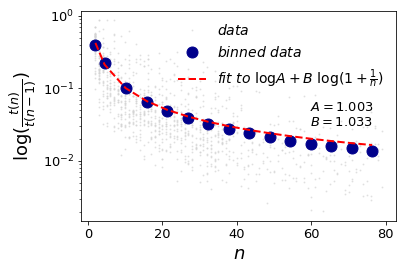

In [24]:
# # PLOT  DE LA FIGURA
# from scipy.optimize import curve_fit
# def func_logTolo(x, A, B):
#     return np.log(A) + B*np.log( 1 + 1/x)


# f, ax = plt.subplots()

# MentableModelo = pd.DataFrame({"n":wordn, "logtntn1": wordlogtn})
# MentableModelo = MentableModelo[MentableModelo.n<80]
# pos0, freq0 = binear_datos(MentableModelo.n.values, MentableModelo.logtntn1.values, bins=15, log = False)

# # MAIN PLOT
# #ax.plot(Mentable_sec.SentSize.values, Mentable_sec.WordsSize.values , 'o', lw = 2, ms = 2, zorder=2, alpha=1, color = "gray")
# ax.plot(MentableModelo.n.values[0:1000], MentableModelo.logtntn1.values[0:1000], 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey', label = r"$data$")
# ax.plot(pos0, freq0, 'o', lw = 2, ms = 11, zorder=2, alpha=1, color = "darkblue", label = r"$binned$" + " " + r"$data$")
# ax.set_yscale("log")
# # ax.set_xscale("log")



# ###########################################################
# x = MentableModelo.n.values
# y = MentableModelo.logtntn1.values
# # x = pos0
# # y = freq0


# # POWER LAW EXPONENTIAL
# popt, pcov = curve_fit(func_logTolo, x, y)
# expy = func_logTolo(pos0, popt[0], popt[1])
# ax.plot(pos0, expy, "--", lw=2, color="red", label = r"$fit \ to \ \log{A} + B\ \log({1 + \frac{1}{n}})$")
# print("exponentes = " + str(popt))


# # # GET R2
# # residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
# # ss_res = np.sum(residuals**2)
# # ss_tot = np.sum((y - np.mean(y))**2)
# # R2 = 1 - (ss_res / ss_tot)
# # print("R2:" + str(R2))
# # print("")

# ax.legend(frameon=False, fontsize=14)
# ax.set_xlabel(r"$n$", fontsize = 18)
# ax.set_ylabel(r"$\log{(\frac{t(n)}{t(n-1)})}$", fontsize = 18)
# ax.tick_params(axis='x', labelsize=13)
# ax.tick_params(axis='y', labelsize=13)


# f.text(0.7, 0.48, r"$A=1.003$" + "\n" +  r"$B=1.033$", fontsize = 13)

# f.subplots_adjust(bottom=0.15, left = 0.17)
# f.savefig("resultados/Buckeye/1_LeyesLinguisticas/9_ModeloMABL.pdf")



## 5.2 Sentences length (number of words) VS words length (number of phonemes)


In [248]:
#Mentable = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_numphonemes})
#Menzerath = Mentable.groupby("SentSize").mean()

# FIGURA MENZERATH
#f, ax = plt.subplots()


# MAIN PLOT
#lns1 = ax.plot(Menzerath, 'o', lw = 2, ms = 7, zorder=2, alpha=0.8)

#ax.set_xlabel("Sentence length (number of words)")
#ax.set_ylabel("Words length (number of phonemes)")


#f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath2.pdf")
    


## 5.3 Sentences length (number of words) VS words length (seconds)


In [247]:
#Mentable_sec = pd.DataFrame({"SentSize":SentenceSize_numwords, "WordsSize": WordsSize_seconds})
#Menzerath_sec = Mentable_sec.groupby("SentSize").mean()

## FIGURA MENZERATH
#f, ax = plt.subplots()


## MAIN PLOT
#lns1 = ax.plot(Menzerath_sec, 'o', lw = 2, ms = 7, zorder=2, alpha=0.8)

#ax.set_xlabel("Sentence length (number of words)")
#ax.set_ylabel("Words length (seconds)")


#f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath3.pdf")



# 5.4 Words length (number of phonemes) VS phonemes length (seconds)


In [88]:
#WordLength_num_phonemes = tabla_datos[tabla_datos.tipe == "w"].numphonemes
WordLength_num_phonemes = tabla_datos[tabla_datos.tipe == "p"].groupby("numtoken").count()["token"]
PhonemeLength_seconds = tabla_datos[tabla_datos.tipe == "p"].groupby("numtoken").mean().duration

Power law exponential:
exponentes = [ 0.10843197 -0.2307692  -0.00751909]
R2:0.9026976145744043



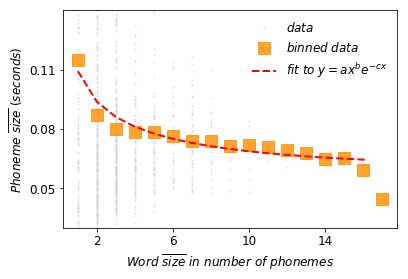

In [89]:
def func_powerlawexp(x, alfa, beta, gamma):
    return alfa * x**(beta) * np.exp(-gamma*x)

Mentable = pd.DataFrame({"WordSize":WordLength_num_phonemes.values, "PhoneSize": PhonemeLength_seconds.values})
Menzerath = Mentable.groupby("WordSize").mean()


# FIGURA MENZERATH
f, ax = plt.subplots()
pos0, freq0 = binear_datos(Mentable.WordSize.values, Mentable.PhoneSize.values, bins=16, log = False)

# MAIN PLOT
ax.plot(Mentable.WordSize.values[0:1000], Mentable.PhoneSize.values[0:1000], 'o', ms = 1, zorder=2, alpha=0.5, label = r"$data$", color = 'lightgrey')
ax.plot(Menzerath, 's', lw = 2, ms = 12, zorder=2, alpha=0.8, color="darkorange", label=r"$binned$" + " " + r"$data$")



ax.set_xlabel("Word length(<phonem>)",fontsize=12)
ax.set_ylabel("Phoneme length (<sec>)", fontsize=12)

#ax.set_xscale("log")
#ax.set_yscale("log")


ax.set_xticks([2, 6, 10, 14, 18])
ax.set_yticks([0.05, 0.08, 0.11])
ax.set_ylim([0.03,0.14])

x = pos0
y = freq0

# POWER LAW EXPONENTIAL
print("Power law exponential:")
popt, pcov = curve_fit(func_powerlawexp, x, y)
expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, color="red", label = r"$fit$" + " " + r"$to$" + " " + r"$y = ax^b e^{-cx}$")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")


ax.legend(frameon = False, loc = "best", fontsize=12)


ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.set_xlabel(r"$Word$" + " " + r"$\overline{size}$" + " " + r"$in$" + " " + r"$number$" + " " + r"$of$" + " " + r"$phonemes$")
ax.set_ylabel(r"$Phoneme$" + " " + r"$\overline{size}$" + " " + r"$(seconds)$")


f.savefig("resultados/Buckeye/1_LeyesLinguisticas/5_Menzerath_Words_Phonemes.pdf")



Power law exponential:
exponentes = [ 0.08847011 -0.00672618  0.02114141]
R2:0.9096270889279339

Lucas Function:
exponentes = [0.0054592  0.00562455 0.07298514]
R2:0.9640201114609271



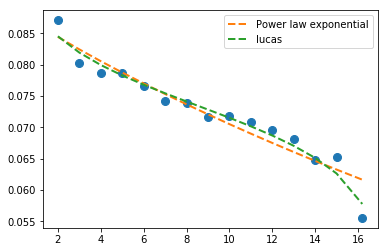

In [90]:
### # FITTED DATA #######################################################
####################################################################
from scipy.optimize import curve_fit
def func_powerlawexp(x, alfa, beta, gamma):
    return alfa * x**(beta) * np.exp(-gamma*x)

def func_shiftedpowerlaw(x, alfa, beta, gamma):
    #Shifted power law
    return alfa * (x + beta)**(gamma)

def func_estrechedexp(x, alfa, beta, gamma):
    #Shifted power law
    return alfa * np.exp((x*beta)**(-gamma))

def func_lucas(x, a, b, k):
    return k + b*np.log(x[-1] + 1 -x) - a*np.log(x)



#####################################

f, ax = plt.subplots()
x = np.asarray(pos0[1::])
y = np.asarray(freq0[1::])

# x = np.asarray(pos1)
# y = np.asarray(freq1)

# x = np.asarray(pos2)
# y = np.asarray(freq2)

ax.plot(x, y, "o", ms=8)
#ax.set_xscale("log")
#ax.set_yscale("log")


# POWER LAW EXPONENTIAL
print("Power law exponential:")
popt, pcov = curve_fit(func_powerlawexp, x, y)
expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, label="Power law exponential")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")






# # func_shiftedpowerlaw
# print("Shifted power law:")
# popt, pcov = curve_fit(func_shiftedpowerlaw, x, y)
# expy = func_shiftedpowerlaw(x, popt[0], popt[1], popt[2])
# ax.plot(x, expy, "--", lw=2)
# print("exponentes = " + str(popt))

# # GET R2
# residuals = y - func_shiftedpowerlaw(x, popt[0], popt[1], popt[2])
# ss_res = np.sum(residuals**2)
# ss_tot = np.sum((y - np.mean(y))**2)
# R2 = 1 - (ss_res / ss_tot)
# print("R2:" + str(R2))
# print("")



# # Estreched exponential
# print("Estreched exponential:")
# popt, pcov = curve_fit(func_estrechedexp, x, y)
# expy = func_estrechedexp(x, popt[0], popt[1], popt[2])
# ax.plot(x, expy, "--", lw=2)
# print("exponentes = " + str(popt))

# # GET R2
# residuals = y - func_estrechedexp(x, popt[0], popt[1], popt[2])
# ss_res = np.sum(residuals**2)
# ss_tot = np.sum((y - np.mean(y))**2)
# R2 = 1 - (ss_res / ss_tot)
# print("R2:" + str(R2))
# print("")



# Lucas function
print("Lucas Function:")
popt, pcov = curve_fit(func_lucas, x, y)
expy = func_lucas(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, label="lucas")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_lucas(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")

ax.legend()



# Modelo Nulo Menzerath con lo de LogNormal

(0.04, 0.13)

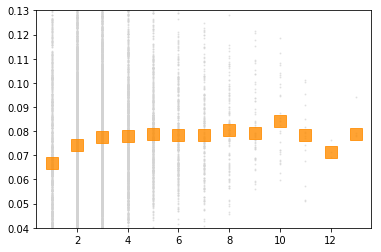

In [91]:
# RANDOM LN PHONEME GENERATION
randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=10000)


# NUMERO DE PHONEMAS POR PALABRA
PhonemesPerWord = np.asarray(lista_words.numphonemes)
RandPhonPerWord = np.random.choice(PhonemesPerWord, size = 10000, replace = True)

# Duracion media de los phonemas en esa palabra
randMeanSizePhon = [np.random.choice(randLNphonemes, size=i).mean() for i in RandPhonPerWord]


MentableRANDOM = pd.DataFrame({"WordSize":RandPhonPerWord, "PhoneSize": randMeanSizePhon})

MenzerathRANDOM = MentableRANDOM.groupby("WordSize").median()


# FIGURA MENZERATH
f, ax = plt.subplots()
pos0, freq0 = binear_datos(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, bins=16, log = False)


# MAIN PLOT
ax.plot(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')
ax.plot(MenzerathRANDOM, 's', lw = 2, ms = 12, zorder=2, alpha=0.8, color="darkorange")
ax.set_ylim([0.04, 0.13])

# Interacting version of the model

Power law exponential:
exponentes = [ 0.08013115 -0.04847877  0.1560748 ]
R2:0.9980254274767294



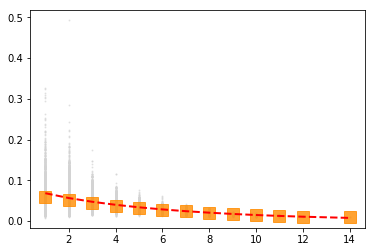

In [92]:
def func_powerlawexp(x, alfa, beta, gamma):
    return alfa * x**(beta) * np.exp(-gamma*x)


# RANDOM LN PHONEME GENERATION
randLNphonemes = np.random.lognormal(mean=-2.681, sigma=0.59, size=10000)


# NUMERO DE PHONEMAS POR PALABRA
PhonemesPerWord = np.asarray(lista_words.numphonemes)
RandPhonPerWord = np.random.choice(PhonemesPerWord, size = 10000, replace = True)


randMeanSizePhon = []
randTotalSize = []
for i in RandPhonPerWord:
    p = randLNphonemes**(-0.5*i)
    #p = randLNphonemes**0
    p = p/p.sum()
    words = np.random.choice(randLNphonemes, size=i, p=p)
    randMeanSizePhon.append(words.mean())
    randTotalSize.append(words.sum())
    

    
MentableRANDOM = pd.DataFrame({"WordSize":RandPhonPerWord, "PhoneSize": randMeanSizePhon})

MenzerathRANDOM = MentableRANDOM.groupby("WordSize").median()


# FIGURA MENZERATH
f, ax = plt.subplots()
pos0, freq0 = binear_datos(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, bins=16, log = False)


# MAIN PLOT
ax.plot(MentableRANDOM.WordSize.values, MentableRANDOM.PhoneSize.values, 'o', ms = 1, zorder=2, alpha=0.5, color = 'lightgrey')
ax.plot(MenzerathRANDOM, 's', lw = 2, ms = 12, zorder=2, alpha=0.8, color="darkorange")
#ax.set_ylim([0.0, 0.09])



#####################################################################################################3

x = pos0
y = freq0

# POWER LAW EXPONENTIAL
print("Power law exponential:")
popt, pcov = curve_fit(func_powerlawexp, x, y)
expy = func_powerlawexp(x, popt[0], popt[1], popt[2])
ax.plot(x, expy, "--", lw=2, color="red")
print("exponentes = " + str(popt))

# GET R2
residuals = y - func_powerlawexp(x, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
R2 = 1 - (ss_res / ss_tot)
print("R2:" + str(R2))
print("")

